# 공공데이터를 활용한 미세먼지 농도 예측 프로젝트
## 단계2. 모델링(LSTM)

## 0.프로젝트 소개

### (1) 수행 목표
- 미세먼지 농도를 예측하는 머신러닝 모델을 만드세요.

#### 우리가 풀어야 하는 문제는 무엇인가요?
* 서울 지역의 미세먼지 데이터와 날씨 데이터를 활용하여,
미세먼지 예측에 관련 있는 데이터 항목으로 데이터를 구성, 전처리 하여
미세먼지 농도를 예측하는 머신러닝 모델 구현


### (2) 데이터 소개

#### 1) 기본 데이터

* 학습 데이터
    * air_2021.csv : 2021년 미세먼지 데이터
    * weather_2021.csv : 2021년 날씨 데이터
* 테스트 데이터
    * air_2022.csv : 2022년 미세먼지 데이터
    * weather_2022.csv : 2022년 날씨 데이터

#### 2) 데이터셋의 변수 소개(weather_2021)

* 증기압: 증기가 고체 또는 액체와 동적 평형 상태에 있을 때 증기의 압력 (증기가 되려는 힘)
* 이슬점 온도: 불포화 상태의 공기가 냉각될 때, 포화 상태에 도달하여 수증기의 응결이 시작되는 온도
* 일조: 일정한 물체나 땅의 겉면에 태양 광선이 비치는 시간 (1시간 중 비율)
* 일사(량): 태양으로부터 오는 태양 복사 에너지가 지표에 닿는 양 (면적당 에너지 량)
* 전운량: 하늘을 육안으로 관측하여 전부 구름일 때 10, 구름이 덮고 있는 하늘의 비율에 따라 0~10
* 중하층운량: 중층과 하층에 있는 구름의 분포량(중하층 구름이 날씨에 영향 주므로 따로 표기)
* 운형(운형약어): 구름의 종류. 약어 코드로 기재됨
* 최저운고: 가장 낮은 구름의 높이
* 현상번호(국내식): 비, 소낙비, 싸락눈, 눈보라 등의 기상현상을 나타낸 코드번호
* 지면온도: 지면 0cm 온도
* 지중온도: 땅 속 온도변수1

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Dataset

In [3]:
class FineDustDataset(Dataset):
    def __init__(self, x_path, y_path=None, sequence_length=168):
        self.x_data = pd.read_csv(x_path).values.astype("float32")
        self.sequence_length = sequence_length
        self.y_data = None

        if y_path is not None:
            self.y_data = pd.read_csv(y_path).values.astype("float32")

    def __len__(self):
        return len(self.x_data) - self.sequence_length + 1

    def __getitem__(self, idx):
        x = self.x_data[idx:idx + self.sequence_length]
        x = torch.tensor(x)

        if self.y_data is not None:
            y = self.y_data[idx + self.sequence_length - 1]  # Target is the last step in sequence
            y = torch.tensor(y, dtype=torch.float32)
            return x, y

        return x

# Model - LSTM

In [4]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=3, dropout=0.5):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # Get the output and hidden states
        _, (hn, _) = self.lstm(x)  # hn has shape (num_layers, batch_size, hidden_size)
        out = self.layer_norm(hn[-1])
        out = self.fc(out)      # We take the last hidden state
        return out.squeeze(1)       # Remove the extra dimension to match the target shape


# Trainer

In [5]:
class FineDustPredictor:
    def __init__(self, input_size=26, hidden_size=128, sequence_length=168, learning_rate=1e-3, weight_decay=1e-4, epochs=100, save_path="best_model.pth", patience=1e10, min_delta=0.0001):
        self.epochs = epochs
        self.patience = patience
        self.min_delta = min_delta
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.sequence_length = sequence_length
        self.save_path = save_path

        # Model, Loss, Optimizer, Scheduler
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = LSTM(input_size, hidden_size, num_layers=2, dropout=0.3).to(self.device)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.AdamW(self.model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6)

        # For tracking metrics
        self.train_losses = []
        self.val_losses = []
        self.r2_scores = []
        self.best_r2 = -float('inf')
        self.early_stop_counter = 0

    def train(self, train_loader, val_loader):
        for epoch in range(self.epochs):
            self.model.train()
            epoch_train_loss = 0

            for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{self.epochs}", leave=True):
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                targets = targets.squeeze(1)  # Adjust target shape to (batch_size,)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                epoch_train_loss += loss.item()

            self.train_losses.append(epoch_train_loss / len(train_loader))

            # Validation step
            val_loss, r2 = self.validate(val_loader)
            self.scheduler.step(val_loss)
            self.val_losses.append(val_loss)
            self.r2_scores.append(r2)

            # Check for best model and save if best
            if r2 > self.best_r2 + self.min_delta:
                self.best_r2 = r2
                torch.save(self.model.state_dict(), self.save_path)
                print('-'*100)
                print(f"New best model saved with R2 Score: {self.best_r2:.4f}")
                print('='*100)
                self.early_stop_counter = 0  # Reset counter if model improves
            else:
                self.early_stop_counter += 1

            # Early stopping condition
            if self.early_stop_counter >= self.patience:
                print("Early stopping triggered.")
                break

            print(f"Epoch [{epoch+1}/{self.epochs}], "
                  f"Train Loss: {self.train_losses[-1]:.4f}, "
                  f"Val Loss: {val_loss:.4f}, "
                  f"R2 Score: {r2:.4f}, "
                  f"Best R2 Score: {self.best_r2:.4f}")

    def validate(self, loader):
        self.model.eval()
        predictions = []
        actuals = []
        total_loss = 0

        with torch.no_grad():
            for inputs, targets in tqdm(loader, desc="Evaluating", leave=False):
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                targets = targets.squeeze(1)  # Adjust target shape to (batch_size,)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                total_loss += loss.item()
                predictions.extend(outputs.squeeze().cpu().tolist())
                actuals.extend(targets.cpu().tolist())

        avg_loss = total_loss / len(loader)
        r2 = r2_score(actuals, predictions)
        return avg_loss, r2

    def plot_metrics(self):
        epochs = range(1, len(self.train_losses) + 1)

        plt.figure(figsize=(14, 6))

        # Plotting Train and Validation Loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.train_losses, label="Train Loss")
        plt.plot(epochs, self.val_losses, label="Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("MSE Loss")
        plt.title("Train and Validation Loss")
        plt.legend()

        # Plotting R2 Score
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.r2_scores, label="R2 Score", color="green")
        plt.xlabel("Epochs")
        plt.ylabel("R2 Score")
        plt.title("Validation R2 Score")
        plt.legend()

        plt.tight_layout()
        plt.show()

    def load_best_model(self):
        # Load the best model from the saved file
        self.model.load_state_dict(torch.load(self.save_path, weights_only=True))
        print("Best model loaded for testing.")

    def test(self, test_loader):
        # Ensure the best model is loaded before testing
        self.load_best_model()

        self.model.eval()
        predictions = []
        actuals = []
        total_loss = 0

        with torch.no_grad():
            for inputs, targets in tqdm(test_loader, desc="Testing", leave=True):
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                targets = targets.squeeze(1)  # Adjust target shape to (batch_size,)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                total_loss += loss.item()
                predictions.extend(outputs.squeeze().cpu().tolist())
                actuals.extend(targets.cpu().tolist())

        avg_loss = total_loss / len(test_loader)
        r2 = r2_score(actuals, predictions)
        print(f"Test Loss: {avg_loss:.4f}, Test R2 Score: {r2:.4f}")
        return avg_loss, r2


## Train

In [6]:
train_x='./data/train_x.csv'
train_y='./data/train_y.csv'
test_x='./data/test_x.csv'
test_y='./data/test_y.csv'

In [7]:
train_dataset = FineDustDataset(x_path=train_x, y_path=train_y, sequence_length=168)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=False)
train_size = int(len(train_dataset) * 0.9)  # 90% train
val_size = len(train_dataset) - train_size  # 10% val

train_subset = torch.utils.data.Subset(train_dataset, range(train_size))
val_subset = torch.utils.data.Subset(train_dataset, range(train_size, len(train_dataset)))

train_loader = DataLoader(train_subset, batch_size=128, shuffle=False)
val_loader = DataLoader(val_subset, batch_size=128, shuffle=False)

In [8]:
predictor = FineDustPredictor(input_size=26, hidden_size=512, sequence_length=24, learning_rate=1e-4, weight_decay=1e-4, epochs=1000)
# 7 days = 168 hours

In [9]:
predictor.train(train_loader, val_loader)

Epoch 1/1000: 100%|██████████| 59/59 [00:02<00:00, 22.18it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: -0.0460
Epoch [1/1000], Train Loss: 3479.3998, Val Loss: 135.3711, R2 Score: -0.0460, Best R2 Score: -0.0460


Epoch 2/1000: 100%|██████████| 59/59 [00:01<00:00, 29.60it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.0003
Epoch [2/1000], Train Loss: 3187.9330, Val Loss: 129.4318, R2 Score: 0.0003, Best R2 Score: 0.0003


Epoch 3/1000: 100%|██████████| 59/59 [00:01<00:00, 29.51it/s]


Epoch [3/1000], Train Loss: 3076.1689, Val Loss: 133.7587, R2 Score: -0.0297, Best R2 Score: 0.0003


Epoch 4/1000: 100%|██████████| 59/59 [00:02<00:00, 29.34it/s]


Epoch [4/1000], Train Loss: 2982.9786, Val Loss: 145.8949, R2 Score: -0.1175, Best R2 Score: 0.0003


Epoch 5/1000: 100%|██████████| 59/59 [00:02<00:00, 29.46it/s]


Epoch [5/1000], Train Loss: 2900.3982, Val Loss: 165.1254, R2 Score: -0.2577, Best R2 Score: 0.0003


Epoch 6/1000: 100%|██████████| 59/59 [00:02<00:00, 29.37it/s]


Epoch [6/1000], Train Loss: 2827.9944, Val Loss: 190.3290, R2 Score: -0.4422, Best R2 Score: 0.0003


Epoch 7/1000: 100%|██████████| 59/59 [00:01<00:00, 29.50it/s]


Epoch [7/1000], Train Loss: 2765.5816, Val Loss: 220.1820, R2 Score: -0.6611, Best R2 Score: 0.0003


Epoch 8/1000: 100%|██████████| 59/59 [00:02<00:00, 29.41it/s]


Epoch [8/1000], Train Loss: 2712.6771, Val Loss: 253.5893, R2 Score: -0.9064, Best R2 Score: 0.0003


Epoch 9/1000: 100%|██████████| 59/59 [00:02<00:00, 29.25it/s]


Epoch [9/1000], Train Loss: 2673.6740, Val Loss: 272.3932, R2 Score: -1.0446, Best R2 Score: 0.0003


Epoch 10/1000: 100%|██████████| 59/59 [00:02<00:00, 29.30it/s]


Epoch [10/1000], Train Loss: 2653.5359, Val Loss: 290.5623, R2 Score: -1.1781, Best R2 Score: 0.0003


Epoch 11/1000: 100%|██████████| 59/59 [00:02<00:00, 29.32it/s]


Epoch [11/1000], Train Loss: 2635.5437, Val Loss: 308.7158, R2 Score: -1.3116, Best R2 Score: 0.0003


Epoch 12/1000: 100%|██████████| 59/59 [00:02<00:00, 29.42it/s]


Epoch [12/1000], Train Loss: 2619.3427, Val Loss: 326.9435, R2 Score: -1.4456, Best R2 Score: 0.0003


Epoch 13/1000: 100%|██████████| 59/59 [00:02<00:00, 29.17it/s]


Epoch [13/1000], Train Loss: 2604.7190, Val Loss: 344.9912, R2 Score: -1.5783, Best R2 Score: 0.0003


Epoch 14/1000: 100%|██████████| 59/59 [00:02<00:00, 29.24it/s]


Epoch [14/1000], Train Loss: 2591.5942, Val Loss: 363.0452, R2 Score: -1.7111, Best R2 Score: 0.0003


Epoch 15/1000: 100%|██████████| 59/59 [00:02<00:00, 29.05it/s]


Epoch [15/1000], Train Loss: 2580.5488, Val Loss: 373.7106, R2 Score: -1.7897, Best R2 Score: 0.0003


Epoch 16/1000: 100%|██████████| 59/59 [00:02<00:00, 29.25it/s]


Epoch [16/1000], Train Loss: 2574.7405, Val Loss: 382.4941, R2 Score: -1.8543, Best R2 Score: 0.0003


Epoch 17/1000: 100%|██████████| 59/59 [00:02<00:00, 29.04it/s]


Epoch [17/1000], Train Loss: 2569.5320, Val Loss: 391.5512, R2 Score: -1.9210, Best R2 Score: 0.0003


Epoch 18/1000: 100%|██████████| 59/59 [00:02<00:00, 29.07it/s]


Epoch [18/1000], Train Loss: 2564.5578, Val Loss: 400.3431, R2 Score: -1.9856, Best R2 Score: 0.0003


Epoch 19/1000: 100%|██████████| 59/59 [00:02<00:00, 29.02it/s]


Epoch [19/1000], Train Loss: 2559.8925, Val Loss: 409.0973, R2 Score: -2.0501, Best R2 Score: 0.0003


Epoch 20/1000: 100%|██████████| 59/59 [00:02<00:00, 28.89it/s]


Epoch [20/1000], Train Loss: 2555.4672, Val Loss: 417.7319, R2 Score: -2.1136, Best R2 Score: 0.0003


Epoch 21/1000: 100%|██████████| 59/59 [00:02<00:00, 28.73it/s]


Epoch [21/1000], Train Loss: 2551.2547, Val Loss: 422.0320, R2 Score: -2.1452, Best R2 Score: 0.0003


Epoch 22/1000: 100%|██████████| 59/59 [00:02<00:00, 28.84it/s]


Epoch [22/1000], Train Loss: 2549.2036, Val Loss: 426.2052, R2 Score: -2.1759, Best R2 Score: 0.0003


Epoch 23/1000: 100%|██████████| 59/59 [00:02<00:00, 28.52it/s]


Epoch [23/1000], Train Loss: 2547.2355, Val Loss: 430.3590, R2 Score: -2.2065, Best R2 Score: 0.0003


Epoch 24/1000: 100%|██████████| 59/59 [00:02<00:00, 28.63it/s]


Epoch [24/1000], Train Loss: 2545.3038, Val Loss: 434.3916, R2 Score: -2.2361, Best R2 Score: 0.0003


Epoch 25/1000: 100%|██████████| 59/59 [00:02<00:00, 28.82it/s]


Epoch [25/1000], Train Loss: 2543.4568, Val Loss: 438.4657, R2 Score: -2.2660, Best R2 Score: 0.0003


Epoch 26/1000: 100%|██████████| 59/59 [00:02<00:00, 28.79it/s]


Epoch [26/1000], Train Loss: 2541.6104, Val Loss: 442.3637, R2 Score: -2.2947, Best R2 Score: 0.0003


Epoch 27/1000: 100%|██████████| 59/59 [00:02<00:00, 28.64it/s]


Epoch [27/1000], Train Loss: 2539.6474, Val Loss: 443.9082, R2 Score: -2.3059, Best R2 Score: 0.0003


Epoch 28/1000: 100%|██████████| 59/59 [00:02<00:00, 28.74it/s]


Epoch [28/1000], Train Loss: 2538.7570, Val Loss: 445.5616, R2 Score: -2.3180, Best R2 Score: 0.0003


Epoch 29/1000: 100%|██████████| 59/59 [00:02<00:00, 28.45it/s]


Epoch [29/1000], Train Loss: 2537.8424, Val Loss: 447.1047, R2 Score: -2.3292, Best R2 Score: 0.0003


Epoch 30/1000: 100%|██████████| 59/59 [00:02<00:00, 28.69it/s]


Epoch [30/1000], Train Loss: 2536.9186, Val Loss: 448.5366, R2 Score: -2.3395, Best R2 Score: 0.0003


Epoch 31/1000: 100%|██████████| 59/59 [00:02<00:00, 28.50it/s]


Epoch [31/1000], Train Loss: 2535.9919, Val Loss: 449.8306, R2 Score: -2.3488, Best R2 Score: 0.0003


Epoch 32/1000: 100%|██████████| 59/59 [00:02<00:00, 28.52it/s]


Epoch [32/1000], Train Loss: 2535.0412, Val Loss: 450.9180, R2 Score: -2.3566, Best R2 Score: 0.0003


Epoch 33/1000: 100%|██████████| 59/59 [00:02<00:00, 28.41it/s]


Epoch [33/1000], Train Loss: 2533.8598, Val Loss: 451.0277, R2 Score: -2.3572, Best R2 Score: 0.0003


Epoch 34/1000: 100%|██████████| 59/59 [00:02<00:00, 28.16it/s]


Epoch [34/1000], Train Loss: 2533.3614, Val Loss: 451.1349, R2 Score: -2.3577, Best R2 Score: 0.0003


Epoch 35/1000: 100%|██████████| 59/59 [00:02<00:00, 28.22it/s]


Epoch [35/1000], Train Loss: 2532.8023, Val Loss: 451.1700, R2 Score: -2.3577, Best R2 Score: 0.0003


Epoch 36/1000: 100%|██████████| 59/59 [00:02<00:00, 28.28it/s]


Epoch [36/1000], Train Loss: 2532.2365, Val Loss: 451.1275, R2 Score: -2.3571, Best R2 Score: 0.0003


Epoch 37/1000: 100%|██████████| 59/59 [00:02<00:00, 27.95it/s]


Epoch [37/1000], Train Loss: 2531.6837, Val Loss: 451.0139, R2 Score: -2.3560, Best R2 Score: 0.0003


Epoch 38/1000: 100%|██████████| 59/59 [00:02<00:00, 28.11it/s]


Epoch [38/1000], Train Loss: 2531.0844, Val Loss: 450.8079, R2 Score: -2.3541, Best R2 Score: 0.0003


Epoch 39/1000: 100%|██████████| 59/59 [00:02<00:00, 27.94it/s]


Epoch [39/1000], Train Loss: 2530.3353, Val Loss: 450.4406, R2 Score: -2.3512, Best R2 Score: 0.0003


Epoch 40/1000: 100%|██████████| 59/59 [00:02<00:00, 28.19it/s]


Epoch [40/1000], Train Loss: 2529.9757, Val Loss: 450.0312, R2 Score: -2.3479, Best R2 Score: 0.0003


Epoch 41/1000: 100%|██████████| 59/59 [00:02<00:00, 27.82it/s]


Epoch [41/1000], Train Loss: 2529.6625, Val Loss: 449.6556, R2 Score: -2.3449, Best R2 Score: 0.0003


Epoch 42/1000: 100%|██████████| 59/59 [00:02<00:00, 27.88it/s]


Epoch [42/1000], Train Loss: 2529.3112, Val Loss: 449.2851, R2 Score: -2.3420, Best R2 Score: 0.0003


Epoch 43/1000: 100%|██████████| 59/59 [00:02<00:00, 27.98it/s]


Epoch [43/1000], Train Loss: 2528.9588, Val Loss: 448.8825, R2 Score: -2.3388, Best R2 Score: 0.0003


Epoch 44/1000: 100%|██████████| 59/59 [00:02<00:00, 27.72it/s]


Epoch [44/1000], Train Loss: 2528.5526, Val Loss: 448.3938, R2 Score: -2.3349, Best R2 Score: 0.0003


Epoch 45/1000: 100%|██████████| 59/59 [00:02<00:00, 27.98it/s]


Epoch [45/1000], Train Loss: 2528.1181, Val Loss: 448.0280, R2 Score: -2.3320, Best R2 Score: 0.0003


Epoch 46/1000: 100%|██████████| 59/59 [00:02<00:00, 28.03it/s]


Epoch [46/1000], Train Loss: 2527.8610, Val Loss: 447.6653, R2 Score: -2.3292, Best R2 Score: 0.0003


Epoch 47/1000: 100%|██████████| 59/59 [00:02<00:00, 28.16it/s]


Epoch [47/1000], Train Loss: 2527.6645, Val Loss: 447.2957, R2 Score: -2.3263, Best R2 Score: 0.0003


Epoch 48/1000: 100%|██████████| 59/59 [00:02<00:00, 27.61it/s]


Epoch [48/1000], Train Loss: 2527.3889, Val Loss: 446.9381, R2 Score: -2.3235, Best R2 Score: 0.0003


Epoch 49/1000: 100%|██████████| 59/59 [00:02<00:00, 27.72it/s]


Epoch [49/1000], Train Loss: 2527.1139, Val Loss: 446.5536, R2 Score: -2.3205, Best R2 Score: 0.0003


Epoch 50/1000: 100%|██████████| 59/59 [00:02<00:00, 27.60it/s]


Epoch [50/1000], Train Loss: 2526.8858, Val Loss: 446.1594, R2 Score: -2.3174, Best R2 Score: 0.0003


Epoch 51/1000: 100%|██████████| 59/59 [00:02<00:00, 27.23it/s]


Epoch [51/1000], Train Loss: 2526.5965, Val Loss: 445.7729, R2 Score: -2.3144, Best R2 Score: 0.0003


Epoch 52/1000: 100%|██████████| 59/59 [00:02<00:00, 27.74it/s]


Epoch [52/1000], Train Loss: 2526.3219, Val Loss: 445.3412, R2 Score: -2.3110, Best R2 Score: 0.0003


Epoch 53/1000: 100%|██████████| 59/59 [00:02<00:00, 27.68it/s]


Epoch [53/1000], Train Loss: 2526.0468, Val Loss: 444.9119, R2 Score: -2.3076, Best R2 Score: 0.0003


Epoch 54/1000: 100%|██████████| 59/59 [00:02<00:00, 27.67it/s]


Epoch [54/1000], Train Loss: 2525.7878, Val Loss: 444.4865, R2 Score: -2.3043, Best R2 Score: 0.0003


Epoch 55/1000: 100%|██████████| 59/59 [00:02<00:00, 27.95it/s]


Epoch [55/1000], Train Loss: 2525.5059, Val Loss: 444.0631, R2 Score: -2.3010, Best R2 Score: 0.0003


Epoch 56/1000: 100%|██████████| 59/59 [00:02<00:00, 27.96it/s]


Epoch [56/1000], Train Loss: 2525.2392, Val Loss: 443.6157, R2 Score: -2.2976, Best R2 Score: 0.0003


Epoch 57/1000: 100%|██████████| 59/59 [00:02<00:00, 27.99it/s]


Epoch [57/1000], Train Loss: 2524.8968, Val Loss: 443.1428, R2 Score: -2.2939, Best R2 Score: 0.0003


Epoch 58/1000: 100%|██████████| 59/59 [00:02<00:00, 27.82it/s]


Epoch [58/1000], Train Loss: 2524.6973, Val Loss: 442.7227, R2 Score: -2.2906, Best R2 Score: 0.0003


Epoch 59/1000: 100%|██████████| 59/59 [00:02<00:00, 27.71it/s]


Epoch [59/1000], Train Loss: 2524.4055, Val Loss: 442.2741, R2 Score: -2.2871, Best R2 Score: 0.0003


Epoch 60/1000: 100%|██████████| 59/59 [00:02<00:00, 28.08it/s]


Epoch [60/1000], Train Loss: 2524.0929, Val Loss: 441.8174, R2 Score: -2.2836, Best R2 Score: 0.0003


Epoch 61/1000: 100%|██████████| 59/59 [00:02<00:00, 27.81it/s]


Epoch [61/1000], Train Loss: 2523.8091, Val Loss: 441.3270, R2 Score: -2.2798, Best R2 Score: 0.0003


Epoch 62/1000: 100%|██████████| 59/59 [00:02<00:00, 28.04it/s]


Epoch [62/1000], Train Loss: 2523.5505, Val Loss: 440.8475, R2 Score: -2.2761, Best R2 Score: 0.0003


Epoch 63/1000: 100%|██████████| 59/59 [00:02<00:00, 28.18it/s]


Epoch [63/1000], Train Loss: 2523.2769, Val Loss: 440.3914, R2 Score: -2.2725, Best R2 Score: 0.0003


Epoch 64/1000: 100%|██████████| 59/59 [00:02<00:00, 28.28it/s]


Epoch [64/1000], Train Loss: 2522.9534, Val Loss: 439.8888, R2 Score: -2.2686, Best R2 Score: 0.0003


Epoch 65/1000: 100%|██████████| 59/59 [00:02<00:00, 28.34it/s]


Epoch [65/1000], Train Loss: 2522.6561, Val Loss: 439.3904, R2 Score: -2.2647, Best R2 Score: 0.0003


Epoch 66/1000: 100%|██████████| 59/59 [00:02<00:00, 28.05it/s]


Epoch [66/1000], Train Loss: 2522.3587, Val Loss: 438.8182, R2 Score: -2.2603, Best R2 Score: 0.0003


Epoch 67/1000: 100%|██████████| 59/59 [00:02<00:00, 28.02it/s]


Epoch [67/1000], Train Loss: 2522.0427, Val Loss: 438.2711, R2 Score: -2.2561, Best R2 Score: 0.0003


Epoch 68/1000: 100%|██████████| 59/59 [00:02<00:00, 28.26it/s]


Epoch [68/1000], Train Loss: 2521.7486, Val Loss: 437.6980, R2 Score: -2.2516, Best R2 Score: 0.0003


Epoch 69/1000: 100%|██████████| 59/59 [00:02<00:00, 28.35it/s]


Epoch [69/1000], Train Loss: 2521.3831, Val Loss: 437.0765, R2 Score: -2.2468, Best R2 Score: 0.0003


Epoch 70/1000: 100%|██████████| 59/59 [00:02<00:00, 28.14it/s]


Epoch [70/1000], Train Loss: 2521.0812, Val Loss: 436.4336, R2 Score: -2.2419, Best R2 Score: 0.0003


Epoch 71/1000: 100%|██████████| 59/59 [00:02<00:00, 27.95it/s]


Epoch [71/1000], Train Loss: 2520.7280, Val Loss: 435.7593, R2 Score: -2.2367, Best R2 Score: 0.0003


Epoch 72/1000: 100%|██████████| 59/59 [00:02<00:00, 27.65it/s]


Epoch [72/1000], Train Loss: 2520.4083, Val Loss: 435.0555, R2 Score: -2.2312, Best R2 Score: 0.0003


Epoch 73/1000: 100%|██████████| 59/59 [00:02<00:00, 28.26it/s]


Epoch [73/1000], Train Loss: 2520.0992, Val Loss: 434.3544, R2 Score: -2.2258, Best R2 Score: 0.0003


Epoch 74/1000: 100%|██████████| 59/59 [00:02<00:00, 28.12it/s]


Epoch [74/1000], Train Loss: 2519.7534, Val Loss: 433.6246, R2 Score: -2.2202, Best R2 Score: 0.0003


Epoch 75/1000: 100%|██████████| 59/59 [00:02<00:00, 27.86it/s]


Epoch [75/1000], Train Loss: 2519.4290, Val Loss: 432.8570, R2 Score: -2.2143, Best R2 Score: 0.0003


Epoch 76/1000: 100%|██████████| 59/59 [00:02<00:00, 28.16it/s]


Epoch [76/1000], Train Loss: 2519.0180, Val Loss: 432.0520, R2 Score: -2.2081, Best R2 Score: 0.0003


Epoch 77/1000: 100%|██████████| 59/59 [00:02<00:00, 28.31it/s]


Epoch [77/1000], Train Loss: 2518.6831, Val Loss: 431.2654, R2 Score: -2.2020, Best R2 Score: 0.0003


Epoch 78/1000: 100%|██████████| 59/59 [00:02<00:00, 28.08it/s]


Epoch [78/1000], Train Loss: 2518.3184, Val Loss: 430.4482, R2 Score: -2.1957, Best R2 Score: 0.0003


Epoch 79/1000: 100%|██████████| 59/59 [00:02<00:00, 27.96it/s]


Epoch [79/1000], Train Loss: 2517.9190, Val Loss: 429.5557, R2 Score: -2.1889, Best R2 Score: 0.0003


Epoch 80/1000: 100%|██████████| 59/59 [00:02<00:00, 28.36it/s]


Epoch [80/1000], Train Loss: 2517.6358, Val Loss: 428.6649, R2 Score: -2.1821, Best R2 Score: 0.0003


Epoch 81/1000: 100%|██████████| 59/59 [00:02<00:00, 28.22it/s]


Epoch [81/1000], Train Loss: 2517.1964, Val Loss: 427.7764, R2 Score: -2.1752, Best R2 Score: 0.0003


Epoch 82/1000: 100%|██████████| 59/59 [00:02<00:00, 28.14it/s]


Epoch [82/1000], Train Loss: 2516.8380, Val Loss: 426.8631, R2 Score: -2.1682, Best R2 Score: 0.0003


Epoch 83/1000: 100%|██████████| 59/59 [00:02<00:00, 27.85it/s]


Epoch [83/1000], Train Loss: 2516.3970, Val Loss: 425.8528, R2 Score: -2.1604, Best R2 Score: 0.0003


Epoch 84/1000: 100%|██████████| 59/59 [00:02<00:00, 28.04it/s]


Epoch [84/1000], Train Loss: 2516.0285, Val Loss: 424.8347, R2 Score: -2.1526, Best R2 Score: 0.0003


Epoch 85/1000: 100%|██████████| 59/59 [00:02<00:00, 28.19it/s]


Epoch [85/1000], Train Loss: 2515.5876, Val Loss: 423.7646, R2 Score: -2.1445, Best R2 Score: 0.0003


Epoch 86/1000: 100%|██████████| 59/59 [00:02<00:00, 27.78it/s]


Epoch [86/1000], Train Loss: 2515.1335, Val Loss: 422.6656, R2 Score: -2.1360, Best R2 Score: 0.0003


Epoch 87/1000: 100%|██████████| 59/59 [00:02<00:00, 28.16it/s]


Epoch [87/1000], Train Loss: 2514.6495, Val Loss: 421.5112, R2 Score: -2.1273, Best R2 Score: 0.0003


Epoch 88/1000: 100%|██████████| 59/59 [00:02<00:00, 27.75it/s]


Epoch [88/1000], Train Loss: 2514.3201, Val Loss: 420.4031, R2 Score: -2.1188, Best R2 Score: 0.0003


Epoch 89/1000: 100%|██████████| 59/59 [00:02<00:00, 27.94it/s]


Epoch [89/1000], Train Loss: 2513.8845, Val Loss: 419.2432, R2 Score: -2.1099, Best R2 Score: 0.0003


Epoch 90/1000: 100%|██████████| 59/59 [00:02<00:00, 27.65it/s]


Epoch [90/1000], Train Loss: 2513.3946, Val Loss: 417.9918, R2 Score: -2.1003, Best R2 Score: 0.0003


Epoch 91/1000: 100%|██████████| 59/59 [00:02<00:00, 28.05it/s]


Epoch [91/1000], Train Loss: 2512.8895, Val Loss: 416.7654, R2 Score: -2.0909, Best R2 Score: 0.0003


Epoch 92/1000: 100%|██████████| 59/59 [00:02<00:00, 28.08it/s]


Epoch [92/1000], Train Loss: 2512.4316, Val Loss: 415.3912, R2 Score: -2.0805, Best R2 Score: 0.0003


Epoch 93/1000: 100%|██████████| 59/59 [00:02<00:00, 27.71it/s]


Epoch [93/1000], Train Loss: 2511.9420, Val Loss: 413.9264, R2 Score: -2.0693, Best R2 Score: 0.0003


Epoch 94/1000: 100%|██████████| 59/59 [00:02<00:00, 27.70it/s]


Epoch [94/1000], Train Loss: 2511.4469, Val Loss: 412.4264, R2 Score: -2.0579, Best R2 Score: 0.0003


Epoch 95/1000: 100%|██████████| 59/59 [00:02<00:00, 27.56it/s]


Epoch [95/1000], Train Loss: 2510.8165, Val Loss: 410.9699, R2 Score: -2.0467, Best R2 Score: 0.0003


Epoch 96/1000: 100%|██████████| 59/59 [00:02<00:00, 28.18it/s]


Epoch [96/1000], Train Loss: 2510.3175, Val Loss: 409.3195, R2 Score: -2.0341, Best R2 Score: 0.0003


Epoch 97/1000: 100%|██████████| 59/59 [00:02<00:00, 27.93it/s]


Epoch [97/1000], Train Loss: 2509.7426, Val Loss: 407.6094, R2 Score: -2.0211, Best R2 Score: 0.0003


Epoch 98/1000: 100%|██████████| 59/59 [00:02<00:00, 27.98it/s]


Epoch [98/1000], Train Loss: 2509.1889, Val Loss: 405.7353, R2 Score: -2.0068, Best R2 Score: 0.0003


Epoch 99/1000: 100%|██████████| 59/59 [00:02<00:00, 27.91it/s]


Epoch [99/1000], Train Loss: 2508.5873, Val Loss: 403.8354, R2 Score: -1.9923, Best R2 Score: 0.0003


Epoch 100/1000: 100%|██████████| 59/59 [00:02<00:00, 27.78it/s]


Epoch [100/1000], Train Loss: 2507.8822, Val Loss: 401.7942, R2 Score: -1.9767, Best R2 Score: 0.0003


Epoch 101/1000: 100%|██████████| 59/59 [00:02<00:00, 27.86it/s]


Epoch [101/1000], Train Loss: 2507.2336, Val Loss: 399.5691, R2 Score: -1.9598, Best R2 Score: 0.0003


Epoch 102/1000: 100%|██████████| 59/59 [00:02<00:00, 27.88it/s]


Epoch [102/1000], Train Loss: 2506.5085, Val Loss: 397.1099, R2 Score: -1.9411, Best R2 Score: 0.0003


Epoch 103/1000: 100%|██████████| 59/59 [00:02<00:00, 28.11it/s]


Epoch [103/1000], Train Loss: 2505.9573, Val Loss: 394.6410, R2 Score: -1.9222, Best R2 Score: 0.0003


Epoch 104/1000: 100%|██████████| 59/59 [00:02<00:00, 28.02it/s]


Epoch [104/1000], Train Loss: 2505.1404, Val Loss: 392.0398, R2 Score: -1.9023, Best R2 Score: 0.0003


Epoch 105/1000: 100%|██████████| 59/59 [00:02<00:00, 27.77it/s]


Epoch [105/1000], Train Loss: 2504.3740, Val Loss: 389.1828, R2 Score: -1.8806, Best R2 Score: 0.0003


Epoch 106/1000: 100%|██████████| 59/59 [00:02<00:00, 27.97it/s]


Epoch [106/1000], Train Loss: 2503.6387, Val Loss: 386.1523, R2 Score: -1.8575, Best R2 Score: 0.0003


Epoch 107/1000: 100%|██████████| 59/59 [00:02<00:00, 27.39it/s]


Epoch [107/1000], Train Loss: 2502.7029, Val Loss: 383.0401, R2 Score: -1.8337, Best R2 Score: 0.0003


Epoch 108/1000: 100%|██████████| 59/59 [00:02<00:00, 27.90it/s]


Epoch [108/1000], Train Loss: 2501.8487, Val Loss: 379.6210, R2 Score: -1.8079, Best R2 Score: 0.0003


Epoch 109/1000: 100%|██████████| 59/59 [00:02<00:00, 28.00it/s]


Epoch [109/1000], Train Loss: 2501.0607, Val Loss: 376.4845, R2 Score: -1.7839, Best R2 Score: 0.0003


Epoch 110/1000: 100%|██████████| 59/59 [00:02<00:00, 27.78it/s]


Epoch [110/1000], Train Loss: 2500.1654, Val Loss: 373.2697, R2 Score: -1.7594, Best R2 Score: 0.0003


Epoch 111/1000: 100%|██████████| 59/59 [00:02<00:00, 28.02it/s]


Epoch [111/1000], Train Loss: 2499.4559, Val Loss: 370.0579, R2 Score: -1.7350, Best R2 Score: 0.0003


Epoch 112/1000: 100%|██████████| 59/59 [00:02<00:00, 28.09it/s]


Epoch [112/1000], Train Loss: 2498.4856, Val Loss: 366.9756, R2 Score: -1.7114, Best R2 Score: 0.0003


Epoch 113/1000: 100%|██████████| 59/59 [00:02<00:00, 28.08it/s]


Epoch [113/1000], Train Loss: 2497.4176, Val Loss: 363.7374, R2 Score: -1.6868, Best R2 Score: 0.0003


Epoch 114/1000: 100%|██████████| 59/59 [00:02<00:00, 27.70it/s]


Epoch [114/1000], Train Loss: 2496.6710, Val Loss: 360.7116, R2 Score: -1.6638, Best R2 Score: 0.0003


Epoch 115/1000: 100%|██████████| 59/59 [00:02<00:00, 27.59it/s]


Epoch [115/1000], Train Loss: 2495.5664, Val Loss: 357.4094, R2 Score: -1.6388, Best R2 Score: 0.0003


Epoch 116/1000: 100%|██████████| 59/59 [00:02<00:00, 28.02it/s]


Epoch [116/1000], Train Loss: 2494.9213, Val Loss: 354.4996, R2 Score: -1.6165, Best R2 Score: 0.0003


Epoch 117/1000: 100%|██████████| 59/59 [00:02<00:00, 28.01it/s]


Epoch [117/1000], Train Loss: 2493.8752, Val Loss: 351.2674, R2 Score: -1.5921, Best R2 Score: 0.0003


Epoch 118/1000: 100%|██████████| 59/59 [00:02<00:00, 28.00it/s]


Epoch [118/1000], Train Loss: 2492.8422, Val Loss: 348.0112, R2 Score: -1.5675, Best R2 Score: 0.0003


Epoch 119/1000: 100%|██████████| 59/59 [00:02<00:00, 27.85it/s]


Epoch [119/1000], Train Loss: 2492.0380, Val Loss: 344.9555, R2 Score: -1.5442, Best R2 Score: 0.0003


Epoch 120/1000: 100%|██████████| 59/59 [00:02<00:00, 27.77it/s]


Epoch [120/1000], Train Loss: 2491.0391, Val Loss: 341.6397, R2 Score: -1.5191, Best R2 Score: 0.0003


Epoch 121/1000: 100%|██████████| 59/59 [00:02<00:00, 27.81it/s]


Epoch [121/1000], Train Loss: 2490.0867, Val Loss: 338.2877, R2 Score: -1.4938, Best R2 Score: 0.0003


Epoch 122/1000: 100%|██████████| 59/59 [00:02<00:00, 28.28it/s]


Epoch [122/1000], Train Loss: 2489.1730, Val Loss: 334.9924, R2 Score: -1.4688, Best R2 Score: 0.0003


Epoch 123/1000: 100%|██████████| 59/59 [00:02<00:00, 27.81it/s]


Epoch [123/1000], Train Loss: 2488.1532, Val Loss: 331.5332, R2 Score: -1.4427, Best R2 Score: 0.0003


Epoch 124/1000: 100%|██████████| 59/59 [00:02<00:00, 28.03it/s]


Epoch [124/1000], Train Loss: 2487.2152, Val Loss: 328.1552, R2 Score: -1.4171, Best R2 Score: 0.0003


Epoch 125/1000: 100%|██████████| 59/59 [00:02<00:00, 28.00it/s]


Epoch [125/1000], Train Loss: 2486.1835, Val Loss: 324.3868, R2 Score: -1.3888, Best R2 Score: 0.0003


Epoch 126/1000: 100%|██████████| 59/59 [00:02<00:00, 27.74it/s]


Epoch [126/1000], Train Loss: 2485.2318, Val Loss: 320.6760, R2 Score: -1.3609, Best R2 Score: 0.0003


Epoch 127/1000: 100%|██████████| 59/59 [00:02<00:00, 27.79it/s]


Epoch [127/1000], Train Loss: 2484.0865, Val Loss: 316.9363, R2 Score: -1.3327, Best R2 Score: 0.0003


Epoch 128/1000: 100%|██████████| 59/59 [00:02<00:00, 28.05it/s]


Epoch [128/1000], Train Loss: 2483.0308, Val Loss: 313.1118, R2 Score: -1.3041, Best R2 Score: 0.0003


Epoch 129/1000: 100%|██████████| 59/59 [00:02<00:00, 27.94it/s]


Epoch [129/1000], Train Loss: 2482.0502, Val Loss: 309.5070, R2 Score: -1.2770, Best R2 Score: 0.0003


Epoch 130/1000: 100%|██████████| 59/59 [00:02<00:00, 27.95it/s]


Epoch [130/1000], Train Loss: 2481.0542, Val Loss: 305.6433, R2 Score: -1.2480, Best R2 Score: 0.0003


Epoch 131/1000: 100%|██████████| 59/59 [00:02<00:00, 27.73it/s]


Epoch [131/1000], Train Loss: 2479.8947, Val Loss: 301.9763, R2 Score: -1.2205, Best R2 Score: 0.0003


Epoch 132/1000: 100%|██████████| 59/59 [00:02<00:00, 27.79it/s]


Epoch [132/1000], Train Loss: 2479.0746, Val Loss: 298.1298, R2 Score: -1.1918, Best R2 Score: 0.0003


Epoch 133/1000: 100%|██████████| 59/59 [00:02<00:00, 27.93it/s]


Epoch [133/1000], Train Loss: 2477.9611, Val Loss: 294.3584, R2 Score: -1.1636, Best R2 Score: 0.0003


Epoch 134/1000: 100%|██████████| 59/59 [00:02<00:00, 27.60it/s]


Epoch [134/1000], Train Loss: 2476.8465, Val Loss: 290.2984, R2 Score: -1.1333, Best R2 Score: 0.0003


Epoch 135/1000: 100%|██████████| 59/59 [00:02<00:00, 28.17it/s]


Epoch [135/1000], Train Loss: 2475.7839, Val Loss: 286.3590, R2 Score: -1.1040, Best R2 Score: 0.0003


Epoch 136/1000: 100%|██████████| 59/59 [00:02<00:00, 27.99it/s]


Epoch [136/1000], Train Loss: 2474.7158, Val Loss: 282.6858, R2 Score: -1.0766, Best R2 Score: 0.0003


Epoch 137/1000: 100%|██████████| 59/59 [00:02<00:00, 27.86it/s]


Epoch [137/1000], Train Loss: 2473.8192, Val Loss: 278.7131, R2 Score: -1.0472, Best R2 Score: 0.0003


Epoch 138/1000: 100%|██████████| 59/59 [00:02<00:00, 27.38it/s]


Epoch [138/1000], Train Loss: 2472.8193, Val Loss: 275.0527, R2 Score: -1.0199, Best R2 Score: 0.0003


Epoch 139/1000: 100%|██████████| 59/59 [00:02<00:00, 27.71it/s]


Epoch [139/1000], Train Loss: 2471.5471, Val Loss: 271.0935, R2 Score: -0.9906, Best R2 Score: 0.0003


Epoch 140/1000: 100%|██████████| 59/59 [00:02<00:00, 27.71it/s]


Epoch [140/1000], Train Loss: 2470.7208, Val Loss: 267.4377, R2 Score: -0.9635, Best R2 Score: 0.0003


Epoch 141/1000: 100%|██████████| 59/59 [00:02<00:00, 27.84it/s]


Epoch [141/1000], Train Loss: 2469.7080, Val Loss: 263.4285, R2 Score: -0.9339, Best R2 Score: 0.0003


Epoch 142/1000: 100%|██████████| 59/59 [00:02<00:00, 28.00it/s]


Epoch [142/1000], Train Loss: 2468.5442, Val Loss: 259.6993, R2 Score: -0.9064, Best R2 Score: 0.0003


Epoch 143/1000: 100%|██████████| 59/59 [00:02<00:00, 28.07it/s]


Epoch [143/1000], Train Loss: 2467.5632, Val Loss: 256.2256, R2 Score: -0.8807, Best R2 Score: 0.0003


Epoch 144/1000: 100%|██████████| 59/59 [00:02<00:00, 28.04it/s]


Epoch [144/1000], Train Loss: 2466.5818, Val Loss: 252.4665, R2 Score: -0.8531, Best R2 Score: 0.0003


Epoch 145/1000: 100%|██████████| 59/59 [00:02<00:00, 27.75it/s]


Epoch [145/1000], Train Loss: 2465.3546, Val Loss: 248.8124, R2 Score: -0.8262, Best R2 Score: 0.0003


Epoch 146/1000: 100%|██████████| 59/59 [00:02<00:00, 28.00it/s]


Epoch [146/1000], Train Loss: 2464.2990, Val Loss: 245.1696, R2 Score: -0.7996, Best R2 Score: 0.0003


Epoch 147/1000: 100%|██████████| 59/59 [00:02<00:00, 28.12it/s]


Epoch [147/1000], Train Loss: 2463.4379, Val Loss: 241.3728, R2 Score: -0.7717, Best R2 Score: 0.0003


Epoch 148/1000: 100%|██████████| 59/59 [00:02<00:00, 28.05it/s]


Epoch [148/1000], Train Loss: 2462.2103, Val Loss: 237.8150, R2 Score: -0.7457, Best R2 Score: 0.0003


Epoch 149/1000: 100%|██████████| 59/59 [00:02<00:00, 27.92it/s]


Epoch [149/1000], Train Loss: 2461.0539, Val Loss: 234.4094, R2 Score: -0.7207, Best R2 Score: 0.0003


Epoch 150/1000: 100%|██████████| 59/59 [00:02<00:00, 28.02it/s]


Epoch [150/1000], Train Loss: 2460.4652, Val Loss: 231.2616, R2 Score: -0.6977, Best R2 Score: 0.0003


Epoch 151/1000: 100%|██████████| 59/59 [00:02<00:00, 28.05it/s]


Epoch [151/1000], Train Loss: 2458.9900, Val Loss: 227.8605, R2 Score: -0.6728, Best R2 Score: 0.0003


Epoch 152/1000: 100%|██████████| 59/59 [00:02<00:00, 28.20it/s]


Epoch [152/1000], Train Loss: 2458.1954, Val Loss: 224.1000, R2 Score: -0.6453, Best R2 Score: 0.0003


Epoch 153/1000: 100%|██████████| 59/59 [00:02<00:00, 28.18it/s]


Epoch [153/1000], Train Loss: 2457.3024, Val Loss: 221.5753, R2 Score: -0.6267, Best R2 Score: 0.0003


Epoch 154/1000: 100%|██████████| 59/59 [00:02<00:00, 28.02it/s]


Epoch [154/1000], Train Loss: 2456.1108, Val Loss: 217.9300, R2 Score: -0.6001, Best R2 Score: 0.0003


Epoch 155/1000: 100%|██████████| 59/59 [00:02<00:00, 27.53it/s]


Epoch [155/1000], Train Loss: 2455.2204, Val Loss: 215.0077, R2 Score: -0.5788, Best R2 Score: 0.0003


Epoch 156/1000: 100%|██████████| 59/59 [00:02<00:00, 28.13it/s]


Epoch [156/1000], Train Loss: 2454.4457, Val Loss: 212.1652, R2 Score: -0.5580, Best R2 Score: 0.0003


Epoch 157/1000: 100%|██████████| 59/59 [00:02<00:00, 27.96it/s]


Epoch [157/1000], Train Loss: 2453.6052, Val Loss: 209.3505, R2 Score: -0.5373, Best R2 Score: 0.0003


Epoch 158/1000: 100%|██████████| 59/59 [00:02<00:00, 27.82it/s]


Epoch [158/1000], Train Loss: 2452.1987, Val Loss: 206.7058, R2 Score: -0.5180, Best R2 Score: 0.0003


Epoch 159/1000: 100%|██████████| 59/59 [00:02<00:00, 27.35it/s]


Epoch [159/1000], Train Loss: 2451.5491, Val Loss: 204.2225, R2 Score: -0.4998, Best R2 Score: 0.0003


Epoch 160/1000: 100%|██████████| 59/59 [00:02<00:00, 27.63it/s]


Epoch [160/1000], Train Loss: 2450.7219, Val Loss: 201.4838, R2 Score: -0.4797, Best R2 Score: 0.0003


Epoch 161/1000: 100%|██████████| 59/59 [00:02<00:00, 28.06it/s]


Epoch [161/1000], Train Loss: 2450.1206, Val Loss: 198.9397, R2 Score: -0.4611, Best R2 Score: 0.0003


Epoch 162/1000: 100%|██████████| 59/59 [00:02<00:00, 27.97it/s]


Epoch [162/1000], Train Loss: 2448.9382, Val Loss: 195.9819, R2 Score: -0.4395, Best R2 Score: 0.0003


Epoch 163/1000: 100%|██████████| 59/59 [00:02<00:00, 28.41it/s]


Epoch [163/1000], Train Loss: 2448.2337, Val Loss: 193.8487, R2 Score: -0.4239, Best R2 Score: 0.0003


Epoch 164/1000: 100%|██████████| 59/59 [00:02<00:00, 27.95it/s]


Epoch [164/1000], Train Loss: 2447.3306, Val Loss: 191.4598, R2 Score: -0.4065, Best R2 Score: 0.0003


Epoch 165/1000: 100%|██████████| 59/59 [00:02<00:00, 27.97it/s]


Epoch [165/1000], Train Loss: 2446.2833, Val Loss: 189.4183, R2 Score: -0.3915, Best R2 Score: 0.0003


Epoch 166/1000: 100%|██████████| 59/59 [00:02<00:00, 27.74it/s]


Epoch [166/1000], Train Loss: 2445.6505, Val Loss: 186.6571, R2 Score: -0.3714, Best R2 Score: 0.0003


Epoch 167/1000: 100%|██████████| 59/59 [00:02<00:00, 28.03it/s]


Epoch [167/1000], Train Loss: 2445.0503, Val Loss: 184.5579, R2 Score: -0.3560, Best R2 Score: 0.0003


Epoch 168/1000: 100%|██████████| 59/59 [00:02<00:00, 27.86it/s]


Epoch [168/1000], Train Loss: 2443.8145, Val Loss: 182.4922, R2 Score: -0.3410, Best R2 Score: 0.0003


Epoch 169/1000: 100%|██████████| 59/59 [00:02<00:00, 27.80it/s]


Epoch [169/1000], Train Loss: 2443.4825, Val Loss: 180.3802, R2 Score: -0.3255, Best R2 Score: 0.0003


Epoch 170/1000: 100%|██████████| 59/59 [00:02<00:00, 28.08it/s]


Epoch [170/1000], Train Loss: 2441.8490, Val Loss: 177.9932, R2 Score: -0.3082, Best R2 Score: 0.0003


Epoch 171/1000: 100%|██████████| 59/59 [00:02<00:00, 28.05it/s]


Epoch [171/1000], Train Loss: 2441.6561, Val Loss: 176.1749, R2 Score: -0.2950, Best R2 Score: 0.0003


Epoch 172/1000: 100%|██████████| 59/59 [00:02<00:00, 27.95it/s]


Epoch [172/1000], Train Loss: 2440.7376, Val Loss: 174.1857, R2 Score: -0.2804, Best R2 Score: 0.0003


Epoch 173/1000: 100%|██████████| 59/59 [00:02<00:00, 28.01it/s]


Epoch [173/1000], Train Loss: 2440.0255, Val Loss: 172.1130, R2 Score: -0.2653, Best R2 Score: 0.0003


Epoch 174/1000: 100%|██████████| 59/59 [00:02<00:00, 28.12it/s]


Epoch [174/1000], Train Loss: 2439.5275, Val Loss: 170.5365, R2 Score: -0.2539, Best R2 Score: 0.0003


Epoch 175/1000: 100%|██████████| 59/59 [00:02<00:00, 28.05it/s]


Epoch [175/1000], Train Loss: 2438.0630, Val Loss: 168.5320, R2 Score: -0.2393, Best R2 Score: 0.0003


Epoch 176/1000: 100%|██████████| 59/59 [00:02<00:00, 28.04it/s]


Epoch [176/1000], Train Loss: 2437.2512, Val Loss: 166.6318, R2 Score: -0.2255, Best R2 Score: 0.0003


Epoch 177/1000: 100%|██████████| 59/59 [00:02<00:00, 28.05it/s]


Epoch [177/1000], Train Loss: 2436.4623, Val Loss: 164.9647, R2 Score: -0.2133, Best R2 Score: 0.0003


Epoch 178/1000: 100%|██████████| 59/59 [00:02<00:00, 28.11it/s]


Epoch [178/1000], Train Loss: 2435.9682, Val Loss: 163.5040, R2 Score: -0.2027, Best R2 Score: 0.0003


Epoch 179/1000: 100%|██████████| 59/59 [00:02<00:00, 27.91it/s]


Epoch [179/1000], Train Loss: 2435.3178, Val Loss: 161.6329, R2 Score: -0.1892, Best R2 Score: 0.0003


Epoch 180/1000: 100%|██████████| 59/59 [00:02<00:00, 27.74it/s]


Epoch [180/1000], Train Loss: 2434.2724, Val Loss: 160.7418, R2 Score: -0.1827, Best R2 Score: 0.0003


Epoch 181/1000: 100%|██████████| 59/59 [00:02<00:00, 27.91it/s]


Epoch [181/1000], Train Loss: 2433.0947, Val Loss: 158.0609, R2 Score: -0.1633, Best R2 Score: 0.0003


Epoch 182/1000: 100%|██████████| 59/59 [00:02<00:00, 28.05it/s]


Epoch [182/1000], Train Loss: 2432.4016, Val Loss: 156.5597, R2 Score: -0.1524, Best R2 Score: 0.0003


Epoch 183/1000: 100%|██████████| 59/59 [00:02<00:00, 28.01it/s]


Epoch [183/1000], Train Loss: 2432.0147, Val Loss: 155.2145, R2 Score: -0.1426, Best R2 Score: 0.0003


Epoch 184/1000: 100%|██████████| 59/59 [00:02<00:00, 28.06it/s]


Epoch [184/1000], Train Loss: 2431.1208, Val Loss: 154.0771, R2 Score: -0.1344, Best R2 Score: 0.0003


Epoch 185/1000: 100%|██████████| 59/59 [00:02<00:00, 28.03it/s]


Epoch [185/1000], Train Loss: 2431.3337, Val Loss: 152.6622, R2 Score: -0.1242, Best R2 Score: 0.0003


Epoch 186/1000: 100%|██████████| 59/59 [00:02<00:00, 27.97it/s]


Epoch [186/1000], Train Loss: 2429.9939, Val Loss: 151.3115, R2 Score: -0.1144, Best R2 Score: 0.0003


Epoch 187/1000: 100%|██████████| 59/59 [00:02<00:00, 27.74it/s]


Epoch [187/1000], Train Loss: 2429.8711, Val Loss: 149.9705, R2 Score: -0.1047, Best R2 Score: 0.0003


Epoch 188/1000: 100%|██████████| 59/59 [00:02<00:00, 28.03it/s]


Epoch [188/1000], Train Loss: 2428.7212, Val Loss: 148.6733, R2 Score: -0.0954, Best R2 Score: 0.0003


Epoch 189/1000: 100%|██████████| 59/59 [00:02<00:00, 28.07it/s]


Epoch [189/1000], Train Loss: 2427.4618, Val Loss: 147.3328, R2 Score: -0.0857, Best R2 Score: 0.0003


Epoch 190/1000: 100%|██████████| 59/59 [00:02<00:00, 27.96it/s]


Epoch [190/1000], Train Loss: 2427.9121, Val Loss: 146.5268, R2 Score: -0.0798, Best R2 Score: 0.0003


Epoch 191/1000: 100%|██████████| 59/59 [00:02<00:00, 28.22it/s]


Epoch [191/1000], Train Loss: 2426.5041, Val Loss: 144.3443, R2 Score: -0.0641, Best R2 Score: 0.0003


Epoch 192/1000: 100%|██████████| 59/59 [00:02<00:00, 28.01it/s]


Epoch [192/1000], Train Loss: 2425.7908, Val Loss: 143.2211, R2 Score: -0.0560, Best R2 Score: 0.0003


Epoch 193/1000: 100%|██████████| 59/59 [00:02<00:00, 28.24it/s]


Epoch [193/1000], Train Loss: 2424.2800, Val Loss: 141.9292, R2 Score: -0.0467, Best R2 Score: 0.0003


Epoch 194/1000: 100%|██████████| 59/59 [00:02<00:00, 27.82it/s]


Epoch [194/1000], Train Loss: 2424.0920, Val Loss: 140.7215, R2 Score: -0.0380, Best R2 Score: 0.0003


Epoch 195/1000: 100%|██████████| 59/59 [00:02<00:00, 28.06it/s]


Epoch [195/1000], Train Loss: 2423.4440, Val Loss: 140.1757, R2 Score: -0.0340, Best R2 Score: 0.0003


Epoch 196/1000: 100%|██████████| 59/59 [00:02<00:00, 28.05it/s]


Epoch [196/1000], Train Loss: 2422.8137, Val Loss: 138.2299, R2 Score: -0.0201, Best R2 Score: 0.0003


Epoch 197/1000: 100%|██████████| 59/59 [00:02<00:00, 27.95it/s]


Epoch [197/1000], Train Loss: 2422.3412, Val Loss: 137.6862, R2 Score: -0.0161, Best R2 Score: 0.0003


Epoch 198/1000: 100%|██████████| 59/59 [00:02<00:00, 27.65it/s]


Epoch [198/1000], Train Loss: 2422.0251, Val Loss: 137.0090, R2 Score: -0.0113, Best R2 Score: 0.0003


Epoch 199/1000: 100%|██████████| 59/59 [00:02<00:00, 27.79it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.0030
Epoch [199/1000], Train Loss: 2420.5358, Val Loss: 135.0158, R2 Score: 0.0030, Best R2 Score: 0.0030


Epoch 200/1000: 100%|██████████| 59/59 [00:02<00:00, 28.09it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.0080
Epoch [200/1000], Train Loss: 2420.1027, Val Loss: 134.3250, R2 Score: 0.0080, Best R2 Score: 0.0080


Epoch 201/1000: 100%|██████████| 59/59 [00:02<00:00, 28.09it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.0173
Epoch [201/1000], Train Loss: 2419.4620, Val Loss: 133.0390, R2 Score: 0.0173, Best R2 Score: 0.0173


Epoch 202/1000: 100%|██████████| 59/59 [00:02<00:00, 28.08it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.0261
Epoch [202/1000], Train Loss: 2419.0330, Val Loss: 131.8058, R2 Score: 0.0261, Best R2 Score: 0.0261


Epoch 203/1000: 100%|██████████| 59/59 [00:02<00:00, 28.16it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.0329
Epoch [203/1000], Train Loss: 2418.4340, Val Loss: 130.8873, R2 Score: 0.0329, Best R2 Score: 0.0329


Epoch 204/1000: 100%|██████████| 59/59 [00:02<00:00, 27.86it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.0377
Epoch [204/1000], Train Loss: 2417.7990, Val Loss: 130.2099, R2 Score: 0.0377, Best R2 Score: 0.0377


Epoch 205/1000: 100%|██████████| 59/59 [00:02<00:00, 28.24it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.0442
Epoch [205/1000], Train Loss: 2416.6197, Val Loss: 129.3053, R2 Score: 0.0442, Best R2 Score: 0.0442


Epoch 206/1000: 100%|██████████| 59/59 [00:02<00:00, 27.98it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.0513
Epoch [206/1000], Train Loss: 2416.2250, Val Loss: 128.3158, R2 Score: 0.0513, Best R2 Score: 0.0513


Epoch 207/1000: 100%|██████████| 59/59 [00:02<00:00, 27.71it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.0595
Epoch [207/1000], Train Loss: 2415.6873, Val Loss: 127.1742, R2 Score: 0.0595, Best R2 Score: 0.0595


Epoch 208/1000: 100%|██████████| 59/59 [00:02<00:00, 28.00it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.0667
Epoch [208/1000], Train Loss: 2414.6754, Val Loss: 126.1721, R2 Score: 0.0667, Best R2 Score: 0.0667


Epoch 209/1000: 100%|██████████| 59/59 [00:02<00:00, 28.12it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.0689
Epoch [209/1000], Train Loss: 2415.0099, Val Loss: 125.9178, R2 Score: 0.0689, Best R2 Score: 0.0689


Epoch 210/1000: 100%|██████████| 59/59 [00:02<00:00, 27.91it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.0805
Epoch [210/1000], Train Loss: 2414.1884, Val Loss: 124.2374, R2 Score: 0.0805, Best R2 Score: 0.0805


Epoch 211/1000: 100%|██████████| 59/59 [00:02<00:00, 28.09it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.0842
Epoch [211/1000], Train Loss: 2412.9895, Val Loss: 123.7587, R2 Score: 0.0842, Best R2 Score: 0.0842


Epoch 212/1000: 100%|██████████| 59/59 [00:02<00:00, 27.97it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.0876
Epoch [212/1000], Train Loss: 2412.6555, Val Loss: 123.2771, R2 Score: 0.0876, Best R2 Score: 0.0876


Epoch 213/1000: 100%|██████████| 59/59 [00:02<00:00, 28.04it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.0954
Epoch [213/1000], Train Loss: 2412.2092, Val Loss: 122.1933, R2 Score: 0.0954, Best R2 Score: 0.0954


Epoch 214/1000: 100%|██████████| 59/59 [00:02<00:00, 28.03it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.0999
Epoch [214/1000], Train Loss: 2411.1705, Val Loss: 121.5625, R2 Score: 0.0999, Best R2 Score: 0.0999


Epoch 215/1000: 100%|██████████| 59/59 [00:02<00:00, 27.57it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.1057
Epoch [215/1000], Train Loss: 2410.6549, Val Loss: 120.7613, R2 Score: 0.1057, Best R2 Score: 0.1057


Epoch 216/1000: 100%|██████████| 59/59 [00:02<00:00, 27.82it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.1119
Epoch [216/1000], Train Loss: 2410.2380, Val Loss: 119.8858, R2 Score: 0.1119, Best R2 Score: 0.1119


Epoch 217/1000: 100%|██████████| 59/59 [00:02<00:00, 27.99it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.1200
Epoch [217/1000], Train Loss: 2408.8918, Val Loss: 118.7517, R2 Score: 0.1200, Best R2 Score: 0.1200


Epoch 218/1000: 100%|██████████| 59/59 [00:02<00:00, 27.77it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.1216
Epoch [218/1000], Train Loss: 2409.1776, Val Loss: 118.5665, R2 Score: 0.1216, Best R2 Score: 0.1216


Epoch 219/1000: 100%|██████████| 59/59 [00:02<00:00, 28.30it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.1282
Epoch [219/1000], Train Loss: 2408.4282, Val Loss: 117.5806, R2 Score: 0.1282, Best R2 Score: 0.1282


Epoch 220/1000: 100%|██████████| 59/59 [00:02<00:00, 27.87it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.1349
Epoch [220/1000], Train Loss: 2407.9034, Val Loss: 116.7162, R2 Score: 0.1349, Best R2 Score: 0.1349


Epoch 221/1000: 100%|██████████| 59/59 [00:02<00:00, 27.38it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.1399
Epoch [221/1000], Train Loss: 2407.3800, Val Loss: 116.0038, R2 Score: 0.1399, Best R2 Score: 0.1399


Epoch 222/1000: 100%|██████████| 59/59 [00:02<00:00, 27.73it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.1461
Epoch [222/1000], Train Loss: 2406.4767, Val Loss: 115.1466, R2 Score: 0.1461, Best R2 Score: 0.1461


Epoch 223/1000: 100%|██████████| 59/59 [00:02<00:00, 27.78it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.1509
Epoch [223/1000], Train Loss: 2406.0084, Val Loss: 114.4986, R2 Score: 0.1509, Best R2 Score: 0.1509


Epoch 224/1000: 100%|██████████| 59/59 [00:02<00:00, 27.74it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.1565
Epoch [224/1000], Train Loss: 2404.9671, Val Loss: 113.7435, R2 Score: 0.1565, Best R2 Score: 0.1565


Epoch 225/1000: 100%|██████████| 59/59 [00:02<00:00, 27.99it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.1610
Epoch [225/1000], Train Loss: 2405.1258, Val Loss: 113.1835, R2 Score: 0.1610, Best R2 Score: 0.1610


Epoch 226/1000: 100%|██████████| 59/59 [00:02<00:00, 27.74it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.1660
Epoch [226/1000], Train Loss: 2404.6354, Val Loss: 112.4110, R2 Score: 0.1660, Best R2 Score: 0.1660


Epoch 227/1000: 100%|██████████| 59/59 [00:02<00:00, 28.17it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.1699
Epoch [227/1000], Train Loss: 2404.2167, Val Loss: 111.9367, R2 Score: 0.1699, Best R2 Score: 0.1699


Epoch 228/1000: 100%|██████████| 59/59 [00:02<00:00, 28.04it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.1743
Epoch [228/1000], Train Loss: 2402.7477, Val Loss: 111.2806, R2 Score: 0.1743, Best R2 Score: 0.1743


Epoch 229/1000: 100%|██████████| 59/59 [00:02<00:00, 28.33it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.1795
Epoch [229/1000], Train Loss: 2402.7706, Val Loss: 110.5558, R2 Score: 0.1795, Best R2 Score: 0.1795


Epoch 230/1000: 100%|██████████| 59/59 [00:02<00:00, 28.24it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.1828
Epoch [230/1000], Train Loss: 2401.5868, Val Loss: 110.1049, R2 Score: 0.1828, Best R2 Score: 0.1828


Epoch 231/1000: 100%|██████████| 59/59 [00:02<00:00, 27.88it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.1844
Epoch [231/1000], Train Loss: 2401.1430, Val Loss: 109.8139, R2 Score: 0.1844, Best R2 Score: 0.1844


Epoch 232/1000: 100%|██████████| 59/59 [00:02<00:00, 27.99it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.1888
Epoch [232/1000], Train Loss: 2400.1313, Val Loss: 109.2557, R2 Score: 0.1888, Best R2 Score: 0.1888


Epoch 233/1000: 100%|██████████| 59/59 [00:02<00:00, 28.03it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.1935
Epoch [233/1000], Train Loss: 2400.0251, Val Loss: 108.6365, R2 Score: 0.1935, Best R2 Score: 0.1935


Epoch 234/1000: 100%|██████████| 59/59 [00:02<00:00, 28.02it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.1980
Epoch [234/1000], Train Loss: 2399.6367, Val Loss: 108.0564, R2 Score: 0.1980, Best R2 Score: 0.1980


Epoch 235/1000: 100%|██████████| 59/59 [00:02<00:00, 27.74it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2023
Epoch [235/1000], Train Loss: 2399.6790, Val Loss: 107.4103, R2 Score: 0.2023, Best R2 Score: 0.2023


Epoch 236/1000: 100%|██████████| 59/59 [00:02<00:00, 28.01it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2067
Epoch [236/1000], Train Loss: 2398.5771, Val Loss: 106.7605, R2 Score: 0.2067, Best R2 Score: 0.2067


Epoch 237/1000: 100%|██████████| 59/59 [00:02<00:00, 28.01it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2082
Epoch [237/1000], Train Loss: 2398.4290, Val Loss: 106.5850, R2 Score: 0.2082, Best R2 Score: 0.2082


Epoch 238/1000: 100%|██████████| 59/59 [00:02<00:00, 28.12it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2126
Epoch [238/1000], Train Loss: 2397.0964, Val Loss: 106.0637, R2 Score: 0.2126, Best R2 Score: 0.2126


Epoch 239/1000: 100%|██████████| 59/59 [00:02<00:00, 27.79it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2182
Epoch [239/1000], Train Loss: 2397.0436, Val Loss: 105.2134, R2 Score: 0.2182, Best R2 Score: 0.2182


Epoch 240/1000: 100%|██████████| 59/59 [00:02<00:00, 28.18it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2222
Epoch [240/1000], Train Loss: 2396.2029, Val Loss: 104.7169, R2 Score: 0.2222, Best R2 Score: 0.2222


Epoch 241/1000: 100%|██████████| 59/59 [00:02<00:00, 27.55it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2261
Epoch [241/1000], Train Loss: 2396.3753, Val Loss: 104.1563, R2 Score: 0.2261, Best R2 Score: 0.2261


Epoch 242/1000: 100%|██████████| 59/59 [00:02<00:00, 27.75it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2311
Epoch [242/1000], Train Loss: 2395.2074, Val Loss: 103.4470, R2 Score: 0.2311, Best R2 Score: 0.2311


Epoch 243/1000: 100%|██████████| 59/59 [00:02<00:00, 27.67it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2323
Epoch [243/1000], Train Loss: 2395.3697, Val Loss: 103.2525, R2 Score: 0.2323, Best R2 Score: 0.2323


Epoch 244/1000: 100%|██████████| 59/59 [00:02<00:00, 27.75it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2348
Epoch [244/1000], Train Loss: 2394.6970, Val Loss: 102.8750, R2 Score: 0.2348, Best R2 Score: 0.2348


Epoch 245/1000: 100%|██████████| 59/59 [00:02<00:00, 27.91it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2362
Epoch [245/1000], Train Loss: 2394.1431, Val Loss: 102.6716, R2 Score: 0.2362, Best R2 Score: 0.2362


Epoch 246/1000: 100%|██████████| 59/59 [00:02<00:00, 28.08it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2393
Epoch [246/1000], Train Loss: 2393.3971, Val Loss: 102.2784, R2 Score: 0.2393, Best R2 Score: 0.2393


Epoch 247/1000: 100%|██████████| 59/59 [00:02<00:00, 28.03it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2418
Epoch [247/1000], Train Loss: 2393.2587, Val Loss: 101.9100, R2 Score: 0.2418, Best R2 Score: 0.2418


Epoch 248/1000: 100%|██████████| 59/59 [00:02<00:00, 27.42it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2425
Epoch [248/1000], Train Loss: 2391.5986, Val Loss: 101.7439, R2 Score: 0.2425, Best R2 Score: 0.2425


Epoch 249/1000: 100%|██████████| 59/59 [00:02<00:00, 27.81it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2438
Epoch [249/1000], Train Loss: 2391.9204, Val Loss: 101.6333, R2 Score: 0.2438, Best R2 Score: 0.2438


Epoch 250/1000: 100%|██████████| 59/59 [00:02<00:00, 28.08it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2487
Epoch [250/1000], Train Loss: 2390.2413, Val Loss: 100.9553, R2 Score: 0.2487, Best R2 Score: 0.2487


Epoch 251/1000: 100%|██████████| 59/59 [00:02<00:00, 28.22it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2514
Epoch [251/1000], Train Loss: 2390.3053, Val Loss: 100.6147, R2 Score: 0.2514, Best R2 Score: 0.2514


Epoch 252/1000: 100%|██████████| 59/59 [00:02<00:00, 28.05it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2550
Epoch [252/1000], Train Loss: 2389.8461, Val Loss: 100.0742, R2 Score: 0.2550, Best R2 Score: 0.2550


Epoch 253/1000: 100%|██████████| 59/59 [00:02<00:00, 27.81it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2585
Epoch [253/1000], Train Loss: 2389.6180, Val Loss: 99.6170, R2 Score: 0.2585, Best R2 Score: 0.2585


Epoch 254/1000: 100%|██████████| 59/59 [00:02<00:00, 27.82it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2619
Epoch [254/1000], Train Loss: 2388.9719, Val Loss: 99.1414, R2 Score: 0.2619, Best R2 Score: 0.2619


Epoch 255/1000: 100%|██████████| 59/59 [00:02<00:00, 27.81it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2658
Epoch [255/1000], Train Loss: 2388.5052, Val Loss: 98.5514, R2 Score: 0.2658, Best R2 Score: 0.2658


Epoch 256/1000: 100%|██████████| 59/59 [00:02<00:00, 28.24it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2681
Epoch [256/1000], Train Loss: 2387.9355, Val Loss: 98.2757, R2 Score: 0.2681, Best R2 Score: 0.2681


Epoch 257/1000: 100%|██████████| 59/59 [00:02<00:00, 27.75it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2703
Epoch [257/1000], Train Loss: 2387.5654, Val Loss: 97.9400, R2 Score: 0.2703, Best R2 Score: 0.2703


Epoch 258/1000: 100%|██████████| 59/59 [00:02<00:00, 27.52it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2724
Epoch [258/1000], Train Loss: 2386.5253, Val Loss: 97.6538, R2 Score: 0.2724, Best R2 Score: 0.2724


Epoch 259/1000: 100%|██████████| 59/59 [00:02<00:00, 28.12it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2758
Epoch [259/1000], Train Loss: 2385.9636, Val Loss: 97.2137, R2 Score: 0.2758, Best R2 Score: 0.2758


Epoch 260/1000: 100%|██████████| 59/59 [00:02<00:00, 27.58it/s]


Epoch [260/1000], Train Loss: 2386.2754, Val Loss: 97.2162, R2 Score: 0.2757, Best R2 Score: 0.2758


Epoch 261/1000: 100%|██████████| 59/59 [00:02<00:00, 28.10it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2793
Epoch [261/1000], Train Loss: 2385.3624, Val Loss: 96.7177, R2 Score: 0.2793, Best R2 Score: 0.2793


Epoch 262/1000: 100%|██████████| 59/59 [00:02<00:00, 27.96it/s]


Epoch [262/1000], Train Loss: 2385.2069, Val Loss: 97.1093, R2 Score: 0.2757, Best R2 Score: 0.2793


Epoch 263/1000: 100%|██████████| 59/59 [00:02<00:00, 28.13it/s]


Epoch [263/1000], Train Loss: 2384.2519, Val Loss: 96.8145, R2 Score: 0.2780, Best R2 Score: 0.2793


Epoch 264/1000: 100%|██████████| 59/59 [00:02<00:00, 27.75it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2805
Epoch [264/1000], Train Loss: 2383.5814, Val Loss: 96.5629, R2 Score: 0.2805, Best R2 Score: 0.2805


Epoch 265/1000: 100%|██████████| 59/59 [00:02<00:00, 27.96it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2835
Epoch [265/1000], Train Loss: 2383.2465, Val Loss: 96.0746, R2 Score: 0.2835, Best R2 Score: 0.2835


Epoch 266/1000: 100%|██████████| 59/59 [00:02<00:00, 27.78it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2861
Epoch [266/1000], Train Loss: 2381.8316, Val Loss: 95.7346, R2 Score: 0.2861, Best R2 Score: 0.2861


Epoch 267/1000: 100%|██████████| 59/59 [00:02<00:00, 27.51it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2882
Epoch [267/1000], Train Loss: 2381.9783, Val Loss: 95.4356, R2 Score: 0.2882, Best R2 Score: 0.2882


Epoch 268/1000: 100%|██████████| 59/59 [00:02<00:00, 28.02it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2886
Epoch [268/1000], Train Loss: 2381.5838, Val Loss: 95.3314, R2 Score: 0.2886, Best R2 Score: 0.2886


Epoch 269/1000: 100%|██████████| 59/59 [00:02<00:00, 27.79it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2908
Epoch [269/1000], Train Loss: 2381.2161, Val Loss: 95.0183, R2 Score: 0.2908, Best R2 Score: 0.2908


Epoch 270/1000: 100%|██████████| 59/59 [00:02<00:00, 27.85it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2948
Epoch [270/1000], Train Loss: 2380.7863, Val Loss: 94.4871, R2 Score: 0.2948, Best R2 Score: 0.2948


Epoch 271/1000: 100%|██████████| 59/59 [00:02<00:00, 27.69it/s]


Epoch [271/1000], Train Loss: 2380.2724, Val Loss: 94.5640, R2 Score: 0.2938, Best R2 Score: 0.2948


Epoch 272/1000: 100%|██████████| 59/59 [00:02<00:00, 27.85it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2951
Epoch [272/1000], Train Loss: 2379.4535, Val Loss: 94.3793, R2 Score: 0.2951, Best R2 Score: 0.2951


Epoch 273/1000: 100%|██████████| 59/59 [00:02<00:00, 27.93it/s]


Epoch [273/1000], Train Loss: 2379.9097, Val Loss: 94.4106, R2 Score: 0.2951, Best R2 Score: 0.2951


Epoch 274/1000: 100%|██████████| 59/59 [00:02<00:00, 27.82it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2952
Epoch [274/1000], Train Loss: 2378.6243, Val Loss: 94.3989, R2 Score: 0.2952, Best R2 Score: 0.2952


Epoch 275/1000: 100%|██████████| 59/59 [00:02<00:00, 27.67it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2989
Epoch [275/1000], Train Loss: 2378.4351, Val Loss: 93.8462, R2 Score: 0.2989, Best R2 Score: 0.2989


Epoch 276/1000: 100%|██████████| 59/59 [00:02<00:00, 27.86it/s]


Epoch [276/1000], Train Loss: 2377.8716, Val Loss: 94.2222, R2 Score: 0.2963, Best R2 Score: 0.2989


Epoch 277/1000: 100%|██████████| 59/59 [00:02<00:00, 27.75it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3010
Epoch [277/1000], Train Loss: 2377.8003, Val Loss: 93.5832, R2 Score: 0.3010, Best R2 Score: 0.3010


Epoch 278/1000: 100%|██████████| 59/59 [00:02<00:00, 27.82it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3043
Epoch [278/1000], Train Loss: 2376.0655, Val Loss: 93.0933, R2 Score: 0.3043, Best R2 Score: 0.3043


Epoch 279/1000: 100%|██████████| 59/59 [00:02<00:00, 28.01it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3047
Epoch [279/1000], Train Loss: 2375.9542, Val Loss: 93.1095, R2 Score: 0.3047, Best R2 Score: 0.3047


Epoch 280/1000: 100%|██████████| 59/59 [00:02<00:00, 27.94it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3077
Epoch [280/1000], Train Loss: 2374.8618, Val Loss: 92.7020, R2 Score: 0.3077, Best R2 Score: 0.3077


Epoch 281/1000: 100%|██████████| 59/59 [00:02<00:00, 27.83it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3087
Epoch [281/1000], Train Loss: 2375.4335, Val Loss: 92.5157, R2 Score: 0.3087, Best R2 Score: 0.3087


Epoch 282/1000: 100%|██████████| 59/59 [00:02<00:00, 28.30it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3126
Epoch [282/1000], Train Loss: 2374.5828, Val Loss: 91.9634, R2 Score: 0.3126, Best R2 Score: 0.3126


Epoch 283/1000: 100%|██████████| 59/59 [00:02<00:00, 28.03it/s]


Epoch [283/1000], Train Loss: 2374.0597, Val Loss: 92.1779, R2 Score: 0.3108, Best R2 Score: 0.3126


Epoch 284/1000: 100%|██████████| 59/59 [00:02<00:00, 28.00it/s]


Epoch [284/1000], Train Loss: 2373.4999, Val Loss: 92.5982, R2 Score: 0.3076, Best R2 Score: 0.3126


Epoch 285/1000: 100%|██████████| 59/59 [00:02<00:00, 27.84it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3151
Epoch [285/1000], Train Loss: 2374.1737, Val Loss: 91.5996, R2 Score: 0.3151, Best R2 Score: 0.3151


Epoch 286/1000: 100%|██████████| 59/59 [00:02<00:00, 27.72it/s]


Epoch [286/1000], Train Loss: 2372.7366, Val Loss: 91.7131, R2 Score: 0.3141, Best R2 Score: 0.3151


Epoch 287/1000: 100%|██████████| 59/59 [00:02<00:00, 27.98it/s]


Epoch [287/1000], Train Loss: 2372.2911, Val Loss: 91.6890, R2 Score: 0.3144, Best R2 Score: 0.3151


Epoch 288/1000: 100%|██████████| 59/59 [00:02<00:00, 27.70it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3178
Epoch [288/1000], Train Loss: 2371.4719, Val Loss: 91.2363, R2 Score: 0.3178, Best R2 Score: 0.3178


Epoch 289/1000: 100%|██████████| 59/59 [00:02<00:00, 27.55it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3198
Epoch [289/1000], Train Loss: 2370.7645, Val Loss: 90.9429, R2 Score: 0.3198, Best R2 Score: 0.3198


Epoch 290/1000: 100%|██████████| 59/59 [00:02<00:00, 28.08it/s]


Epoch [290/1000], Train Loss: 2369.9438, Val Loss: 92.0807, R2 Score: 0.3104, Best R2 Score: 0.3198


Epoch 291/1000: 100%|██████████| 59/59 [00:02<00:00, 27.82it/s]


Epoch [291/1000], Train Loss: 2370.3786, Val Loss: 92.1863, R2 Score: 0.3099, Best R2 Score: 0.3198


Epoch 292/1000: 100%|██████████| 59/59 [00:02<00:00, 27.71it/s]


Epoch [292/1000], Train Loss: 2369.3524, Val Loss: 91.4394, R2 Score: 0.3155, Best R2 Score: 0.3198


Epoch 293/1000: 100%|██████████| 59/59 [00:02<00:00, 27.30it/s]


Epoch [293/1000], Train Loss: 2369.1478, Val Loss: 91.4903, R2 Score: 0.3152, Best R2 Score: 0.3198


Epoch 294/1000: 100%|██████████| 59/59 [00:02<00:00, 27.93it/s]


Epoch [294/1000], Train Loss: 2368.7886, Val Loss: 90.8569, R2 Score: 0.3198, Best R2 Score: 0.3198


Epoch 295/1000: 100%|██████████| 59/59 [00:02<00:00, 27.79it/s]


Epoch [295/1000], Train Loss: 2367.7976, Val Loss: 91.4481, R2 Score: 0.3156, Best R2 Score: 0.3198


Epoch 296/1000: 100%|██████████| 59/59 [00:02<00:00, 27.88it/s]


Epoch [296/1000], Train Loss: 2367.5655, Val Loss: 91.0567, R2 Score: 0.3180, Best R2 Score: 0.3198


Epoch 297/1000: 100%|██████████| 59/59 [00:02<00:00, 27.50it/s]


Epoch [297/1000], Train Loss: 2366.7440, Val Loss: 91.0701, R2 Score: 0.3175, Best R2 Score: 0.3198


Epoch 298/1000: 100%|██████████| 59/59 [00:02<00:00, 27.86it/s]


Epoch [298/1000], Train Loss: 2367.0882, Val Loss: 90.8725, R2 Score: 0.3196, Best R2 Score: 0.3198


Epoch 299/1000: 100%|██████████| 59/59 [00:02<00:00, 27.74it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3202
Epoch [299/1000], Train Loss: 2365.8168, Val Loss: 90.7357, R2 Score: 0.3202, Best R2 Score: 0.3202


Epoch 300/1000: 100%|██████████| 59/59 [00:02<00:00, 27.51it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3266
Epoch [300/1000], Train Loss: 2365.5100, Val Loss: 89.9066, R2 Score: 0.3266, Best R2 Score: 0.3266


Epoch 301/1000: 100%|██████████| 59/59 [00:02<00:00, 28.18it/s]


Epoch [301/1000], Train Loss: 2365.2628, Val Loss: 90.2103, R2 Score: 0.3243, Best R2 Score: 0.3266


Epoch 302/1000: 100%|██████████| 59/59 [00:02<00:00, 27.92it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3322
Epoch [302/1000], Train Loss: 2365.9681, Val Loss: 89.2007, R2 Score: 0.3322, Best R2 Score: 0.3322


Epoch 303/1000: 100%|██████████| 59/59 [00:02<00:00, 27.51it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3346
Epoch [303/1000], Train Loss: 2365.0332, Val Loss: 88.7875, R2 Score: 0.3346, Best R2 Score: 0.3346


Epoch 304/1000: 100%|██████████| 59/59 [00:02<00:00, 27.94it/s]


Epoch [304/1000], Train Loss: 2363.3180, Val Loss: 89.0098, R2 Score: 0.3334, Best R2 Score: 0.3346


Epoch 305/1000: 100%|██████████| 59/59 [00:02<00:00, 28.12it/s]


Epoch [305/1000], Train Loss: 2363.5151, Val Loss: 88.9487, R2 Score: 0.3338, Best R2 Score: 0.3346


Epoch 306/1000: 100%|██████████| 59/59 [00:02<00:00, 27.99it/s]


Epoch [306/1000], Train Loss: 2362.3962, Val Loss: 88.8726, R2 Score: 0.3340, Best R2 Score: 0.3346


Epoch 307/1000: 100%|██████████| 59/59 [00:02<00:00, 27.30it/s]


Epoch [307/1000], Train Loss: 2361.8532, Val Loss: 89.2678, R2 Score: 0.3307, Best R2 Score: 0.3346


Epoch 308/1000: 100%|██████████| 59/59 [00:02<00:00, 27.71it/s]


Epoch [308/1000], Train Loss: 2361.7316, Val Loss: 88.9956, R2 Score: 0.3324, Best R2 Score: 0.3346


Epoch 309/1000: 100%|██████████| 59/59 [00:02<00:00, 27.59it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3364
Epoch [309/1000], Train Loss: 2361.5642, Val Loss: 88.5078, R2 Score: 0.3364, Best R2 Score: 0.3364


Epoch 310/1000: 100%|██████████| 59/59 [00:02<00:00, 27.96it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3377
Epoch [310/1000], Train Loss: 2361.4563, Val Loss: 88.3069, R2 Score: 0.3377, Best R2 Score: 0.3377


Epoch 311/1000: 100%|██████████| 59/59 [00:02<00:00, 27.73it/s]


Epoch [311/1000], Train Loss: 2360.3062, Val Loss: 88.3743, R2 Score: 0.3372, Best R2 Score: 0.3377


Epoch 312/1000: 100%|██████████| 59/59 [00:02<00:00, 28.03it/s]


Epoch [312/1000], Train Loss: 2359.9179, Val Loss: 88.8373, R2 Score: 0.3336, Best R2 Score: 0.3377


Epoch 313/1000: 100%|██████████| 59/59 [00:02<00:00, 27.99it/s]


Epoch [313/1000], Train Loss: 2359.4994, Val Loss: 88.8334, R2 Score: 0.3331, Best R2 Score: 0.3377


Epoch 314/1000: 100%|██████████| 59/59 [00:02<00:00, 27.33it/s]


Epoch [314/1000], Train Loss: 2359.0473, Val Loss: 89.9280, R2 Score: 0.3252, Best R2 Score: 0.3377


Epoch 315/1000: 100%|██████████| 59/59 [00:02<00:00, 27.56it/s]


Epoch [315/1000], Train Loss: 2359.1287, Val Loss: 89.2319, R2 Score: 0.3300, Best R2 Score: 0.3377


Epoch 316/1000: 100%|██████████| 59/59 [00:02<00:00, 27.79it/s]


Epoch [316/1000], Train Loss: 2357.4211, Val Loss: 88.8115, R2 Score: 0.3333, Best R2 Score: 0.3377


Epoch 317/1000: 100%|██████████| 59/59 [00:02<00:00, 27.78it/s]


Epoch [317/1000], Train Loss: 2358.2642, Val Loss: 88.5069, R2 Score: 0.3353, Best R2 Score: 0.3377


Epoch 318/1000: 100%|██████████| 59/59 [00:02<00:00, 28.03it/s]


Epoch [318/1000], Train Loss: 2356.5548, Val Loss: 88.3540, R2 Score: 0.3364, Best R2 Score: 0.3377


Epoch 319/1000: 100%|██████████| 59/59 [00:02<00:00, 27.76it/s]


Epoch [319/1000], Train Loss: 2356.0376, Val Loss: 90.0371, R2 Score: 0.3232, Best R2 Score: 0.3377


Epoch 320/1000: 100%|██████████| 59/59 [00:02<00:00, 28.14it/s]


Epoch [320/1000], Train Loss: 2355.8404, Val Loss: 89.1634, R2 Score: 0.3297, Best R2 Score: 0.3377


Epoch 321/1000: 100%|██████████| 59/59 [00:02<00:00, 27.68it/s]


Epoch [321/1000], Train Loss: 2355.8048, Val Loss: 89.7027, R2 Score: 0.3257, Best R2 Score: 0.3377


Epoch 322/1000: 100%|██████████| 59/59 [00:02<00:00, 27.98it/s]


Epoch [322/1000], Train Loss: 2354.5620, Val Loss: 88.9938, R2 Score: 0.3315, Best R2 Score: 0.3377


Epoch 323/1000: 100%|██████████| 59/59 [00:02<00:00, 27.82it/s]


Epoch [323/1000], Train Loss: 2354.3246, Val Loss: 88.4418, R2 Score: 0.3354, Best R2 Score: 0.3377


Epoch 324/1000: 100%|██████████| 59/59 [00:02<00:00, 27.93it/s]


Epoch [324/1000], Train Loss: 2353.1907, Val Loss: 88.3743, R2 Score: 0.3358, Best R2 Score: 0.3377


Epoch 325/1000: 100%|██████████| 59/59 [00:02<00:00, 27.81it/s]


Epoch [325/1000], Train Loss: 2353.1958, Val Loss: 88.5993, R2 Score: 0.3339, Best R2 Score: 0.3377


Epoch 326/1000: 100%|██████████| 59/59 [00:02<00:00, 27.96it/s]


Epoch [326/1000], Train Loss: 2353.4145, Val Loss: 89.2172, R2 Score: 0.3295, Best R2 Score: 0.3377


Epoch 327/1000: 100%|██████████| 59/59 [00:02<00:00, 27.49it/s]


Epoch [327/1000], Train Loss: 2352.5793, Val Loss: 88.2336, R2 Score: 0.3371, Best R2 Score: 0.3377


Epoch 328/1000: 100%|██████████| 59/59 [00:02<00:00, 27.79it/s]


Epoch [328/1000], Train Loss: 2352.1110, Val Loss: 88.6907, R2 Score: 0.3332, Best R2 Score: 0.3377


Epoch 329/1000: 100%|██████████| 59/59 [00:02<00:00, 27.85it/s]


Epoch [329/1000], Train Loss: 2352.3645, Val Loss: 88.9700, R2 Score: 0.3308, Best R2 Score: 0.3377


Epoch 330/1000: 100%|██████████| 59/59 [00:02<00:00, 27.85it/s]


Epoch [330/1000], Train Loss: 2351.9358, Val Loss: 88.4536, R2 Score: 0.3349, Best R2 Score: 0.3377


Epoch 331/1000: 100%|██████████| 59/59 [00:02<00:00, 27.70it/s]


Epoch [331/1000], Train Loss: 2350.9452, Val Loss: 88.9512, R2 Score: 0.3307, Best R2 Score: 0.3377


Epoch 332/1000: 100%|██████████| 59/59 [00:02<00:00, 27.54it/s]


Epoch [332/1000], Train Loss: 2349.3946, Val Loss: 89.2155, R2 Score: 0.3284, Best R2 Score: 0.3377


Epoch 333/1000: 100%|██████████| 59/59 [00:02<00:00, 27.60it/s]


Epoch [333/1000], Train Loss: 2349.5313, Val Loss: 89.7147, R2 Score: 0.3243, Best R2 Score: 0.3377


Epoch 334/1000: 100%|██████████| 59/59 [00:02<00:00, 28.08it/s]


Epoch [334/1000], Train Loss: 2348.5972, Val Loss: 88.8378, R2 Score: 0.3311, Best R2 Score: 0.3377


Epoch 335/1000: 100%|██████████| 59/59 [00:02<00:00, 28.29it/s]


Epoch [335/1000], Train Loss: 2348.4995, Val Loss: 89.1679, R2 Score: 0.3283, Best R2 Score: 0.3377


Epoch 336/1000: 100%|██████████| 59/59 [00:02<00:00, 27.57it/s]


Epoch [336/1000], Train Loss: 2348.1522, Val Loss: 89.7956, R2 Score: 0.3232, Best R2 Score: 0.3377


Epoch 337/1000: 100%|██████████| 59/59 [00:02<00:00, 28.05it/s]


Epoch [337/1000], Train Loss: 2347.9111, Val Loss: 89.3621, R2 Score: 0.3262, Best R2 Score: 0.3377


Epoch 338/1000: 100%|██████████| 59/59 [00:02<00:00, 27.68it/s]


Epoch [338/1000], Train Loss: 2347.8944, Val Loss: 89.5535, R2 Score: 0.3251, Best R2 Score: 0.3377


Epoch 339/1000: 100%|██████████| 59/59 [00:02<00:00, 28.08it/s]


Epoch [339/1000], Train Loss: 2346.8740, Val Loss: 88.6198, R2 Score: 0.3326, Best R2 Score: 0.3377


Epoch 340/1000: 100%|██████████| 59/59 [00:02<00:00, 27.79it/s]


Epoch [340/1000], Train Loss: 2346.4694, Val Loss: 89.2253, R2 Score: 0.3278, Best R2 Score: 0.3377


Epoch 341/1000: 100%|██████████| 59/59 [00:02<00:00, 27.81it/s]


Epoch [341/1000], Train Loss: 2346.7499, Val Loss: 90.2414, R2 Score: 0.3192, Best R2 Score: 0.3377


Epoch 342/1000: 100%|██████████| 59/59 [00:02<00:00, 27.54it/s]


Epoch [342/1000], Train Loss: 2345.1781, Val Loss: 90.0994, R2 Score: 0.3205, Best R2 Score: 0.3377


Epoch 343/1000: 100%|██████████| 59/59 [00:02<00:00, 27.71it/s]


Epoch [343/1000], Train Loss: 2344.8408, Val Loss: 90.2884, R2 Score: 0.3187, Best R2 Score: 0.3377


Epoch 344/1000: 100%|██████████| 59/59 [00:02<00:00, 27.86it/s]


Epoch [344/1000], Train Loss: 2344.8565, Val Loss: 89.7977, R2 Score: 0.3218, Best R2 Score: 0.3377


Epoch 345/1000: 100%|██████████| 59/59 [00:02<00:00, 27.80it/s]


Epoch [345/1000], Train Loss: 2344.0218, Val Loss: 89.5856, R2 Score: 0.3242, Best R2 Score: 0.3377


Epoch 346/1000: 100%|██████████| 59/59 [00:02<00:00, 27.71it/s]


Epoch [346/1000], Train Loss: 2342.7895, Val Loss: 89.5475, R2 Score: 0.3245, Best R2 Score: 0.3377


Epoch 347/1000: 100%|██████████| 59/59 [00:02<00:00, 27.90it/s]


Epoch [347/1000], Train Loss: 2342.3539, Val Loss: 89.5099, R2 Score: 0.3247, Best R2 Score: 0.3377


Epoch 348/1000: 100%|██████████| 59/59 [00:02<00:00, 28.15it/s]


Epoch [348/1000], Train Loss: 2342.9441, Val Loss: 90.0957, R2 Score: 0.3195, Best R2 Score: 0.3377


Epoch 349/1000: 100%|██████████| 59/59 [00:02<00:00, 27.97it/s]


Epoch [349/1000], Train Loss: 2342.3892, Val Loss: 90.3608, R2 Score: 0.3174, Best R2 Score: 0.3377


Epoch 350/1000: 100%|██████████| 59/59 [00:02<00:00, 27.51it/s]


Epoch [350/1000], Train Loss: 2341.1950, Val Loss: 90.4609, R2 Score: 0.3167, Best R2 Score: 0.3377


Epoch 351/1000: 100%|██████████| 59/59 [00:02<00:00, 28.22it/s]


Epoch [351/1000], Train Loss: 2340.9782, Val Loss: 90.3558, R2 Score: 0.3173, Best R2 Score: 0.3377


Epoch 352/1000: 100%|██████████| 59/59 [00:02<00:00, 28.04it/s]


Epoch [352/1000], Train Loss: 2340.2952, Val Loss: 90.7018, R2 Score: 0.3144, Best R2 Score: 0.3377


Epoch 353/1000: 100%|██████████| 59/59 [00:02<00:00, 27.66it/s]


Epoch [353/1000], Train Loss: 2340.2030, Val Loss: 90.4651, R2 Score: 0.3162, Best R2 Score: 0.3377


Epoch 354/1000: 100%|██████████| 59/59 [00:02<00:00, 27.83it/s]


Epoch [354/1000], Train Loss: 2339.9788, Val Loss: 90.6294, R2 Score: 0.3147, Best R2 Score: 0.3377


Epoch 355/1000: 100%|██████████| 59/59 [00:02<00:00, 27.72it/s]


Epoch [355/1000], Train Loss: 2339.7093, Val Loss: 90.5162, R2 Score: 0.3156, Best R2 Score: 0.3377


Epoch 356/1000: 100%|██████████| 59/59 [00:02<00:00, 28.15it/s]


Epoch [356/1000], Train Loss: 2339.6019, Val Loss: 91.1142, R2 Score: 0.3107, Best R2 Score: 0.3377


Epoch 357/1000: 100%|██████████| 59/59 [00:02<00:00, 27.88it/s]


Epoch [357/1000], Train Loss: 2338.5825, Val Loss: 91.7030, R2 Score: 0.3061, Best R2 Score: 0.3377


Epoch 358/1000: 100%|██████████| 59/59 [00:02<00:00, 27.87it/s]


Epoch [358/1000], Train Loss: 2337.8878, Val Loss: 90.2071, R2 Score: 0.3174, Best R2 Score: 0.3377


Epoch 359/1000: 100%|██████████| 59/59 [00:02<00:00, 28.23it/s]


Epoch [359/1000], Train Loss: 2337.2936, Val Loss: 90.5804, R2 Score: 0.3147, Best R2 Score: 0.3377


Epoch 360/1000: 100%|██████████| 59/59 [00:02<00:00, 28.27it/s]


Epoch [360/1000], Train Loss: 2336.6174, Val Loss: 91.0024, R2 Score: 0.3115, Best R2 Score: 0.3377


Epoch 361/1000: 100%|██████████| 59/59 [00:02<00:00, 27.74it/s]


Epoch [361/1000], Train Loss: 2336.5734, Val Loss: 90.6040, R2 Score: 0.3143, Best R2 Score: 0.3377


Epoch 362/1000: 100%|██████████| 59/59 [00:02<00:00, 27.70it/s]


Epoch [362/1000], Train Loss: 2336.1438, Val Loss: 91.3768, R2 Score: 0.3084, Best R2 Score: 0.3377


Epoch 363/1000: 100%|██████████| 59/59 [00:02<00:00, 27.51it/s]


Epoch [363/1000], Train Loss: 2334.8530, Val Loss: 90.0020, R2 Score: 0.3186, Best R2 Score: 0.3377


Epoch 364/1000: 100%|██████████| 59/59 [00:02<00:00, 27.79it/s]


Epoch [364/1000], Train Loss: 2334.6271, Val Loss: 91.7183, R2 Score: 0.3059, Best R2 Score: 0.3377


Epoch 365/1000: 100%|██████████| 59/59 [00:02<00:00, 27.87it/s]


Epoch [365/1000], Train Loss: 2334.0125, Val Loss: 91.7789, R2 Score: 0.3050, Best R2 Score: 0.3377


Epoch 366/1000: 100%|██████████| 59/59 [00:02<00:00, 28.01it/s]


Epoch [366/1000], Train Loss: 2334.0291, Val Loss: 90.9480, R2 Score: 0.3119, Best R2 Score: 0.3377


Epoch 367/1000: 100%|██████████| 59/59 [00:02<00:00, 27.81it/s]


Epoch [367/1000], Train Loss: 2332.7053, Val Loss: 90.8827, R2 Score: 0.3123, Best R2 Score: 0.3377


Epoch 368/1000: 100%|██████████| 59/59 [00:02<00:00, 27.73it/s]


Epoch [368/1000], Train Loss: 2334.0181, Val Loss: 91.3331, R2 Score: 0.3083, Best R2 Score: 0.3377


Epoch 369/1000: 100%|██████████| 59/59 [00:02<00:00, 27.69it/s]


Epoch [369/1000], Train Loss: 2332.3240, Val Loss: 90.3677, R2 Score: 0.3162, Best R2 Score: 0.3377


Epoch 370/1000: 100%|██████████| 59/59 [00:02<00:00, 27.66it/s]


Epoch [370/1000], Train Loss: 2333.0449, Val Loss: 90.2564, R2 Score: 0.3171, Best R2 Score: 0.3377


Epoch 371/1000: 100%|██████████| 59/59 [00:02<00:00, 27.85it/s]


Epoch [371/1000], Train Loss: 2330.9437, Val Loss: 90.9734, R2 Score: 0.3112, Best R2 Score: 0.3377


Epoch 372/1000: 100%|██████████| 59/59 [00:02<00:00, 28.16it/s]


Epoch [372/1000], Train Loss: 2334.2190, Val Loss: 91.2446, R2 Score: 0.3081, Best R2 Score: 0.3377


Epoch 373/1000: 100%|██████████| 59/59 [00:02<00:00, 28.02it/s]


Epoch [373/1000], Train Loss: 2331.3429, Val Loss: 91.9802, R2 Score: 0.3033, Best R2 Score: 0.3377


Epoch 374/1000: 100%|██████████| 59/59 [00:02<00:00, 27.78it/s]


Epoch [374/1000], Train Loss: 2330.7777, Val Loss: 91.6201, R2 Score: 0.3063, Best R2 Score: 0.3377


Epoch 375/1000: 100%|██████████| 59/59 [00:02<00:00, 28.05it/s]


Epoch [375/1000], Train Loss: 2330.4942, Val Loss: 91.4161, R2 Score: 0.3073, Best R2 Score: 0.3377


Epoch 376/1000: 100%|██████████| 59/59 [00:02<00:00, 28.01it/s]


Epoch [376/1000], Train Loss: 2329.5594, Val Loss: 92.0290, R2 Score: 0.3029, Best R2 Score: 0.3377


Epoch 377/1000: 100%|██████████| 59/59 [00:02<00:00, 28.06it/s]


Epoch [377/1000], Train Loss: 2329.4062, Val Loss: 90.9166, R2 Score: 0.3117, Best R2 Score: 0.3377


Epoch 378/1000: 100%|██████████| 59/59 [00:02<00:00, 27.77it/s]


Epoch [378/1000], Train Loss: 2327.7471, Val Loss: 91.5319, R2 Score: 0.3065, Best R2 Score: 0.3377


Epoch 379/1000: 100%|██████████| 59/59 [00:02<00:00, 27.91it/s]


Epoch [379/1000], Train Loss: 2329.2747, Val Loss: 92.0030, R2 Score: 0.3029, Best R2 Score: 0.3377


Epoch 380/1000: 100%|██████████| 59/59 [00:02<00:00, 27.38it/s]


Epoch [380/1000], Train Loss: 2327.2053, Val Loss: 91.9384, R2 Score: 0.3032, Best R2 Score: 0.3377


Epoch 381/1000: 100%|██████████| 59/59 [00:02<00:00, 28.17it/s]


Epoch [381/1000], Train Loss: 2326.4717, Val Loss: 91.3474, R2 Score: 0.3079, Best R2 Score: 0.3377


Epoch 382/1000: 100%|██████████| 59/59 [00:02<00:00, 27.63it/s]


Epoch [382/1000], Train Loss: 2325.4758, Val Loss: 90.2474, R2 Score: 0.3158, Best R2 Score: 0.3377


Epoch 383/1000: 100%|██████████| 59/59 [00:02<00:00, 27.35it/s]


Epoch [383/1000], Train Loss: 2325.9285, Val Loss: 91.3376, R2 Score: 0.3077, Best R2 Score: 0.3377


Epoch 384/1000: 100%|██████████| 59/59 [00:02<00:00, 27.82it/s]


Epoch [384/1000], Train Loss: 2325.4523, Val Loss: 91.1927, R2 Score: 0.3088, Best R2 Score: 0.3377


Epoch 385/1000: 100%|██████████| 59/59 [00:02<00:00, 27.72it/s]


Epoch [385/1000], Train Loss: 2325.2228, Val Loss: 92.0011, R2 Score: 0.3021, Best R2 Score: 0.3377


Epoch 386/1000: 100%|██████████| 59/59 [00:02<00:00, 27.80it/s]


Epoch [386/1000], Train Loss: 2325.2169, Val Loss: 91.2408, R2 Score: 0.3080, Best R2 Score: 0.3377


Epoch 387/1000: 100%|██████████| 59/59 [00:02<00:00, 27.90it/s]


Epoch [387/1000], Train Loss: 2324.6984, Val Loss: 91.5739, R2 Score: 0.3054, Best R2 Score: 0.3377


Epoch 388/1000: 100%|██████████| 59/59 [00:02<00:00, 27.91it/s]


Epoch [388/1000], Train Loss: 2323.5446, Val Loss: 91.9476, R2 Score: 0.3024, Best R2 Score: 0.3377


Epoch 389/1000: 100%|██████████| 59/59 [00:02<00:00, 28.25it/s]


Epoch [389/1000], Train Loss: 2323.3889, Val Loss: 92.0666, R2 Score: 0.3009, Best R2 Score: 0.3377


Epoch 390/1000: 100%|██████████| 59/59 [00:02<00:00, 27.74it/s]


Epoch [390/1000], Train Loss: 2323.4493, Val Loss: 92.0528, R2 Score: 0.3011, Best R2 Score: 0.3377


Epoch 391/1000: 100%|██████████| 59/59 [00:02<00:00, 27.80it/s]


Epoch [391/1000], Train Loss: 2322.3838, Val Loss: 90.5781, R2 Score: 0.3128, Best R2 Score: 0.3377


Epoch 392/1000: 100%|██████████| 59/59 [00:02<00:00, 27.67it/s]


Epoch [392/1000], Train Loss: 2321.8005, Val Loss: 91.3310, R2 Score: 0.3071, Best R2 Score: 0.3377


Epoch 393/1000: 100%|██████████| 59/59 [00:02<00:00, 27.53it/s]


Epoch [393/1000], Train Loss: 2321.3503, Val Loss: 91.0656, R2 Score: 0.3096, Best R2 Score: 0.3377


Epoch 394/1000: 100%|██████████| 59/59 [00:02<00:00, 27.87it/s]


Epoch [394/1000], Train Loss: 2321.4630, Val Loss: 90.3304, R2 Score: 0.3146, Best R2 Score: 0.3377


Epoch 395/1000: 100%|██████████| 59/59 [00:02<00:00, 28.21it/s]


Epoch [395/1000], Train Loss: 2320.6130, Val Loss: 91.1712, R2 Score: 0.3081, Best R2 Score: 0.3377


Epoch 396/1000: 100%|██████████| 59/59 [00:02<00:00, 27.66it/s]


Epoch [396/1000], Train Loss: 2320.8101, Val Loss: 91.4724, R2 Score: 0.3053, Best R2 Score: 0.3377


Epoch 397/1000: 100%|██████████| 59/59 [00:02<00:00, 27.68it/s]


Epoch [397/1000], Train Loss: 2319.6220, Val Loss: 90.4440, R2 Score: 0.3138, Best R2 Score: 0.3377


Epoch 398/1000: 100%|██████████| 59/59 [00:02<00:00, 27.75it/s]


Epoch [398/1000], Train Loss: 2318.8453, Val Loss: 87.6461, R2 Score: 0.3362, Best R2 Score: 0.3377


Epoch 399/1000: 100%|██████████| 59/59 [00:02<00:00, 27.65it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3435
Epoch [399/1000], Train Loss: 2319.6307, Val Loss: 86.7183, R2 Score: 0.3435, Best R2 Score: 0.3435


Epoch 400/1000: 100%|██████████| 59/59 [00:02<00:00, 27.92it/s]


Epoch [400/1000], Train Loss: 2318.9308, Val Loss: 91.2578, R2 Score: 0.3071, Best R2 Score: 0.3435


Epoch 401/1000: 100%|██████████| 59/59 [00:02<00:00, 27.90it/s]


Epoch [401/1000], Train Loss: 2318.9453, Val Loss: 91.0099, R2 Score: 0.3089, Best R2 Score: 0.3435


Epoch 402/1000: 100%|██████████| 59/59 [00:02<00:00, 27.38it/s]


Epoch [402/1000], Train Loss: 2317.7309, Val Loss: 89.9501, R2 Score: 0.3173, Best R2 Score: 0.3435


Epoch 403/1000: 100%|██████████| 59/59 [00:02<00:00, 27.80it/s]


Epoch [403/1000], Train Loss: 2317.6629, Val Loss: 90.1893, R2 Score: 0.3152, Best R2 Score: 0.3435


Epoch 404/1000: 100%|██████████| 59/59 [00:02<00:00, 27.77it/s]


Epoch [404/1000], Train Loss: 2317.1635, Val Loss: 88.7980, R2 Score: 0.3265, Best R2 Score: 0.3435


Epoch 405/1000: 100%|██████████| 59/59 [00:02<00:00, 27.56it/s]


Epoch [405/1000], Train Loss: 2316.0788, Val Loss: 90.9605, R2 Score: 0.3087, Best R2 Score: 0.3435


Epoch 406/1000: 100%|██████████| 59/59 [00:02<00:00, 27.96it/s]


Epoch [406/1000], Train Loss: 2315.1256, Val Loss: 91.1203, R2 Score: 0.3074, Best R2 Score: 0.3435


Epoch 407/1000: 100%|██████████| 59/59 [00:02<00:00, 27.71it/s]


Epoch [407/1000], Train Loss: 2315.2117, Val Loss: 91.2898, R2 Score: 0.3057, Best R2 Score: 0.3435


Epoch 408/1000: 100%|██████████| 59/59 [00:02<00:00, 27.61it/s]


Epoch [408/1000], Train Loss: 2314.5259, Val Loss: 89.5602, R2 Score: 0.3196, Best R2 Score: 0.3435


Epoch 409/1000: 100%|██████████| 59/59 [00:02<00:00, 27.40it/s]


Epoch [409/1000], Train Loss: 2314.8589, Val Loss: 90.1332, R2 Score: 0.3151, Best R2 Score: 0.3435


Epoch 410/1000: 100%|██████████| 59/59 [00:02<00:00, 27.91it/s]


Epoch [410/1000], Train Loss: 2313.8551, Val Loss: 89.3333, R2 Score: 0.3214, Best R2 Score: 0.3435


Epoch 411/1000: 100%|██████████| 59/59 [00:02<00:00, 27.72it/s]


Epoch [411/1000], Train Loss: 2312.8653, Val Loss: 90.9313, R2 Score: 0.3091, Best R2 Score: 0.3435


Epoch 412/1000: 100%|██████████| 59/59 [00:02<00:00, 28.19it/s]


Epoch [412/1000], Train Loss: 2313.5113, Val Loss: 90.4091, R2 Score: 0.3126, Best R2 Score: 0.3435


Epoch 413/1000: 100%|██████████| 59/59 [00:02<00:00, 27.65it/s]


Epoch [413/1000], Train Loss: 2312.2686, Val Loss: 89.7229, R2 Score: 0.3183, Best R2 Score: 0.3435


Epoch 414/1000: 100%|██████████| 59/59 [00:02<00:00, 28.15it/s]


Epoch [414/1000], Train Loss: 2313.2675, Val Loss: 89.2184, R2 Score: 0.3224, Best R2 Score: 0.3435


Epoch 415/1000: 100%|██████████| 59/59 [00:02<00:00, 28.02it/s]


Epoch [415/1000], Train Loss: 2311.9180, Val Loss: 89.8856, R2 Score: 0.3169, Best R2 Score: 0.3435


Epoch 416/1000: 100%|██████████| 59/59 [00:02<00:00, 28.21it/s]


Epoch [416/1000], Train Loss: 2311.8995, Val Loss: 88.8432, R2 Score: 0.3254, Best R2 Score: 0.3435


Epoch 417/1000: 100%|██████████| 59/59 [00:02<00:00, 27.94it/s]


Epoch [417/1000], Train Loss: 2310.2225, Val Loss: 91.7809, R2 Score: 0.3019, Best R2 Score: 0.3435


Epoch 418/1000: 100%|██████████| 59/59 [00:02<00:00, 27.79it/s]


Epoch [418/1000], Train Loss: 2310.6189, Val Loss: 91.2195, R2 Score: 0.3061, Best R2 Score: 0.3435


Epoch 419/1000: 100%|██████████| 59/59 [00:02<00:00, 27.49it/s]


Epoch [419/1000], Train Loss: 2309.9768, Val Loss: 90.5060, R2 Score: 0.3119, Best R2 Score: 0.3435


Epoch 420/1000: 100%|██████████| 59/59 [00:02<00:00, 28.08it/s]


Epoch [420/1000], Train Loss: 2310.0165, Val Loss: 90.5546, R2 Score: 0.3116, Best R2 Score: 0.3435


Epoch 421/1000: 100%|██████████| 59/59 [00:02<00:00, 27.39it/s]


Epoch [421/1000], Train Loss: 2309.2891, Val Loss: 90.0321, R2 Score: 0.3154, Best R2 Score: 0.3435


Epoch 422/1000: 100%|██████████| 59/59 [00:02<00:00, 27.91it/s]


Epoch [422/1000], Train Loss: 2309.7655, Val Loss: 89.3108, R2 Score: 0.3216, Best R2 Score: 0.3435


Epoch 423/1000: 100%|██████████| 59/59 [00:02<00:00, 27.94it/s]


Epoch [423/1000], Train Loss: 2308.3066, Val Loss: 89.9395, R2 Score: 0.3168, Best R2 Score: 0.3435


Epoch 424/1000: 100%|██████████| 59/59 [00:02<00:00, 27.96it/s]


Epoch [424/1000], Train Loss: 2308.0130, Val Loss: 89.4712, R2 Score: 0.3197, Best R2 Score: 0.3435


Epoch 425/1000: 100%|██████████| 59/59 [00:02<00:00, 27.80it/s]


Epoch [425/1000], Train Loss: 2307.4071, Val Loss: 91.1952, R2 Score: 0.3062, Best R2 Score: 0.3435


Epoch 426/1000: 100%|██████████| 59/59 [00:02<00:00, 27.88it/s]


Epoch [426/1000], Train Loss: 2308.3163, Val Loss: 89.8086, R2 Score: 0.3165, Best R2 Score: 0.3435


Epoch 427/1000: 100%|██████████| 59/59 [00:02<00:00, 27.65it/s]


Epoch [427/1000], Train Loss: 2307.4173, Val Loss: 90.3821, R2 Score: 0.3125, Best R2 Score: 0.3435


Epoch 428/1000: 100%|██████████| 59/59 [00:02<00:00, 27.77it/s]


Epoch [428/1000], Train Loss: 2309.7190, Val Loss: 90.4310, R2 Score: 0.3127, Best R2 Score: 0.3435


Epoch 429/1000: 100%|██████████| 59/59 [00:02<00:00, 27.77it/s]


Epoch [429/1000], Train Loss: 2310.8085, Val Loss: 88.7285, R2 Score: 0.3252, Best R2 Score: 0.3435


Epoch 430/1000: 100%|██████████| 59/59 [00:02<00:00, 27.71it/s]


Epoch [430/1000], Train Loss: 2306.3811, Val Loss: 89.8466, R2 Score: 0.3170, Best R2 Score: 0.3435


Epoch 431/1000: 100%|██████████| 59/59 [00:02<00:00, 27.85it/s]


Epoch [431/1000], Train Loss: 2305.3859, Val Loss: 90.8440, R2 Score: 0.3093, Best R2 Score: 0.3435


Epoch 432/1000: 100%|██████████| 59/59 [00:02<00:00, 27.78it/s]


Epoch [432/1000], Train Loss: 2304.5239, Val Loss: 89.3927, R2 Score: 0.3207, Best R2 Score: 0.3435


Epoch 433/1000: 100%|██████████| 59/59 [00:02<00:00, 27.72it/s]


Epoch [433/1000], Train Loss: 2304.3263, Val Loss: 90.0829, R2 Score: 0.3154, Best R2 Score: 0.3435


Epoch 434/1000: 100%|██████████| 59/59 [00:02<00:00, 27.77it/s]


Epoch [434/1000], Train Loss: 2304.1987, Val Loss: 90.1476, R2 Score: 0.3147, Best R2 Score: 0.3435


Epoch 435/1000: 100%|██████████| 59/59 [00:02<00:00, 27.77it/s]


Epoch [435/1000], Train Loss: 2304.0092, Val Loss: 89.7112, R2 Score: 0.3178, Best R2 Score: 0.3435


Epoch 436/1000: 100%|██████████| 59/59 [00:02<00:00, 27.79it/s]


Epoch [436/1000], Train Loss: 2303.0428, Val Loss: 90.5708, R2 Score: 0.3110, Best R2 Score: 0.3435


Epoch 437/1000: 100%|██████████| 59/59 [00:02<00:00, 27.72it/s]


Epoch [437/1000], Train Loss: 2302.4147, Val Loss: 88.9838, R2 Score: 0.3235, Best R2 Score: 0.3435


Epoch 438/1000: 100%|██████████| 59/59 [00:02<00:00, 27.46it/s]


Epoch [438/1000], Train Loss: 2303.0887, Val Loss: 87.3555, R2 Score: 0.3364, Best R2 Score: 0.3435


Epoch 439/1000: 100%|██████████| 59/59 [00:02<00:00, 27.60it/s]


Epoch [439/1000], Train Loss: 2301.5685, Val Loss: 90.3288, R2 Score: 0.3126, Best R2 Score: 0.3435


Epoch 440/1000: 100%|██████████| 59/59 [00:02<00:00, 27.91it/s]


Epoch [440/1000], Train Loss: 2300.6277, Val Loss: 90.5052, R2 Score: 0.3111, Best R2 Score: 0.3435


Epoch 441/1000: 100%|██████████| 59/59 [00:02<00:00, 27.74it/s]


Epoch [441/1000], Train Loss: 2301.9277, Val Loss: 89.6703, R2 Score: 0.3177, Best R2 Score: 0.3435


Epoch 442/1000: 100%|██████████| 59/59 [00:02<00:00, 27.74it/s]


Epoch [442/1000], Train Loss: 2298.8366, Val Loss: 89.9566, R2 Score: 0.3154, Best R2 Score: 0.3435


Epoch 443/1000: 100%|██████████| 59/59 [00:02<00:00, 27.93it/s]


Epoch [443/1000], Train Loss: 2300.9603, Val Loss: 90.4580, R2 Score: 0.3118, Best R2 Score: 0.3435


Epoch 444/1000: 100%|██████████| 59/59 [00:02<00:00, 27.59it/s]


Epoch [444/1000], Train Loss: 2300.0687, Val Loss: 91.1264, R2 Score: 0.3064, Best R2 Score: 0.3435


Epoch 445/1000: 100%|██████████| 59/59 [00:02<00:00, 27.78it/s]


Epoch [445/1000], Train Loss: 2298.9877, Val Loss: 90.5371, R2 Score: 0.3107, Best R2 Score: 0.3435


Epoch 446/1000: 100%|██████████| 59/59 [00:02<00:00, 27.30it/s]


Epoch [446/1000], Train Loss: 2299.5341, Val Loss: 88.1059, R2 Score: 0.3302, Best R2 Score: 0.3435


Epoch 447/1000: 100%|██████████| 59/59 [00:02<00:00, 27.90it/s]


Epoch [447/1000], Train Loss: 2298.4478, Val Loss: 89.9128, R2 Score: 0.3158, Best R2 Score: 0.3435


Epoch 448/1000: 100%|██████████| 59/59 [00:02<00:00, 27.80it/s]


Epoch [448/1000], Train Loss: 2297.6289, Val Loss: 88.9718, R2 Score: 0.3233, Best R2 Score: 0.3435


Epoch 449/1000: 100%|██████████| 59/59 [00:02<00:00, 27.81it/s]


Epoch [449/1000], Train Loss: 2297.2089, Val Loss: 89.5103, R2 Score: 0.3191, Best R2 Score: 0.3435


Epoch 450/1000: 100%|██████████| 59/59 [00:02<00:00, 28.04it/s]


Epoch [450/1000], Train Loss: 2296.6916, Val Loss: 90.2240, R2 Score: 0.3134, Best R2 Score: 0.3435


Epoch 451/1000: 100%|██████████| 59/59 [00:02<00:00, 28.11it/s]


Epoch [451/1000], Train Loss: 2297.8316, Val Loss: 86.8024, R2 Score: 0.3404, Best R2 Score: 0.3435


Epoch 452/1000: 100%|██████████| 59/59 [00:02<00:00, 27.75it/s]


Epoch [452/1000], Train Loss: 2297.0023, Val Loss: 89.2221, R2 Score: 0.3213, Best R2 Score: 0.3435


Epoch 453/1000: 100%|██████████| 59/59 [00:02<00:00, 27.51it/s]


Epoch [453/1000], Train Loss: 2297.3187, Val Loss: 89.8832, R2 Score: 0.3154, Best R2 Score: 0.3435


Epoch 454/1000: 100%|██████████| 59/59 [00:02<00:00, 27.91it/s]


Epoch [454/1000], Train Loss: 2295.9847, Val Loss: 89.6670, R2 Score: 0.3173, Best R2 Score: 0.3435


Epoch 455/1000: 100%|██████████| 59/59 [00:02<00:00, 28.17it/s]


Epoch [455/1000], Train Loss: 2295.7628, Val Loss: 90.2533, R2 Score: 0.3125, Best R2 Score: 0.3435


Epoch 456/1000: 100%|██████████| 59/59 [00:02<00:00, 28.00it/s]


Epoch [456/1000], Train Loss: 2294.3931, Val Loss: 91.0546, R2 Score: 0.3066, Best R2 Score: 0.3435


Epoch 457/1000: 100%|██████████| 59/59 [00:02<00:00, 27.83it/s]


Epoch [457/1000], Train Loss: 2294.2320, Val Loss: 91.0928, R2 Score: 0.3061, Best R2 Score: 0.3435


Epoch 458/1000: 100%|██████████| 59/59 [00:02<00:00, 28.02it/s]


Epoch [458/1000], Train Loss: 2293.7520, Val Loss: 90.8285, R2 Score: 0.3083, Best R2 Score: 0.3435


Epoch 459/1000: 100%|██████████| 59/59 [00:02<00:00, 27.64it/s]


Epoch [459/1000], Train Loss: 2294.0085, Val Loss: 90.7670, R2 Score: 0.3089, Best R2 Score: 0.3435


Epoch 460/1000: 100%|██████████| 59/59 [00:02<00:00, 27.66it/s]


Epoch [460/1000], Train Loss: 2293.3482, Val Loss: 90.2576, R2 Score: 0.3125, Best R2 Score: 0.3435


Epoch 461/1000: 100%|██████████| 59/59 [00:02<00:00, 27.40it/s]


Epoch [461/1000], Train Loss: 2292.3451, Val Loss: 89.5068, R2 Score: 0.3185, Best R2 Score: 0.3435


Epoch 462/1000: 100%|██████████| 59/59 [00:02<00:00, 27.50it/s]


Epoch [462/1000], Train Loss: 2293.0592, Val Loss: 91.1882, R2 Score: 0.3052, Best R2 Score: 0.3435


Epoch 463/1000: 100%|██████████| 59/59 [00:02<00:00, 27.61it/s]


Epoch [463/1000], Train Loss: 2292.8159, Val Loss: 90.1314, R2 Score: 0.3137, Best R2 Score: 0.3435


Epoch 464/1000: 100%|██████████| 59/59 [00:02<00:00, 28.06it/s]


Epoch [464/1000], Train Loss: 2292.2673, Val Loss: 87.6117, R2 Score: 0.3338, Best R2 Score: 0.3435


Epoch 465/1000: 100%|██████████| 59/59 [00:02<00:00, 27.83it/s]


Epoch [465/1000], Train Loss: 2291.5724, Val Loss: 91.2364, R2 Score: 0.3049, Best R2 Score: 0.3435


Epoch 466/1000: 100%|██████████| 59/59 [00:02<00:00, 27.54it/s]


Epoch [466/1000], Train Loss: 2291.5045, Val Loss: 89.8647, R2 Score: 0.3158, Best R2 Score: 0.3435


Epoch 467/1000: 100%|██████████| 59/59 [00:02<00:00, 27.93it/s]


Epoch [467/1000], Train Loss: 2289.7310, Val Loss: 88.6786, R2 Score: 0.3249, Best R2 Score: 0.3435


Epoch 468/1000: 100%|██████████| 59/59 [00:02<00:00, 27.74it/s]


Epoch [468/1000], Train Loss: 2289.1710, Val Loss: 89.6711, R2 Score: 0.3172, Best R2 Score: 0.3435


Epoch 469/1000: 100%|██████████| 59/59 [00:02<00:00, 27.77it/s]


Epoch [469/1000], Train Loss: 2289.3894, Val Loss: 89.9253, R2 Score: 0.3155, Best R2 Score: 0.3435


Epoch 470/1000: 100%|██████████| 59/59 [00:02<00:00, 27.98it/s]


Epoch [470/1000], Train Loss: 2289.3239, Val Loss: 87.7367, R2 Score: 0.3324, Best R2 Score: 0.3435


Epoch 471/1000: 100%|██████████| 59/59 [00:02<00:00, 28.07it/s]


Epoch [471/1000], Train Loss: 2288.0327, Val Loss: 88.3356, R2 Score: 0.3281, Best R2 Score: 0.3435


Epoch 472/1000: 100%|██████████| 59/59 [00:02<00:00, 28.25it/s]


Epoch [472/1000], Train Loss: 2287.7525, Val Loss: 90.3822, R2 Score: 0.3113, Best R2 Score: 0.3435


Epoch 473/1000: 100%|██████████| 59/59 [00:02<00:00, 27.71it/s]


Epoch [473/1000], Train Loss: 2287.6285, Val Loss: 90.7253, R2 Score: 0.3085, Best R2 Score: 0.3435


Epoch 474/1000: 100%|██████████| 59/59 [00:02<00:00, 27.91it/s]


Epoch [474/1000], Train Loss: 2286.5863, Val Loss: 87.6251, R2 Score: 0.3333, Best R2 Score: 0.3435


Epoch 475/1000: 100%|██████████| 59/59 [00:02<00:00, 28.03it/s]


Epoch [475/1000], Train Loss: 2286.9228, Val Loss: 88.9286, R2 Score: 0.3232, Best R2 Score: 0.3435


Epoch 476/1000: 100%|██████████| 59/59 [00:02<00:00, 27.77it/s]


Epoch [476/1000], Train Loss: 2285.9992, Val Loss: 89.2551, R2 Score: 0.3203, Best R2 Score: 0.3435


Epoch 477/1000: 100%|██████████| 59/59 [00:02<00:00, 27.65it/s]


Epoch [477/1000], Train Loss: 2286.4410, Val Loss: 88.5182, R2 Score: 0.3257, Best R2 Score: 0.3435


Epoch 478/1000: 100%|██████████| 59/59 [00:02<00:00, 27.96it/s]


Epoch [478/1000], Train Loss: 2285.5370, Val Loss: 89.2583, R2 Score: 0.3200, Best R2 Score: 0.3435


Epoch 479/1000: 100%|██████████| 59/59 [00:02<00:00, 27.58it/s]


Epoch [479/1000], Train Loss: 2285.9981, Val Loss: 89.0112, R2 Score: 0.3222, Best R2 Score: 0.3435


Epoch 480/1000: 100%|██████████| 59/59 [00:02<00:00, 27.90it/s]


Epoch [480/1000], Train Loss: 2284.1715, Val Loss: 87.8749, R2 Score: 0.3312, Best R2 Score: 0.3435


Epoch 481/1000: 100%|██████████| 59/59 [00:02<00:00, 27.46it/s]


Epoch [481/1000], Train Loss: 2285.4072, Val Loss: 90.4734, R2 Score: 0.3103, Best R2 Score: 0.3435


Epoch 482/1000: 100%|██████████| 59/59 [00:02<00:00, 27.84it/s]


Epoch [482/1000], Train Loss: 2284.8653, Val Loss: 90.1681, R2 Score: 0.3131, Best R2 Score: 0.3435


Epoch 483/1000: 100%|██████████| 59/59 [00:02<00:00, 27.61it/s]


Epoch [483/1000], Train Loss: 2282.6819, Val Loss: 89.5151, R2 Score: 0.3178, Best R2 Score: 0.3435


Epoch 484/1000: 100%|██████████| 59/59 [00:02<00:00, 27.97it/s]


Epoch [484/1000], Train Loss: 2284.0920, Val Loss: 89.6070, R2 Score: 0.3172, Best R2 Score: 0.3435


Epoch 485/1000: 100%|██████████| 59/59 [00:02<00:00, 28.08it/s]


Epoch [485/1000], Train Loss: 2282.6707, Val Loss: 88.8090, R2 Score: 0.3233, Best R2 Score: 0.3435


Epoch 486/1000: 100%|██████████| 59/59 [00:02<00:00, 27.79it/s]


Epoch [486/1000], Train Loss: 2282.3974, Val Loss: 88.9359, R2 Score: 0.3221, Best R2 Score: 0.3435


Epoch 487/1000: 100%|██████████| 59/59 [00:02<00:00, 27.72it/s]


Epoch [487/1000], Train Loss: 2282.0250, Val Loss: 89.5380, R2 Score: 0.3174, Best R2 Score: 0.3435


Epoch 488/1000: 100%|██████████| 59/59 [00:02<00:00, 27.74it/s]


Epoch [488/1000], Train Loss: 2281.9264, Val Loss: 90.7499, R2 Score: 0.3078, Best R2 Score: 0.3435


Epoch 489/1000: 100%|██████████| 59/59 [00:02<00:00, 27.52it/s]


Epoch [489/1000], Train Loss: 2282.5326, Val Loss: 90.2352, R2 Score: 0.3117, Best R2 Score: 0.3435


Epoch 490/1000: 100%|██████████| 59/59 [00:02<00:00, 27.48it/s]


Epoch [490/1000], Train Loss: 2281.3067, Val Loss: 88.9256, R2 Score: 0.3221, Best R2 Score: 0.3435


Epoch 491/1000: 100%|██████████| 59/59 [00:02<00:00, 27.78it/s]


Epoch [491/1000], Train Loss: 2279.8184, Val Loss: 88.8457, R2 Score: 0.3226, Best R2 Score: 0.3435


Epoch 492/1000: 100%|██████████| 59/59 [00:02<00:00, 27.95it/s]


Epoch [492/1000], Train Loss: 2280.0563, Val Loss: 87.2756, R2 Score: 0.3352, Best R2 Score: 0.3435


Epoch 493/1000: 100%|██████████| 59/59 [00:02<00:00, 27.60it/s]


Epoch [493/1000], Train Loss: 2279.6241, Val Loss: 89.3486, R2 Score: 0.3192, Best R2 Score: 0.3435


Epoch 494/1000: 100%|██████████| 59/59 [00:02<00:00, 27.48it/s]


Epoch [494/1000], Train Loss: 2279.5736, Val Loss: 89.1454, R2 Score: 0.3205, Best R2 Score: 0.3435


Epoch 495/1000: 100%|██████████| 59/59 [00:02<00:00, 27.99it/s]


Epoch [495/1000], Train Loss: 2279.0714, Val Loss: 88.5294, R2 Score: 0.3253, Best R2 Score: 0.3435


Epoch 496/1000: 100%|██████████| 59/59 [00:02<00:00, 27.56it/s]


Epoch [496/1000], Train Loss: 2277.8197, Val Loss: 89.4707, R2 Score: 0.3176, Best R2 Score: 0.3435


Epoch 497/1000: 100%|██████████| 59/59 [00:02<00:00, 28.16it/s]


Epoch [497/1000], Train Loss: 2278.0842, Val Loss: 88.7531, R2 Score: 0.3238, Best R2 Score: 0.3435


Epoch 498/1000: 100%|██████████| 59/59 [00:02<00:00, 27.65it/s]


Epoch [498/1000], Train Loss: 2277.7229, Val Loss: 88.6739, R2 Score: 0.3243, Best R2 Score: 0.3435


Epoch 499/1000: 100%|██████████| 59/59 [00:02<00:00, 28.12it/s]


Epoch [499/1000], Train Loss: 2278.1249, Val Loss: 88.7732, R2 Score: 0.3232, Best R2 Score: 0.3435


Epoch 500/1000: 100%|██████████| 59/59 [00:02<00:00, 28.24it/s]


Epoch [500/1000], Train Loss: 2276.7726, Val Loss: 88.8501, R2 Score: 0.3229, Best R2 Score: 0.3435


Epoch 501/1000: 100%|██████████| 59/59 [00:02<00:00, 27.89it/s]


Epoch [501/1000], Train Loss: 2278.4684, Val Loss: 90.0588, R2 Score: 0.3132, Best R2 Score: 0.3435


Epoch 502/1000: 100%|██████████| 59/59 [00:02<00:00, 27.80it/s]


Epoch [502/1000], Train Loss: 2275.0133, Val Loss: 88.8712, R2 Score: 0.3224, Best R2 Score: 0.3435


Epoch 503/1000: 100%|██████████| 59/59 [00:02<00:00, 27.36it/s]


Epoch [503/1000], Train Loss: 2276.4542, Val Loss: 89.2648, R2 Score: 0.3193, Best R2 Score: 0.3435


Epoch 504/1000: 100%|██████████| 59/59 [00:02<00:00, 27.84it/s]


Epoch [504/1000], Train Loss: 2275.7241, Val Loss: 88.7487, R2 Score: 0.3238, Best R2 Score: 0.3435


Epoch 505/1000: 100%|██████████| 59/59 [00:02<00:00, 27.65it/s]


Epoch [505/1000], Train Loss: 2276.3396, Val Loss: 88.9054, R2 Score: 0.3220, Best R2 Score: 0.3435


Epoch 506/1000: 100%|██████████| 59/59 [00:02<00:00, 27.69it/s]


Epoch [506/1000], Train Loss: 2274.0060, Val Loss: 89.4297, R2 Score: 0.3179, Best R2 Score: 0.3435


Epoch 507/1000: 100%|██████████| 59/59 [00:02<00:00, 27.17it/s]


Epoch [507/1000], Train Loss: 2274.4591, Val Loss: 88.7967, R2 Score: 0.3232, Best R2 Score: 0.3435


Epoch 508/1000: 100%|██████████| 59/59 [00:02<00:00, 27.69it/s]


Epoch [508/1000], Train Loss: 2273.8159, Val Loss: 87.3922, R2 Score: 0.3342, Best R2 Score: 0.3435


Epoch 509/1000: 100%|██████████| 59/59 [00:02<00:00, 27.57it/s]


Epoch [509/1000], Train Loss: 2272.9457, Val Loss: 88.8564, R2 Score: 0.3227, Best R2 Score: 0.3435


Epoch 510/1000: 100%|██████████| 59/59 [00:02<00:00, 27.73it/s]


Epoch [510/1000], Train Loss: 2273.7442, Val Loss: 86.3505, R2 Score: 0.3428, Best R2 Score: 0.3435


Epoch 511/1000: 100%|██████████| 59/59 [00:02<00:00, 27.57it/s]


Epoch [511/1000], Train Loss: 2271.8258, Val Loss: 87.8019, R2 Score: 0.3305, Best R2 Score: 0.3435


Epoch 512/1000: 100%|██████████| 59/59 [00:02<00:00, 27.85it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3437
Epoch [512/1000], Train Loss: 2271.2780, Val Loss: 86.2311, R2 Score: 0.3437, Best R2 Score: 0.3437


Epoch 513/1000: 100%|██████████| 59/59 [00:02<00:00, 27.72it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3471
Epoch [513/1000], Train Loss: 2271.9579, Val Loss: 85.7818, R2 Score: 0.3471, Best R2 Score: 0.3471


Epoch 514/1000: 100%|██████████| 59/59 [00:02<00:00, 27.51it/s]


Epoch [514/1000], Train Loss: 2271.4783, Val Loss: 86.8517, R2 Score: 0.3385, Best R2 Score: 0.3471


Epoch 515/1000: 100%|██████████| 59/59 [00:02<00:00, 27.81it/s]


Epoch [515/1000], Train Loss: 2270.6806, Val Loss: 89.1258, R2 Score: 0.3201, Best R2 Score: 0.3471


Epoch 516/1000: 100%|██████████| 59/59 [00:02<00:00, 27.66it/s]


Epoch [516/1000], Train Loss: 2270.3920, Val Loss: 89.4431, R2 Score: 0.3181, Best R2 Score: 0.3471


Epoch 517/1000: 100%|██████████| 59/59 [00:02<00:00, 27.54it/s]


Epoch [517/1000], Train Loss: 2270.0144, Val Loss: 85.9995, R2 Score: 0.3451, Best R2 Score: 0.3471


Epoch 518/1000: 100%|██████████| 59/59 [00:02<00:00, 27.87it/s]


Epoch [518/1000], Train Loss: 2271.5265, Val Loss: 88.6101, R2 Score: 0.3249, Best R2 Score: 0.3471


Epoch 519/1000: 100%|██████████| 59/59 [00:02<00:00, 27.74it/s]


Epoch [519/1000], Train Loss: 2270.0348, Val Loss: 88.5432, R2 Score: 0.3251, Best R2 Score: 0.3471


Epoch 520/1000: 100%|██████████| 59/59 [00:02<00:00, 27.84it/s]


Epoch [520/1000], Train Loss: 2269.0878, Val Loss: 88.0909, R2 Score: 0.3283, Best R2 Score: 0.3471


Epoch 521/1000: 100%|██████████| 59/59 [00:02<00:00, 27.35it/s]


Epoch [521/1000], Train Loss: 2269.1246, Val Loss: 86.5689, R2 Score: 0.3404, Best R2 Score: 0.3471


Epoch 522/1000: 100%|██████████| 59/59 [00:02<00:00, 28.08it/s]


Epoch [522/1000], Train Loss: 2266.9343, Val Loss: 88.0947, R2 Score: 0.3281, Best R2 Score: 0.3471


Epoch 523/1000: 100%|██████████| 59/59 [00:02<00:00, 27.80it/s]


Epoch [523/1000], Train Loss: 2267.6866, Val Loss: 87.9935, R2 Score: 0.3291, Best R2 Score: 0.3471


Epoch 524/1000: 100%|██████████| 59/59 [00:02<00:00, 27.80it/s]


Epoch [524/1000], Train Loss: 2267.2321, Val Loss: 86.2678, R2 Score: 0.3430, Best R2 Score: 0.3471


Epoch 525/1000: 100%|██████████| 59/59 [00:02<00:00, 28.24it/s]


Epoch [525/1000], Train Loss: 2266.8271, Val Loss: 88.3961, R2 Score: 0.3260, Best R2 Score: 0.3471


Epoch 526/1000: 100%|██████████| 59/59 [00:02<00:00, 27.64it/s]


Epoch [526/1000], Train Loss: 2265.7298, Val Loss: 87.6081, R2 Score: 0.3323, Best R2 Score: 0.3471


Epoch 527/1000: 100%|██████████| 59/59 [00:02<00:00, 27.85it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3474
Epoch [527/1000], Train Loss: 2265.5915, Val Loss: 85.6706, R2 Score: 0.3474, Best R2 Score: 0.3474


Epoch 528/1000: 100%|██████████| 59/59 [00:02<00:00, 27.54it/s]


Epoch [528/1000], Train Loss: 2265.5793, Val Loss: 87.4096, R2 Score: 0.3339, Best R2 Score: 0.3474


Epoch 529/1000: 100%|██████████| 59/59 [00:02<00:00, 27.40it/s]


Epoch [529/1000], Train Loss: 2265.6648, Val Loss: 87.0808, R2 Score: 0.3360, Best R2 Score: 0.3474


Epoch 530/1000: 100%|██████████| 59/59 [00:02<00:00, 27.59it/s]


Epoch [530/1000], Train Loss: 2264.6130, Val Loss: 86.2333, R2 Score: 0.3433, Best R2 Score: 0.3474


Epoch 531/1000: 100%|██████████| 59/59 [00:02<00:00, 27.38it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3588
Epoch [531/1000], Train Loss: 2267.7128, Val Loss: 84.3218, R2 Score: 0.3588, Best R2 Score: 0.3588


Epoch 532/1000: 100%|██████████| 59/59 [00:02<00:00, 28.07it/s]


Epoch [532/1000], Train Loss: 2263.8081, Val Loss: 85.1958, R2 Score: 0.3512, Best R2 Score: 0.3588


Epoch 533/1000: 100%|██████████| 59/59 [00:02<00:00, 27.80it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3731
Epoch [533/1000], Train Loss: 2263.4555, Val Loss: 82.4614, R2 Score: 0.3731, Best R2 Score: 0.3731


Epoch 534/1000: 100%|██████████| 59/59 [00:02<00:00, 27.81it/s]


Epoch [534/1000], Train Loss: 2263.4954, Val Loss: 89.1807, R2 Score: 0.3196, Best R2 Score: 0.3731


Epoch 535/1000: 100%|██████████| 59/59 [00:02<00:00, 27.29it/s]


Epoch [535/1000], Train Loss: 2261.7821, Val Loss: 85.8241, R2 Score: 0.3461, Best R2 Score: 0.3731


Epoch 536/1000: 100%|██████████| 59/59 [00:02<00:00, 27.72it/s]


Epoch [536/1000], Train Loss: 2263.1061, Val Loss: 85.6203, R2 Score: 0.3477, Best R2 Score: 0.3731


Epoch 537/1000: 100%|██████████| 59/59 [00:02<00:00, 27.80it/s]


Epoch [537/1000], Train Loss: 2261.6759, Val Loss: 86.6335, R2 Score: 0.3400, Best R2 Score: 0.3731


Epoch 538/1000: 100%|██████████| 59/59 [00:02<00:00, 27.78it/s]


Epoch [538/1000], Train Loss: 2261.8947, Val Loss: 85.8530, R2 Score: 0.3459, Best R2 Score: 0.3731


Epoch 539/1000: 100%|██████████| 59/59 [00:02<00:00, 28.12it/s]


Epoch [539/1000], Train Loss: 2260.8577, Val Loss: 84.2313, R2 Score: 0.3593, Best R2 Score: 0.3731


Epoch 540/1000: 100%|██████████| 59/59 [00:02<00:00, 27.74it/s]


Epoch [540/1000], Train Loss: 2261.8950, Val Loss: 85.1548, R2 Score: 0.3518, Best R2 Score: 0.3731


Epoch 541/1000: 100%|██████████| 59/59 [00:02<00:00, 27.52it/s]


Epoch [541/1000], Train Loss: 2260.2250, Val Loss: 86.1226, R2 Score: 0.3440, Best R2 Score: 0.3731


Epoch 542/1000: 100%|██████████| 59/59 [00:02<00:00, 27.75it/s]


Epoch [542/1000], Train Loss: 2259.4666, Val Loss: 85.7763, R2 Score: 0.3468, Best R2 Score: 0.3731


Epoch 543/1000: 100%|██████████| 59/59 [00:02<00:00, 27.96it/s]


Epoch [543/1000], Train Loss: 2260.5869, Val Loss: 83.8004, R2 Score: 0.3623, Best R2 Score: 0.3731


Epoch 544/1000: 100%|██████████| 59/59 [00:02<00:00, 27.87it/s]


Epoch [544/1000], Train Loss: 2259.2155, Val Loss: 86.5948, R2 Score: 0.3402, Best R2 Score: 0.3731


Epoch 545/1000: 100%|██████████| 59/59 [00:02<00:00, 27.90it/s]


Epoch [545/1000], Train Loss: 2258.9700, Val Loss: 85.1834, R2 Score: 0.3511, Best R2 Score: 0.3731


Epoch 546/1000: 100%|██████████| 59/59 [00:02<00:00, 27.84it/s]


Epoch [546/1000], Train Loss: 2258.4186, Val Loss: 82.7680, R2 Score: 0.3705, Best R2 Score: 0.3731


Epoch 547/1000: 100%|██████████| 59/59 [00:02<00:00, 27.87it/s]


Epoch [547/1000], Train Loss: 2258.0361, Val Loss: 86.1645, R2 Score: 0.3436, Best R2 Score: 0.3731


Epoch 548/1000: 100%|██████████| 59/59 [00:02<00:00, 28.00it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3793
Epoch [548/1000], Train Loss: 2257.0221, Val Loss: 81.6921, R2 Score: 0.3793, Best R2 Score: 0.3793


Epoch 549/1000: 100%|██████████| 59/59 [00:02<00:00, 27.55it/s]


Epoch [549/1000], Train Loss: 2257.6413, Val Loss: 84.3805, R2 Score: 0.3577, Best R2 Score: 0.3793


Epoch 550/1000: 100%|██████████| 59/59 [00:02<00:00, 27.82it/s]


Epoch [550/1000], Train Loss: 2256.4872, Val Loss: 85.0854, R2 Score: 0.3520, Best R2 Score: 0.3793


Epoch 551/1000: 100%|██████████| 59/59 [00:02<00:00, 27.83it/s]


Epoch [551/1000], Train Loss: 2256.6882, Val Loss: 82.8863, R2 Score: 0.3697, Best R2 Score: 0.3793


Epoch 552/1000: 100%|██████████| 59/59 [00:02<00:00, 27.71it/s]


Epoch [552/1000], Train Loss: 2255.9314, Val Loss: 85.1057, R2 Score: 0.3516, Best R2 Score: 0.3793


Epoch 553/1000: 100%|██████████| 59/59 [00:02<00:00, 27.35it/s]


Epoch [553/1000], Train Loss: 2256.9649, Val Loss: 86.4124, R2 Score: 0.3413, Best R2 Score: 0.3793


Epoch 554/1000: 100%|██████████| 59/59 [00:02<00:00, 27.70it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3814
Epoch [554/1000], Train Loss: 2255.8349, Val Loss: 81.3913, R2 Score: 0.3814, Best R2 Score: 0.3814


Epoch 555/1000: 100%|██████████| 59/59 [00:02<00:00, 27.80it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3956
Epoch [555/1000], Train Loss: 2258.7147, Val Loss: 79.6398, R2 Score: 0.3956, Best R2 Score: 0.3956


Epoch 556/1000: 100%|██████████| 59/59 [00:02<00:00, 27.71it/s]


Epoch [556/1000], Train Loss: 2258.0270, Val Loss: 85.9417, R2 Score: 0.3451, Best R2 Score: 0.3956


Epoch 557/1000: 100%|██████████| 59/59 [00:02<00:00, 27.38it/s]


Epoch [557/1000], Train Loss: 2255.4386, Val Loss: 84.0319, R2 Score: 0.3607, Best R2 Score: 0.3956


Epoch 558/1000: 100%|██████████| 59/59 [00:02<00:00, 27.75it/s]


Epoch [558/1000], Train Loss: 2254.4654, Val Loss: 84.2367, R2 Score: 0.3588, Best R2 Score: 0.3956


Epoch 559/1000: 100%|██████████| 59/59 [00:02<00:00, 27.60it/s]


Epoch [559/1000], Train Loss: 2254.8606, Val Loss: 79.8860, R2 Score: 0.3937, Best R2 Score: 0.3956


Epoch 560/1000: 100%|██████████| 59/59 [00:02<00:00, 27.70it/s]


Epoch [560/1000], Train Loss: 2253.6650, Val Loss: 83.2277, R2 Score: 0.3666, Best R2 Score: 0.3956


Epoch 561/1000: 100%|██████████| 59/59 [00:02<00:00, 27.64it/s]


Epoch [561/1000], Train Loss: 2252.7664, Val Loss: 85.1580, R2 Score: 0.3513, Best R2 Score: 0.3956


Epoch 562/1000: 100%|██████████| 59/59 [00:02<00:00, 27.58it/s]


Epoch [562/1000], Train Loss: 2252.3639, Val Loss: 82.8796, R2 Score: 0.3695, Best R2 Score: 0.3956


Epoch 563/1000: 100%|██████████| 59/59 [00:02<00:00, 27.59it/s]


Epoch [563/1000], Train Loss: 2251.9105, Val Loss: 81.3787, R2 Score: 0.3815, Best R2 Score: 0.3956


Epoch 564/1000: 100%|██████████| 59/59 [00:02<00:00, 27.94it/s]


Epoch [564/1000], Train Loss: 2251.7026, Val Loss: 85.8916, R2 Score: 0.3454, Best R2 Score: 0.3956


Epoch 565/1000: 100%|██████████| 59/59 [00:02<00:00, 27.83it/s]


Epoch [565/1000], Train Loss: 2251.1698, Val Loss: 83.0159, R2 Score: 0.3684, Best R2 Score: 0.3956


Epoch 566/1000: 100%|██████████| 59/59 [00:02<00:00, 27.98it/s]


Epoch [566/1000], Train Loss: 2250.4133, Val Loss: 83.1113, R2 Score: 0.3678, Best R2 Score: 0.3956


Epoch 567/1000: 100%|██████████| 59/59 [00:02<00:00, 28.01it/s]


Epoch [567/1000], Train Loss: 2250.1143, Val Loss: 82.7957, R2 Score: 0.3700, Best R2 Score: 0.3956


Epoch 568/1000: 100%|██████████| 59/59 [00:02<00:00, 27.93it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4074
Epoch [568/1000], Train Loss: 2251.6492, Val Loss: 78.2411, R2 Score: 0.4074, Best R2 Score: 0.4074


Epoch 569/1000: 100%|██████████| 59/59 [00:02<00:00, 27.97it/s]


Epoch [569/1000], Train Loss: 2249.8821, Val Loss: 82.1342, R2 Score: 0.3753, Best R2 Score: 0.4074


Epoch 570/1000: 100%|██████████| 59/59 [00:02<00:00, 28.01it/s]


Epoch [570/1000], Train Loss: 2248.9359, Val Loss: 82.6055, R2 Score: 0.3715, Best R2 Score: 0.4074


Epoch 571/1000: 100%|██████████| 59/59 [00:02<00:00, 27.42it/s]


Epoch [571/1000], Train Loss: 2249.8628, Val Loss: 83.4029, R2 Score: 0.3654, Best R2 Score: 0.4074


Epoch 572/1000: 100%|██████████| 59/59 [00:02<00:00, 27.60it/s]


Epoch [572/1000], Train Loss: 2249.0706, Val Loss: 83.8904, R2 Score: 0.3613, Best R2 Score: 0.4074


Epoch 573/1000: 100%|██████████| 59/59 [00:02<00:00, 27.64it/s]


Epoch [573/1000], Train Loss: 2247.6629, Val Loss: 80.0982, R2 Score: 0.3916, Best R2 Score: 0.4074


Epoch 574/1000: 100%|██████████| 59/59 [00:02<00:00, 27.71it/s]


Epoch [574/1000], Train Loss: 2247.5748, Val Loss: 80.3663, R2 Score: 0.3895, Best R2 Score: 0.4074


Epoch 575/1000: 100%|██████████| 59/59 [00:02<00:00, 28.19it/s]


Epoch [575/1000], Train Loss: 2246.3863, Val Loss: 84.2084, R2 Score: 0.3586, Best R2 Score: 0.4074


Epoch 576/1000: 100%|██████████| 59/59 [00:02<00:00, 28.08it/s]


Epoch [576/1000], Train Loss: 2246.7766, Val Loss: 79.7119, R2 Score: 0.3947, Best R2 Score: 0.4074


Epoch 577/1000: 100%|██████████| 59/59 [00:02<00:00, 27.57it/s]


Epoch [577/1000], Train Loss: 2246.9311, Val Loss: 81.1960, R2 Score: 0.3827, Best R2 Score: 0.4074


Epoch 578/1000: 100%|██████████| 59/59 [00:02<00:00, 28.11it/s]


Epoch [578/1000], Train Loss: 2246.2763, Val Loss: 78.7461, R2 Score: 0.4024, Best R2 Score: 0.4074


Epoch 579/1000: 100%|██████████| 59/59 [00:02<00:00, 27.79it/s]


Epoch [579/1000], Train Loss: 2247.1099, Val Loss: 81.8969, R2 Score: 0.3774, Best R2 Score: 0.4074


Epoch 580/1000: 100%|██████████| 59/59 [00:02<00:00, 27.75it/s]


Epoch [580/1000], Train Loss: 2245.4076, Val Loss: 83.3878, R2 Score: 0.3655, Best R2 Score: 0.4074


Epoch 581/1000: 100%|██████████| 59/59 [00:02<00:00, 27.78it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4389
Epoch [581/1000], Train Loss: 2246.7917, Val Loss: 74.1750, R2 Score: 0.4389, Best R2 Score: 0.4389


Epoch 582/1000: 100%|██████████| 59/59 [00:02<00:00, 27.81it/s]


Epoch [582/1000], Train Loss: 2247.2147, Val Loss: 76.3277, R2 Score: 0.4220, Best R2 Score: 0.4389


Epoch 583/1000: 100%|██████████| 59/59 [00:02<00:00, 27.89it/s]


Epoch [583/1000], Train Loss: 2245.5349, Val Loss: 79.2178, R2 Score: 0.3991, Best R2 Score: 0.4389


Epoch 584/1000: 100%|██████████| 59/59 [00:02<00:00, 27.61it/s]


Epoch [584/1000], Train Loss: 2244.5666, Val Loss: 82.7284, R2 Score: 0.3708, Best R2 Score: 0.4389


Epoch 585/1000: 100%|██████████| 59/59 [00:02<00:00, 27.53it/s]


Epoch [585/1000], Train Loss: 2243.6214, Val Loss: 84.3150, R2 Score: 0.3578, Best R2 Score: 0.4389


Epoch 586/1000: 100%|██████████| 59/59 [00:02<00:00, 27.90it/s]


Epoch [586/1000], Train Loss: 2243.1391, Val Loss: 78.8140, R2 Score: 0.4018, Best R2 Score: 0.4389


Epoch 587/1000: 100%|██████████| 59/59 [00:02<00:00, 27.77it/s]


Epoch [587/1000], Train Loss: 2242.6534, Val Loss: 81.8605, R2 Score: 0.3773, Best R2 Score: 0.4389


Epoch 588/1000: 100%|██████████| 59/59 [00:02<00:00, 28.20it/s]


Epoch [588/1000], Train Loss: 2242.8970, Val Loss: 82.3777, R2 Score: 0.3734, Best R2 Score: 0.4389


Epoch 589/1000: 100%|██████████| 59/59 [00:02<00:00, 27.81it/s]


Epoch [589/1000], Train Loss: 2242.0360, Val Loss: 79.4015, R2 Score: 0.3972, Best R2 Score: 0.4389


Epoch 590/1000: 100%|██████████| 59/59 [00:02<00:00, 27.57it/s]


Epoch [590/1000], Train Loss: 2241.6992, Val Loss: 76.9822, R2 Score: 0.4167, Best R2 Score: 0.4389


Epoch 591/1000: 100%|██████████| 59/59 [00:02<00:00, 28.07it/s]


Epoch [591/1000], Train Loss: 2242.0486, Val Loss: 77.8131, R2 Score: 0.4101, Best R2 Score: 0.4389


Epoch 592/1000: 100%|██████████| 59/59 [00:02<00:00, 28.06it/s]


Epoch [592/1000], Train Loss: 2241.8690, Val Loss: 77.3557, R2 Score: 0.4137, Best R2 Score: 0.4389


Epoch 593/1000: 100%|██████████| 59/59 [00:02<00:00, 27.89it/s]


Epoch [593/1000], Train Loss: 2240.4787, Val Loss: 75.8596, R2 Score: 0.4256, Best R2 Score: 0.4389


Epoch 594/1000: 100%|██████████| 59/59 [00:02<00:00, 28.01it/s]


Epoch [594/1000], Train Loss: 2239.5941, Val Loss: 77.0717, R2 Score: 0.4158, Best R2 Score: 0.4389


Epoch 595/1000: 100%|██████████| 59/59 [00:02<00:00, 27.73it/s]


Epoch [595/1000], Train Loss: 2239.6824, Val Loss: 81.7689, R2 Score: 0.3783, Best R2 Score: 0.4389


Epoch 596/1000: 100%|██████████| 59/59 [00:02<00:00, 27.69it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4475
Epoch [596/1000], Train Loss: 2240.6096, Val Loss: 73.1028, R2 Score: 0.4475, Best R2 Score: 0.4475


Epoch 597/1000: 100%|██████████| 59/59 [00:02<00:00, 27.88it/s]


Epoch [597/1000], Train Loss: 2239.1068, Val Loss: 76.1592, R2 Score: 0.4230, Best R2 Score: 0.4475


Epoch 598/1000: 100%|██████████| 59/59 [00:02<00:00, 27.77it/s]


Epoch [598/1000], Train Loss: 2239.8422, Val Loss: 77.8790, R2 Score: 0.4093, Best R2 Score: 0.4475


Epoch 599/1000: 100%|██████████| 59/59 [00:02<00:00, 27.85it/s]


Epoch [599/1000], Train Loss: 2238.3175, Val Loss: 82.4949, R2 Score: 0.3722, Best R2 Score: 0.4475


Epoch 600/1000: 100%|██████████| 59/59 [00:02<00:00, 27.92it/s]


Epoch [600/1000], Train Loss: 2238.6472, Val Loss: 81.5802, R2 Score: 0.3797, Best R2 Score: 0.4475


Epoch 601/1000: 100%|██████████| 59/59 [00:02<00:00, 27.77it/s]


Epoch [601/1000], Train Loss: 2237.9009, Val Loss: 77.5639, R2 Score: 0.4118, Best R2 Score: 0.4475


Epoch 602/1000: 100%|██████████| 59/59 [00:02<00:00, 27.82it/s]


Epoch [602/1000], Train Loss: 2237.8397, Val Loss: 75.6401, R2 Score: 0.4273, Best R2 Score: 0.4475


Epoch 603/1000: 100%|██████████| 59/59 [00:02<00:00, 27.76it/s]


Epoch [603/1000], Train Loss: 2237.6370, Val Loss: 75.6741, R2 Score: 0.4269, Best R2 Score: 0.4475


Epoch 604/1000: 100%|██████████| 59/59 [00:02<00:00, 27.39it/s]


Epoch [604/1000], Train Loss: 2237.0321, Val Loss: 80.6546, R2 Score: 0.3870, Best R2 Score: 0.4475


Epoch 605/1000: 100%|██████████| 59/59 [00:02<00:00, 27.52it/s]


Epoch [605/1000], Train Loss: 2237.0182, Val Loss: 78.0972, R2 Score: 0.4074, Best R2 Score: 0.4475


Epoch 606/1000: 100%|██████████| 59/59 [00:02<00:00, 27.74it/s]


Epoch [606/1000], Train Loss: 2235.9781, Val Loss: 73.7070, R2 Score: 0.4427, Best R2 Score: 0.4475


Epoch 607/1000: 100%|██████████| 59/59 [00:02<00:00, 27.33it/s]


Epoch [607/1000], Train Loss: 2236.0540, Val Loss: 74.8865, R2 Score: 0.4331, Best R2 Score: 0.4475


Epoch 608/1000: 100%|██████████| 59/59 [00:02<00:00, 27.80it/s]


Epoch [608/1000], Train Loss: 2234.9763, Val Loss: 79.9991, R2 Score: 0.3919, Best R2 Score: 0.4475


Epoch 609/1000: 100%|██████████| 59/59 [00:02<00:00, 27.57it/s]


Epoch [609/1000], Train Loss: 2235.9374, Val Loss: 75.0234, R2 Score: 0.4321, Best R2 Score: 0.4475


Epoch 610/1000: 100%|██████████| 59/59 [00:02<00:00, 27.65it/s]


Epoch [610/1000], Train Loss: 2234.4286, Val Loss: 81.2288, R2 Score: 0.3825, Best R2 Score: 0.4475


Epoch 611/1000: 100%|██████████| 59/59 [00:02<00:00, 27.85it/s]


Epoch [611/1000], Train Loss: 2234.4746, Val Loss: 78.9002, R2 Score: 0.4010, Best R2 Score: 0.4475


Epoch 612/1000: 100%|██████████| 59/59 [00:02<00:00, 27.56it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4611
Epoch [612/1000], Train Loss: 2234.0535, Val Loss: 71.3929, R2 Score: 0.4611, Best R2 Score: 0.4611


Epoch 613/1000: 100%|██████████| 59/59 [00:02<00:00, 28.11it/s]


Epoch [613/1000], Train Loss: 2233.3608, Val Loss: 75.7016, R2 Score: 0.4265, Best R2 Score: 0.4611


Epoch 614/1000: 100%|██████████| 59/59 [00:02<00:00, 27.37it/s]


Epoch [614/1000], Train Loss: 2232.9952, Val Loss: 74.8369, R2 Score: 0.4336, Best R2 Score: 0.4611


Epoch 615/1000: 100%|██████████| 59/59 [00:02<00:00, 27.95it/s]


Epoch [615/1000], Train Loss: 2232.4811, Val Loss: 78.8742, R2 Score: 0.4012, Best R2 Score: 0.4611


Epoch 616/1000: 100%|██████████| 59/59 [00:02<00:00, 27.68it/s]


Epoch [616/1000], Train Loss: 2235.3564, Val Loss: 80.7356, R2 Score: 0.3862, Best R2 Score: 0.4611


Epoch 617/1000: 100%|██████████| 59/59 [00:02<00:00, 27.75it/s]


Epoch [617/1000], Train Loss: 2234.4947, Val Loss: 76.6511, R2 Score: 0.4191, Best R2 Score: 0.4611


Epoch 618/1000: 100%|██████████| 59/59 [00:02<00:00, 27.84it/s]


Epoch [618/1000], Train Loss: 2232.3187, Val Loss: 72.9111, R2 Score: 0.4496, Best R2 Score: 0.4611


Epoch 619/1000: 100%|██████████| 59/59 [00:02<00:00, 27.67it/s]


Epoch [619/1000], Train Loss: 2231.5779, Val Loss: 77.1240, R2 Score: 0.4156, Best R2 Score: 0.4611


Epoch 620/1000: 100%|██████████| 59/59 [00:02<00:00, 27.91it/s]


Epoch [620/1000], Train Loss: 2231.6461, Val Loss: 76.7058, R2 Score: 0.4188, Best R2 Score: 0.4611


Epoch 621/1000: 100%|██████████| 59/59 [00:02<00:00, 28.15it/s]


Epoch [621/1000], Train Loss: 2230.4731, Val Loss: 76.8187, R2 Score: 0.4179, Best R2 Score: 0.4611


Epoch 622/1000: 100%|██████████| 59/59 [00:02<00:00, 27.99it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4704
Epoch [622/1000], Train Loss: 2230.1684, Val Loss: 70.3146, R2 Score: 0.4704, Best R2 Score: 0.4704


Epoch 623/1000: 100%|██████████| 59/59 [00:02<00:00, 27.81it/s]


Epoch [623/1000], Train Loss: 2230.8969, Val Loss: 74.1311, R2 Score: 0.4394, Best R2 Score: 0.4704


Epoch 624/1000: 100%|██████████| 59/59 [00:02<00:00, 28.01it/s]


Epoch [624/1000], Train Loss: 2230.5365, Val Loss: 72.7060, R2 Score: 0.4505, Best R2 Score: 0.4704


Epoch 625/1000: 100%|██████████| 59/59 [00:02<00:00, 27.83it/s]


Epoch [625/1000], Train Loss: 2229.8076, Val Loss: 74.3365, R2 Score: 0.4375, Best R2 Score: 0.4704


Epoch 626/1000: 100%|██████████| 59/59 [00:02<00:00, 27.99it/s]


Epoch [626/1000], Train Loss: 2227.7452, Val Loss: 74.9771, R2 Score: 0.4325, Best R2 Score: 0.4704


Epoch 627/1000: 100%|██████████| 59/59 [00:02<00:00, 28.08it/s]


Epoch [627/1000], Train Loss: 2228.5393, Val Loss: 71.5001, R2 Score: 0.4604, Best R2 Score: 0.4704


Epoch 628/1000: 100%|██████████| 59/59 [00:02<00:00, 27.59it/s]


Epoch [628/1000], Train Loss: 2227.9648, Val Loss: 72.0918, R2 Score: 0.4555, Best R2 Score: 0.4704


Epoch 629/1000: 100%|██████████| 59/59 [00:02<00:00, 27.64it/s]


Epoch [629/1000], Train Loss: 2227.7939, Val Loss: 72.3862, R2 Score: 0.4531, Best R2 Score: 0.4704


Epoch 630/1000: 100%|██████████| 59/59 [00:02<00:00, 27.84it/s]


Epoch [630/1000], Train Loss: 2227.5404, Val Loss: 70.8657, R2 Score: 0.4652, Best R2 Score: 0.4704


Epoch 631/1000: 100%|██████████| 59/59 [00:02<00:00, 27.67it/s]


Epoch [631/1000], Train Loss: 2226.6493, Val Loss: 73.4472, R2 Score: 0.4450, Best R2 Score: 0.4704


Epoch 632/1000: 100%|██████████| 59/59 [00:02<00:00, 27.56it/s]


Epoch [632/1000], Train Loss: 2226.3265, Val Loss: 75.8976, R2 Score: 0.4250, Best R2 Score: 0.4704


Epoch 633/1000: 100%|██████████| 59/59 [00:02<00:00, 27.98it/s]


Epoch [633/1000], Train Loss: 2225.3972, Val Loss: 76.4605, R2 Score: 0.4202, Best R2 Score: 0.4704


Epoch 634/1000: 100%|██████████| 59/59 [00:02<00:00, 27.77it/s]


Epoch [634/1000], Train Loss: 2226.5181, Val Loss: 79.7480, R2 Score: 0.3942, Best R2 Score: 0.4704


Epoch 635/1000: 100%|██████████| 59/59 [00:02<00:00, 27.48it/s]


Epoch [635/1000], Train Loss: 2225.7603, Val Loss: 72.4109, R2 Score: 0.4527, Best R2 Score: 0.4704


Epoch 636/1000: 100%|██████████| 59/59 [00:02<00:00, 27.98it/s]


Epoch [636/1000], Train Loss: 2225.0707, Val Loss: 73.5449, R2 Score: 0.4437, Best R2 Score: 0.4704


Epoch 637/1000: 100%|██████████| 59/59 [00:02<00:00, 28.02it/s]


Epoch [637/1000], Train Loss: 2224.3054, Val Loss: 73.9361, R2 Score: 0.4407, Best R2 Score: 0.4704


Epoch 638/1000: 100%|██████████| 59/59 [00:02<00:00, 27.61it/s]


Epoch [638/1000], Train Loss: 2224.9175, Val Loss: 70.6383, R2 Score: 0.4668, Best R2 Score: 0.4704


Epoch 639/1000: 100%|██████████| 59/59 [00:02<00:00, 27.58it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4728
Epoch [639/1000], Train Loss: 2224.0536, Val Loss: 69.9051, R2 Score: 0.4728, Best R2 Score: 0.4728


Epoch 640/1000: 100%|██████████| 59/59 [00:02<00:00, 27.90it/s]


Epoch [640/1000], Train Loss: 2223.4600, Val Loss: 71.5011, R2 Score: 0.4603, Best R2 Score: 0.4728


Epoch 641/1000: 100%|██████████| 59/59 [00:02<00:00, 27.93it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4734
Epoch [641/1000], Train Loss: 2223.6667, Val Loss: 69.8435, R2 Score: 0.4734, Best R2 Score: 0.4734


Epoch 642/1000: 100%|██████████| 59/59 [00:02<00:00, 28.06it/s]


Epoch [642/1000], Train Loss: 2223.9503, Val Loss: 70.2685, R2 Score: 0.4698, Best R2 Score: 0.4734


Epoch 643/1000: 100%|██████████| 59/59 [00:02<00:00, 27.80it/s]


Epoch [643/1000], Train Loss: 2222.4586, Val Loss: 74.1854, R2 Score: 0.4387, Best R2 Score: 0.4734


Epoch 644/1000: 100%|██████████| 59/59 [00:02<00:00, 27.54it/s]


Epoch [644/1000], Train Loss: 2221.8024, Val Loss: 70.7076, R2 Score: 0.4664, Best R2 Score: 0.4734


Epoch 645/1000: 100%|██████████| 59/59 [00:02<00:00, 27.35it/s]


Epoch [645/1000], Train Loss: 2221.6531, Val Loss: 72.4558, R2 Score: 0.4527, Best R2 Score: 0.4734


Epoch 646/1000: 100%|██████████| 59/59 [00:02<00:00, 27.84it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4776
Epoch [646/1000], Train Loss: 2220.8361, Val Loss: 69.2922, R2 Score: 0.4776, Best R2 Score: 0.4776


Epoch 647/1000: 100%|██████████| 59/59 [00:02<00:00, 27.99it/s]


Epoch [647/1000], Train Loss: 2221.2142, Val Loss: 70.5498, R2 Score: 0.4678, Best R2 Score: 0.4776


Epoch 648/1000: 100%|██████████| 59/59 [00:02<00:00, 27.96it/s]


Epoch [648/1000], Train Loss: 2220.2647, Val Loss: 75.9395, R2 Score: 0.4248, Best R2 Score: 0.4776


Epoch 649/1000: 100%|██████████| 59/59 [00:02<00:00, 27.67it/s]


Epoch [649/1000], Train Loss: 2220.2370, Val Loss: 73.1224, R2 Score: 0.4471, Best R2 Score: 0.4776


Epoch 650/1000: 100%|██████████| 59/59 [00:02<00:00, 27.55it/s]


Epoch [650/1000], Train Loss: 2220.2866, Val Loss: 70.3278, R2 Score: 0.4694, Best R2 Score: 0.4776


Epoch 651/1000: 100%|██████████| 59/59 [00:02<00:00, 27.70it/s]


Epoch [651/1000], Train Loss: 2220.9763, Val Loss: 70.0378, R2 Score: 0.4716, Best R2 Score: 0.4776


Epoch 652/1000: 100%|██████████| 59/59 [00:02<00:00, 28.05it/s]


Epoch [652/1000], Train Loss: 2219.0128, Val Loss: 75.2580, R2 Score: 0.4300, Best R2 Score: 0.4776


Epoch 653/1000: 100%|██████████| 59/59 [00:02<00:00, 28.13it/s]


Epoch [653/1000], Train Loss: 2218.9854, Val Loss: 73.1211, R2 Score: 0.4468, Best R2 Score: 0.4776


Epoch 654/1000: 100%|██████████| 59/59 [00:02<00:00, 27.85it/s]


Epoch [654/1000], Train Loss: 2217.8769, Val Loss: 73.2852, R2 Score: 0.4461, Best R2 Score: 0.4776


Epoch 655/1000: 100%|██████████| 59/59 [00:02<00:00, 27.35it/s]


Epoch [655/1000], Train Loss: 2218.2439, Val Loss: 72.7267, R2 Score: 0.4505, Best R2 Score: 0.4776


Epoch 656/1000: 100%|██████████| 59/59 [00:02<00:00, 27.62it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4883
Epoch [656/1000], Train Loss: 2217.9576, Val Loss: 68.0019, R2 Score: 0.4883, Best R2 Score: 0.4883


Epoch 657/1000: 100%|██████████| 59/59 [00:02<00:00, 27.82it/s]


Epoch [657/1000], Train Loss: 2216.1300, Val Loss: 69.5097, R2 Score: 0.4762, Best R2 Score: 0.4883


Epoch 658/1000: 100%|██████████| 59/59 [00:02<00:00, 28.04it/s]


Epoch [658/1000], Train Loss: 2217.4728, Val Loss: 69.9661, R2 Score: 0.4726, Best R2 Score: 0.4883


Epoch 659/1000: 100%|██████████| 59/59 [00:02<00:00, 27.77it/s]


Epoch [659/1000], Train Loss: 2218.3733, Val Loss: 68.8384, R2 Score: 0.4814, Best R2 Score: 0.4883


Epoch 660/1000: 100%|██████████| 59/59 [00:02<00:00, 27.57it/s]


Epoch [660/1000], Train Loss: 2216.3627, Val Loss: 70.9179, R2 Score: 0.4649, Best R2 Score: 0.4883


Epoch 661/1000: 100%|██████████| 59/59 [00:02<00:00, 27.98it/s]


Epoch [661/1000], Train Loss: 2216.3152, Val Loss: 69.9025, R2 Score: 0.4728, Best R2 Score: 0.4883


Epoch 662/1000: 100%|██████████| 59/59 [00:02<00:00, 27.77it/s]


Epoch [662/1000], Train Loss: 2216.1207, Val Loss: 69.7770, R2 Score: 0.4738, Best R2 Score: 0.4883


Epoch 663/1000: 100%|██████████| 59/59 [00:02<00:00, 27.57it/s]


Epoch [663/1000], Train Loss: 2215.7545, Val Loss: 74.1158, R2 Score: 0.4390, Best R2 Score: 0.4883


Epoch 664/1000: 100%|██████████| 59/59 [00:02<00:00, 28.10it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5048
Epoch [664/1000], Train Loss: 2214.6424, Val Loss: 65.8772, R2 Score: 0.5048, Best R2 Score: 0.5048


Epoch 665/1000: 100%|██████████| 59/59 [00:02<00:00, 28.05it/s]


Epoch [665/1000], Train Loss: 2213.8312, Val Loss: 71.8948, R2 Score: 0.4570, Best R2 Score: 0.5048


Epoch 666/1000: 100%|██████████| 59/59 [00:02<00:00, 27.71it/s]


Epoch [666/1000], Train Loss: 2213.9407, Val Loss: 69.9460, R2 Score: 0.4723, Best R2 Score: 0.5048


Epoch 667/1000: 100%|██████████| 59/59 [00:02<00:00, 27.61it/s]


Epoch [667/1000], Train Loss: 2213.6732, Val Loss: 70.1576, R2 Score: 0.4707, Best R2 Score: 0.5048


Epoch 668/1000: 100%|██████████| 59/59 [00:02<00:00, 27.29it/s]


Epoch [668/1000], Train Loss: 2213.6320, Val Loss: 68.5017, R2 Score: 0.4841, Best R2 Score: 0.5048


Epoch 669/1000: 100%|██████████| 59/59 [00:02<00:00, 27.61it/s]


Epoch [669/1000], Train Loss: 2213.5072, Val Loss: 67.3850, R2 Score: 0.4929, Best R2 Score: 0.5048


Epoch 670/1000: 100%|██████████| 59/59 [00:02<00:00, 27.77it/s]


Epoch [670/1000], Train Loss: 2213.6219, Val Loss: 66.9696, R2 Score: 0.4962, Best R2 Score: 0.5048


Epoch 671/1000: 100%|██████████| 59/59 [00:02<00:00, 27.76it/s]


Epoch [671/1000], Train Loss: 2212.6538, Val Loss: 66.9679, R2 Score: 0.4962, Best R2 Score: 0.5048


Epoch 672/1000: 100%|██████████| 59/59 [00:02<00:00, 27.93it/s]


Epoch [672/1000], Train Loss: 2213.0603, Val Loss: 66.4591, R2 Score: 0.5002, Best R2 Score: 0.5048


Epoch 673/1000: 100%|██████████| 59/59 [00:02<00:00, 27.45it/s]


Epoch [673/1000], Train Loss: 2211.6411, Val Loss: 67.1397, R2 Score: 0.4948, Best R2 Score: 0.5048


Epoch 674/1000: 100%|██████████| 59/59 [00:02<00:00, 27.82it/s]


Epoch [674/1000], Train Loss: 2212.1485, Val Loss: 66.4506, R2 Score: 0.5002, Best R2 Score: 0.5048


Epoch 675/1000: 100%|██████████| 59/59 [00:02<00:00, 27.71it/s]


Epoch [675/1000], Train Loss: 2211.5390, Val Loss: 67.0518, R2 Score: 0.4962, Best R2 Score: 0.5048


Epoch 676/1000: 100%|██████████| 59/59 [00:02<00:00, 27.62it/s]


Epoch [676/1000], Train Loss: 2214.1722, Val Loss: 66.5157, R2 Score: 0.4994, Best R2 Score: 0.5048


Epoch 677/1000: 100%|██████████| 59/59 [00:02<00:00, 27.75it/s]


Epoch [677/1000], Train Loss: 2212.0428, Val Loss: 67.4574, R2 Score: 0.4924, Best R2 Score: 0.5048


Epoch 678/1000: 100%|██████████| 59/59 [00:02<00:00, 27.57it/s]


Epoch [678/1000], Train Loss: 2210.3629, Val Loss: 66.4076, R2 Score: 0.5013, Best R2 Score: 0.5048


Epoch 679/1000: 100%|██████████| 59/59 [00:02<00:00, 27.60it/s]


Epoch [679/1000], Train Loss: 2209.6975, Val Loss: 66.6408, R2 Score: 0.4990, Best R2 Score: 0.5048


Epoch 680/1000: 100%|██████████| 59/59 [00:02<00:00, 27.59it/s]


Epoch [680/1000], Train Loss: 2209.6323, Val Loss: 66.3460, R2 Score: 0.5016, Best R2 Score: 0.5048


Epoch 681/1000: 100%|██████████| 59/59 [00:02<00:00, 27.86it/s]


Epoch [681/1000], Train Loss: 2209.4761, Val Loss: 66.2851, R2 Score: 0.5019, Best R2 Score: 0.5048


Epoch 682/1000: 100%|██████████| 59/59 [00:02<00:00, 28.02it/s]


Epoch [682/1000], Train Loss: 2208.5972, Val Loss: 68.5250, R2 Score: 0.4837, Best R2 Score: 0.5048


Epoch 683/1000: 100%|██████████| 59/59 [00:02<00:00, 28.03it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5090
Epoch [683/1000], Train Loss: 2207.8790, Val Loss: 65.3462, R2 Score: 0.5090, Best R2 Score: 0.5090


Epoch 684/1000: 100%|██████████| 59/59 [00:02<00:00, 27.91it/s]


Epoch [684/1000], Train Loss: 2207.1387, Val Loss: 66.9285, R2 Score: 0.4964, Best R2 Score: 0.5090


Epoch 685/1000: 100%|██████████| 59/59 [00:02<00:00, 27.61it/s]


Epoch [685/1000], Train Loss: 2207.0649, Val Loss: 66.1037, R2 Score: 0.5031, Best R2 Score: 0.5090


Epoch 686/1000: 100%|██████████| 59/59 [00:02<00:00, 27.98it/s]


Epoch [686/1000], Train Loss: 2206.7698, Val Loss: 65.4526, R2 Score: 0.5081, Best R2 Score: 0.5090


Epoch 687/1000: 100%|██████████| 59/59 [00:02<00:00, 27.60it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5130
Epoch [687/1000], Train Loss: 2206.6882, Val Loss: 64.8737, R2 Score: 0.5130, Best R2 Score: 0.5130


Epoch 688/1000: 100%|██████████| 59/59 [00:02<00:00, 28.17it/s]


Epoch [688/1000], Train Loss: 2206.5180, Val Loss: 65.5027, R2 Score: 0.5079, Best R2 Score: 0.5130


Epoch 689/1000: 100%|██████████| 59/59 [00:02<00:00, 27.63it/s]


Epoch [689/1000], Train Loss: 2205.5721, Val Loss: 65.0770, R2 Score: 0.5111, Best R2 Score: 0.5130


Epoch 690/1000: 100%|██████████| 59/59 [00:02<00:00, 27.72it/s]


Epoch [690/1000], Train Loss: 2206.8149, Val Loss: 67.7505, R2 Score: 0.4899, Best R2 Score: 0.5130


Epoch 691/1000: 100%|██████████| 59/59 [00:02<00:00, 27.72it/s]


Epoch [691/1000], Train Loss: 2205.2312, Val Loss: 65.8315, R2 Score: 0.5053, Best R2 Score: 0.5130


Epoch 692/1000: 100%|██████████| 59/59 [00:02<00:00, 27.67it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5154
Epoch [692/1000], Train Loss: 2207.3801, Val Loss: 64.5520, R2 Score: 0.5154, Best R2 Score: 0.5154


Epoch 693/1000: 100%|██████████| 59/59 [00:02<00:00, 27.94it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5171
Epoch [693/1000], Train Loss: 2205.1749, Val Loss: 64.3413, R2 Score: 0.5171, Best R2 Score: 0.5171


Epoch 694/1000: 100%|██████████| 59/59 [00:02<00:00, 27.92it/s]


Epoch [694/1000], Train Loss: 2204.6328, Val Loss: 65.5464, R2 Score: 0.5079, Best R2 Score: 0.5171


Epoch 695/1000: 100%|██████████| 59/59 [00:02<00:00, 27.69it/s]


Epoch [695/1000], Train Loss: 2203.8610, Val Loss: 64.7763, R2 Score: 0.5138, Best R2 Score: 0.5171


Epoch 696/1000: 100%|██████████| 59/59 [00:02<00:00, 27.80it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5187
Epoch [696/1000], Train Loss: 2203.9412, Val Loss: 64.1580, R2 Score: 0.5187, Best R2 Score: 0.5187


Epoch 697/1000: 100%|██████████| 59/59 [00:02<00:00, 27.95it/s]


Epoch [697/1000], Train Loss: 2204.4815, Val Loss: 65.4012, R2 Score: 0.5086, Best R2 Score: 0.5187


Epoch 698/1000: 100%|██████████| 59/59 [00:02<00:00, 27.93it/s]


Epoch [698/1000], Train Loss: 2202.8915, Val Loss: 66.4414, R2 Score: 0.5003, Best R2 Score: 0.5187


Epoch 699/1000: 100%|██████████| 59/59 [00:02<00:00, 27.92it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5188
Epoch [699/1000], Train Loss: 2203.0690, Val Loss: 64.1131, R2 Score: 0.5188, Best R2 Score: 0.5188


Epoch 700/1000: 100%|██████████| 59/59 [00:02<00:00, 27.73it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5194
Epoch [700/1000], Train Loss: 2202.0253, Val Loss: 64.0241, R2 Score: 0.5194, Best R2 Score: 0.5194


Epoch 701/1000: 100%|██████████| 59/59 [00:02<00:00, 27.53it/s]


Epoch [701/1000], Train Loss: 2201.8641, Val Loss: 64.5709, R2 Score: 0.5152, Best R2 Score: 0.5194


Epoch 702/1000: 100%|██████████| 59/59 [00:02<00:00, 27.95it/s]


Epoch [702/1000], Train Loss: 2202.1439, Val Loss: 64.5778, R2 Score: 0.5150, Best R2 Score: 0.5194


Epoch 703/1000: 100%|██████████| 59/59 [00:02<00:00, 28.13it/s]


Epoch [703/1000], Train Loss: 2201.3767, Val Loss: 64.8770, R2 Score: 0.5124, Best R2 Score: 0.5194


Epoch 704/1000: 100%|██████████| 59/59 [00:02<00:00, 27.84it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5234
Epoch [704/1000], Train Loss: 2200.7890, Val Loss: 63.5043, R2 Score: 0.5234, Best R2 Score: 0.5234


Epoch 705/1000: 100%|██████████| 59/59 [00:02<00:00, 27.73it/s]


Epoch [705/1000], Train Loss: 2200.9095, Val Loss: 63.7880, R2 Score: 0.5211, Best R2 Score: 0.5234


Epoch 706/1000: 100%|██████████| 59/59 [00:02<00:00, 28.08it/s]


Epoch [706/1000], Train Loss: 2200.9930, Val Loss: 66.6406, R2 Score: 0.4983, Best R2 Score: 0.5234


Epoch 707/1000: 100%|██████████| 59/59 [00:02<00:00, 27.96it/s]


Epoch [707/1000], Train Loss: 2200.5311, Val Loss: 63.7622, R2 Score: 0.5211, Best R2 Score: 0.5234


Epoch 708/1000: 100%|██████████| 59/59 [00:02<00:00, 27.90it/s]


Epoch [708/1000], Train Loss: 2200.0142, Val Loss: 65.8501, R2 Score: 0.5046, Best R2 Score: 0.5234


Epoch 709/1000: 100%|██████████| 59/59 [00:02<00:00, 27.71it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5238
Epoch [709/1000], Train Loss: 2199.3209, Val Loss: 63.4267, R2 Score: 0.5238, Best R2 Score: 0.5238


Epoch 710/1000: 100%|██████████| 59/59 [00:02<00:00, 27.46it/s]


Epoch [710/1000], Train Loss: 2198.5193, Val Loss: 64.4830, R2 Score: 0.5156, Best R2 Score: 0.5238


Epoch 711/1000: 100%|██████████| 59/59 [00:02<00:00, 27.67it/s]


Epoch [711/1000], Train Loss: 2198.0735, Val Loss: 63.7622, R2 Score: 0.5213, Best R2 Score: 0.5238


Epoch 712/1000: 100%|██████████| 59/59 [00:02<00:00, 27.44it/s]


Epoch [712/1000], Train Loss: 2197.6092, Val Loss: 67.2125, R2 Score: 0.4940, Best R2 Score: 0.5238


Epoch 713/1000: 100%|██████████| 59/59 [00:02<00:00, 27.56it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5310
Epoch [713/1000], Train Loss: 2198.2117, Val Loss: 62.5517, R2 Score: 0.5310, Best R2 Score: 0.5310


Epoch 714/1000: 100%|██████████| 59/59 [00:02<00:00, 27.61it/s]


Epoch [714/1000], Train Loss: 2196.8149, Val Loss: 69.8355, R2 Score: 0.4732, Best R2 Score: 0.5310


Epoch 715/1000: 100%|██████████| 59/59 [00:02<00:00, 27.79it/s]


Epoch [715/1000], Train Loss: 2197.6845, Val Loss: 63.0398, R2 Score: 0.5272, Best R2 Score: 0.5310


Epoch 716/1000: 100%|██████████| 59/59 [00:02<00:00, 27.77it/s]


Epoch [716/1000], Train Loss: 2197.0514, Val Loss: 63.0085, R2 Score: 0.5277, Best R2 Score: 0.5310


Epoch 717/1000: 100%|██████████| 59/59 [00:02<00:00, 27.77it/s]


Epoch [717/1000], Train Loss: 2195.5803, Val Loss: 63.0445, R2 Score: 0.5272, Best R2 Score: 0.5310


Epoch 718/1000: 100%|██████████| 59/59 [00:02<00:00, 27.75it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5330
Epoch [718/1000], Train Loss: 2197.0131, Val Loss: 62.3462, R2 Score: 0.5330, Best R2 Score: 0.5330


Epoch 719/1000: 100%|██████████| 59/59 [00:02<00:00, 28.01it/s]


Epoch [719/1000], Train Loss: 2195.9822, Val Loss: 62.4736, R2 Score: 0.5324, Best R2 Score: 0.5330


Epoch 720/1000: 100%|██████████| 59/59 [00:02<00:00, 27.51it/s]


Epoch [720/1000], Train Loss: 2195.6162, Val Loss: 62.7150, R2 Score: 0.5302, Best R2 Score: 0.5330


Epoch 721/1000: 100%|██████████| 59/59 [00:02<00:00, 27.75it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5348
Epoch [721/1000], Train Loss: 2195.3052, Val Loss: 62.1717, R2 Score: 0.5348, Best R2 Score: 0.5348


Epoch 722/1000: 100%|██████████| 59/59 [00:02<00:00, 27.81it/s]


Epoch [722/1000], Train Loss: 2194.9859, Val Loss: 63.4732, R2 Score: 0.5241, Best R2 Score: 0.5348


Epoch 723/1000: 100%|██████████| 59/59 [00:02<00:00, 27.79it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5416
Epoch [723/1000], Train Loss: 2194.9334, Val Loss: 61.2699, R2 Score: 0.5416, Best R2 Score: 0.5416


Epoch 724/1000: 100%|██████████| 59/59 [00:02<00:00, 27.74it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5422
Epoch [724/1000], Train Loss: 2193.7628, Val Loss: 61.2126, R2 Score: 0.5422, Best R2 Score: 0.5422


Epoch 725/1000: 100%|██████████| 59/59 [00:02<00:00, 27.78it/s]


Epoch [725/1000], Train Loss: 2194.7478, Val Loss: 61.4725, R2 Score: 0.5400, Best R2 Score: 0.5422


Epoch 726/1000: 100%|██████████| 59/59 [00:02<00:00, 27.72it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5451
Epoch [726/1000], Train Loss: 2193.7023, Val Loss: 60.7856, R2 Score: 0.5451, Best R2 Score: 0.5451


Epoch 727/1000: 100%|██████████| 59/59 [00:02<00:00, 27.65it/s]


Epoch [727/1000], Train Loss: 2193.7715, Val Loss: 62.2459, R2 Score: 0.5337, Best R2 Score: 0.5451


Epoch 728/1000: 100%|██████████| 59/59 [00:02<00:00, 28.10it/s]


Epoch [728/1000], Train Loss: 2192.5798, Val Loss: 61.9751, R2 Score: 0.5358, Best R2 Score: 0.5451


Epoch 729/1000: 100%|██████████| 59/59 [00:02<00:00, 27.52it/s]


Epoch [729/1000], Train Loss: 2192.4138, Val Loss: 62.1909, R2 Score: 0.5341, Best R2 Score: 0.5451


Epoch 730/1000: 100%|██████████| 59/59 [00:02<00:00, 28.12it/s]


Epoch [730/1000], Train Loss: 2192.2137, Val Loss: 62.4117, R2 Score: 0.5323, Best R2 Score: 0.5451


Epoch 731/1000: 100%|██████████| 59/59 [00:02<00:00, 27.79it/s]


Epoch [731/1000], Train Loss: 2191.6088, Val Loss: 65.3760, R2 Score: 0.5090, Best R2 Score: 0.5451


Epoch 732/1000: 100%|██████████| 59/59 [00:02<00:00, 27.77it/s]


Epoch [732/1000], Train Loss: 2191.0176, Val Loss: 61.9300, R2 Score: 0.5364, Best R2 Score: 0.5451


Epoch 733/1000: 100%|██████████| 59/59 [00:02<00:00, 27.60it/s]


Epoch [733/1000], Train Loss: 2190.3638, Val Loss: 61.4801, R2 Score: 0.5400, Best R2 Score: 0.5451


Epoch 734/1000: 100%|██████████| 59/59 [00:02<00:00, 27.79it/s]


Epoch [734/1000], Train Loss: 2191.2498, Val Loss: 61.1770, R2 Score: 0.5426, Best R2 Score: 0.5451


Epoch 735/1000: 100%|██████████| 59/59 [00:02<00:00, 27.74it/s]


Epoch [735/1000], Train Loss: 2190.1294, Val Loss: 62.7698, R2 Score: 0.5297, Best R2 Score: 0.5451


Epoch 736/1000: 100%|██████████| 59/59 [00:02<00:00, 27.64it/s]


Epoch [736/1000], Train Loss: 2190.2124, Val Loss: 60.9526, R2 Score: 0.5443, Best R2 Score: 0.5451


Epoch 737/1000: 100%|██████████| 59/59 [00:02<00:00, 28.09it/s]


Epoch [737/1000], Train Loss: 2188.5202, Val Loss: 62.5318, R2 Score: 0.5316, Best R2 Score: 0.5451


Epoch 738/1000: 100%|██████████| 59/59 [00:02<00:00, 27.53it/s]


Epoch [738/1000], Train Loss: 2189.5554, Val Loss: 62.7018, R2 Score: 0.5299, Best R2 Score: 0.5451


Epoch 739/1000: 100%|██████████| 59/59 [00:02<00:00, 27.81it/s]


Epoch [739/1000], Train Loss: 2189.1042, Val Loss: 61.6262, R2 Score: 0.5385, Best R2 Score: 0.5451


Epoch 740/1000: 100%|██████████| 59/59 [00:02<00:00, 27.35it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5456
Epoch [740/1000], Train Loss: 2189.2046, Val Loss: 60.7978, R2 Score: 0.5456, Best R2 Score: 0.5456


Epoch 741/1000: 100%|██████████| 59/59 [00:02<00:00, 27.45it/s]


Epoch [741/1000], Train Loss: 2187.8906, Val Loss: 62.8644, R2 Score: 0.5289, Best R2 Score: 0.5456


Epoch 742/1000: 100%|██████████| 59/59 [00:02<00:00, 27.66it/s]


Epoch [742/1000], Train Loss: 2188.6619, Val Loss: 61.0293, R2 Score: 0.5434, Best R2 Score: 0.5456


Epoch 743/1000: 100%|██████████| 59/59 [00:02<00:00, 27.64it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5461
Epoch [743/1000], Train Loss: 2188.0537, Val Loss: 60.7311, R2 Score: 0.5461, Best R2 Score: 0.5461


Epoch 744/1000: 100%|██████████| 59/59 [00:02<00:00, 28.19it/s]


Epoch [744/1000], Train Loss: 2187.1728, Val Loss: 61.3841, R2 Score: 0.5410, Best R2 Score: 0.5461


Epoch 745/1000: 100%|██████████| 59/59 [00:02<00:00, 27.62it/s]


Epoch [745/1000], Train Loss: 2186.6683, Val Loss: 61.2257, R2 Score: 0.5421, Best R2 Score: 0.5461


Epoch 746/1000: 100%|██████████| 59/59 [00:02<00:00, 27.87it/s]


Epoch [746/1000], Train Loss: 2186.3173, Val Loss: 60.8315, R2 Score: 0.5453, Best R2 Score: 0.5461


Epoch 747/1000: 100%|██████████| 59/59 [00:02<00:00, 27.55it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5539
Epoch [747/1000], Train Loss: 2188.4266, Val Loss: 59.6728, R2 Score: 0.5539, Best R2 Score: 0.5539


Epoch 748/1000: 100%|██████████| 59/59 [00:02<00:00, 27.99it/s]


Epoch [748/1000], Train Loss: 2186.4738, Val Loss: 60.4521, R2 Score: 0.5489, Best R2 Score: 0.5539


Epoch 749/1000: 100%|██████████| 59/59 [00:02<00:00, 27.61it/s]


Epoch [749/1000], Train Loss: 2185.8257, Val Loss: 62.1781, R2 Score: 0.5344, Best R2 Score: 0.5539


Epoch 750/1000: 100%|██████████| 59/59 [00:02<00:00, 27.53it/s]


Epoch [750/1000], Train Loss: 2185.5724, Val Loss: 61.1761, R2 Score: 0.5419, Best R2 Score: 0.5539


Epoch 751/1000: 100%|██████████| 59/59 [00:02<00:00, 27.69it/s]


Epoch [751/1000], Train Loss: 2185.7078, Val Loss: 60.9950, R2 Score: 0.5438, Best R2 Score: 0.5539


Epoch 752/1000: 100%|██████████| 59/59 [00:02<00:00, 27.75it/s]


Epoch [752/1000], Train Loss: 2186.3567, Val Loss: 60.0482, R2 Score: 0.5513, Best R2 Score: 0.5539


Epoch 753/1000: 100%|██████████| 59/59 [00:02<00:00, 27.80it/s]


Epoch [753/1000], Train Loss: 2184.5044, Val Loss: 61.0297, R2 Score: 0.5440, Best R2 Score: 0.5539


Epoch 754/1000: 100%|██████████| 59/59 [00:02<00:00, 27.73it/s]


Epoch [754/1000], Train Loss: 2183.6583, Val Loss: 60.3561, R2 Score: 0.5495, Best R2 Score: 0.5539


Epoch 755/1000: 100%|██████████| 59/59 [00:02<00:00, 27.73it/s]


Epoch [755/1000], Train Loss: 2183.3071, Val Loss: 61.9726, R2 Score: 0.5363, Best R2 Score: 0.5539


Epoch 756/1000: 100%|██████████| 59/59 [00:02<00:00, 27.74it/s]


Epoch [756/1000], Train Loss: 2182.9568, Val Loss: 60.5454, R2 Score: 0.5479, Best R2 Score: 0.5539


Epoch 757/1000: 100%|██████████| 59/59 [00:02<00:00, 28.02it/s]


Epoch [757/1000], Train Loss: 2182.7754, Val Loss: 60.9979, R2 Score: 0.5441, Best R2 Score: 0.5539


Epoch 758/1000: 100%|██████████| 59/59 [00:02<00:00, 28.03it/s]


Epoch [758/1000], Train Loss: 2181.9613, Val Loss: 61.4843, R2 Score: 0.5402, Best R2 Score: 0.5539


Epoch 759/1000: 100%|██████████| 59/59 [00:02<00:00, 28.00it/s]


Epoch [759/1000], Train Loss: 2182.2036, Val Loss: 60.1821, R2 Score: 0.5502, Best R2 Score: 0.5539


Epoch 760/1000: 100%|██████████| 59/59 [00:02<00:00, 27.81it/s]


Epoch [760/1000], Train Loss: 2180.7766, Val Loss: 60.8224, R2 Score: 0.5452, Best R2 Score: 0.5539


Epoch 761/1000: 100%|██████████| 59/59 [00:02<00:00, 27.64it/s]


Epoch [761/1000], Train Loss: 2181.1854, Val Loss: 60.2943, R2 Score: 0.5493, Best R2 Score: 0.5539


Epoch 762/1000: 100%|██████████| 59/59 [00:02<00:00, 27.40it/s]


Epoch [762/1000], Train Loss: 2180.6346, Val Loss: 60.6178, R2 Score: 0.5470, Best R2 Score: 0.5539


Epoch 763/1000: 100%|██████████| 59/59 [00:02<00:00, 27.87it/s]


Epoch [763/1000], Train Loss: 2180.6621, Val Loss: 60.7978, R2 Score: 0.5459, Best R2 Score: 0.5539


Epoch 764/1000: 100%|██████████| 59/59 [00:02<00:00, 27.81it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5621
Epoch [764/1000], Train Loss: 2180.1557, Val Loss: 58.7207, R2 Score: 0.5621, Best R2 Score: 0.5621


Epoch 765/1000: 100%|██████████| 59/59 [00:02<00:00, 28.01it/s]


Epoch [765/1000], Train Loss: 2179.8466, Val Loss: 59.5607, R2 Score: 0.5551, Best R2 Score: 0.5621


Epoch 766/1000: 100%|██████████| 59/59 [00:02<00:00, 27.76it/s]


Epoch [766/1000], Train Loss: 2179.9530, Val Loss: 59.4998, R2 Score: 0.5556, Best R2 Score: 0.5621


Epoch 767/1000: 100%|██████████| 59/59 [00:02<00:00, 28.04it/s]


Epoch [767/1000], Train Loss: 2179.6834, Val Loss: 60.0055, R2 Score: 0.5518, Best R2 Score: 0.5621


Epoch 768/1000: 100%|██████████| 59/59 [00:02<00:00, 27.75it/s]


Epoch [768/1000], Train Loss: 2178.6759, Val Loss: 60.7988, R2 Score: 0.5450, Best R2 Score: 0.5621


Epoch 769/1000: 100%|██████████| 59/59 [00:02<00:00, 27.59it/s]


Epoch [769/1000], Train Loss: 2178.6640, Val Loss: 60.1814, R2 Score: 0.5503, Best R2 Score: 0.5621


Epoch 770/1000: 100%|██████████| 59/59 [00:02<00:00, 27.78it/s]


Epoch [770/1000], Train Loss: 2178.3751, Val Loss: 59.9737, R2 Score: 0.5520, Best R2 Score: 0.5621


Epoch 771/1000: 100%|██████████| 59/59 [00:02<00:00, 27.94it/s]


Epoch [771/1000], Train Loss: 2178.0116, Val Loss: 60.2449, R2 Score: 0.5498, Best R2 Score: 0.5621


Epoch 772/1000: 100%|██████████| 59/59 [00:02<00:00, 27.80it/s]


Epoch [772/1000], Train Loss: 2178.5074, Val Loss: 60.3118, R2 Score: 0.5491, Best R2 Score: 0.5621


Epoch 773/1000: 100%|██████████| 59/59 [00:02<00:00, 28.14it/s]


Epoch [773/1000], Train Loss: 2177.5757, Val Loss: 59.6391, R2 Score: 0.5543, Best R2 Score: 0.5621


Epoch 774/1000: 100%|██████████| 59/59 [00:02<00:00, 27.99it/s]


Epoch [774/1000], Train Loss: 2177.4608, Val Loss: 59.7237, R2 Score: 0.5545, Best R2 Score: 0.5621


Epoch 775/1000: 100%|██████████| 59/59 [00:02<00:00, 27.88it/s]


Epoch [775/1000], Train Loss: 2176.8091, Val Loss: 59.9267, R2 Score: 0.5523, Best R2 Score: 0.5621


Epoch 776/1000: 100%|██████████| 59/59 [00:02<00:00, 27.97it/s]


Epoch [776/1000], Train Loss: 2176.0091, Val Loss: 59.5029, R2 Score: 0.5555, Best R2 Score: 0.5621


Epoch 777/1000: 100%|██████████| 59/59 [00:02<00:00, 27.67it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5627
Epoch [777/1000], Train Loss: 2176.0437, Val Loss: 58.7182, R2 Score: 0.5627, Best R2 Score: 0.5627


Epoch 778/1000: 100%|██████████| 59/59 [00:02<00:00, 27.38it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5634
Epoch [778/1000], Train Loss: 2176.1665, Val Loss: 58.6176, R2 Score: 0.5634, Best R2 Score: 0.5634


Epoch 779/1000: 100%|██████████| 59/59 [00:02<00:00, 28.19it/s]


Epoch [779/1000], Train Loss: 2174.8430, Val Loss: 58.7958, R2 Score: 0.5611, Best R2 Score: 0.5634


Epoch 780/1000: 100%|██████████| 59/59 [00:02<00:00, 28.04it/s]


Epoch [780/1000], Train Loss: 2175.2395, Val Loss: 58.5282, R2 Score: 0.5634, Best R2 Score: 0.5634


Epoch 781/1000: 100%|██████████| 59/59 [00:02<00:00, 27.77it/s]


Epoch [781/1000], Train Loss: 2174.7029, Val Loss: 59.4286, R2 Score: 0.5564, Best R2 Score: 0.5634


Epoch 782/1000: 100%|██████████| 59/59 [00:02<00:00, 27.31it/s]


Epoch [782/1000], Train Loss: 2174.3839, Val Loss: 58.7398, R2 Score: 0.5616, Best R2 Score: 0.5634


Epoch 783/1000: 100%|██████████| 59/59 [00:02<00:00, 27.48it/s]


Epoch [783/1000], Train Loss: 2174.0092, Val Loss: 59.1026, R2 Score: 0.5591, Best R2 Score: 0.5634


Epoch 784/1000: 100%|██████████| 59/59 [00:02<00:00, 27.77it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5657
Epoch [784/1000], Train Loss: 2173.6560, Val Loss: 58.2275, R2 Score: 0.5657, Best R2 Score: 0.5657


Epoch 785/1000: 100%|██████████| 59/59 [00:02<00:00, 27.85it/s]


Epoch [785/1000], Train Loss: 2173.3817, Val Loss: 58.9518, R2 Score: 0.5602, Best R2 Score: 0.5657


Epoch 786/1000: 100%|██████████| 59/59 [00:02<00:00, 27.90it/s]


Epoch [786/1000], Train Loss: 2172.7313, Val Loss: 58.3880, R2 Score: 0.5645, Best R2 Score: 0.5657


Epoch 787/1000: 100%|██████████| 59/59 [00:02<00:00, 27.81it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5666
Epoch [787/1000], Train Loss: 2172.8597, Val Loss: 58.0961, R2 Score: 0.5666, Best R2 Score: 0.5666


Epoch 788/1000: 100%|██████████| 59/59 [00:02<00:00, 27.59it/s]


Epoch [788/1000], Train Loss: 2172.7435, Val Loss: 59.0343, R2 Score: 0.5592, Best R2 Score: 0.5666


Epoch 789/1000: 100%|██████████| 59/59 [00:02<00:00, 27.72it/s]


Epoch [789/1000], Train Loss: 2172.0907, Val Loss: 59.0846, R2 Score: 0.5584, Best R2 Score: 0.5666


Epoch 790/1000: 100%|██████████| 59/59 [00:02<00:00, 27.95it/s]


Epoch [790/1000], Train Loss: 2171.3277, Val Loss: 59.8211, R2 Score: 0.5529, Best R2 Score: 0.5666


Epoch 791/1000: 100%|██████████| 59/59 [00:02<00:00, 27.72it/s]


Epoch [791/1000], Train Loss: 2171.9105, Val Loss: 59.5303, R2 Score: 0.5552, Best R2 Score: 0.5666


Epoch 792/1000: 100%|██████████| 59/59 [00:02<00:00, 28.30it/s]


Epoch [792/1000], Train Loss: 2171.2528, Val Loss: 58.6656, R2 Score: 0.5622, Best R2 Score: 0.5666


Epoch 793/1000: 100%|██████████| 59/59 [00:02<00:00, 27.70it/s]


Epoch [793/1000], Train Loss: 2171.3383, Val Loss: 59.0435, R2 Score: 0.5589, Best R2 Score: 0.5666


Epoch 794/1000: 100%|██████████| 59/59 [00:02<00:00, 27.77it/s]


Epoch [794/1000], Train Loss: 2170.3772, Val Loss: 58.5184, R2 Score: 0.5636, Best R2 Score: 0.5666


Epoch 795/1000: 100%|██████████| 59/59 [00:02<00:00, 27.80it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5704
Epoch [795/1000], Train Loss: 2170.3108, Val Loss: 57.6493, R2 Score: 0.5704, Best R2 Score: 0.5704


Epoch 796/1000: 100%|██████████| 59/59 [00:02<00:00, 28.24it/s]


Epoch [796/1000], Train Loss: 2170.2243, Val Loss: 58.1278, R2 Score: 0.5664, Best R2 Score: 0.5704


Epoch 797/1000: 100%|██████████| 59/59 [00:02<00:00, 27.65it/s]


Epoch [797/1000], Train Loss: 2170.3699, Val Loss: 57.6286, R2 Score: 0.5699, Best R2 Score: 0.5704


Epoch 798/1000: 100%|██████████| 59/59 [00:02<00:00, 27.76it/s]


Epoch [798/1000], Train Loss: 2169.3856, Val Loss: 58.2720, R2 Score: 0.5648, Best R2 Score: 0.5704


Epoch 799/1000: 100%|██████████| 59/59 [00:02<00:00, 27.72it/s]


Epoch [799/1000], Train Loss: 2169.3956, Val Loss: 58.6305, R2 Score: 0.5625, Best R2 Score: 0.5704


Epoch 800/1000: 100%|██████████| 59/59 [00:02<00:00, 27.71it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5716
Epoch [800/1000], Train Loss: 2168.6816, Val Loss: 57.4580, R2 Score: 0.5716, Best R2 Score: 0.5716


Epoch 801/1000: 100%|██████████| 59/59 [00:02<00:00, 27.65it/s]


Epoch [801/1000], Train Loss: 2167.7472, Val Loss: 57.8188, R2 Score: 0.5687, Best R2 Score: 0.5716


Epoch 802/1000: 100%|██████████| 59/59 [00:02<00:00, 27.81it/s]


Epoch [802/1000], Train Loss: 2167.8582, Val Loss: 58.1718, R2 Score: 0.5661, Best R2 Score: 0.5716


Epoch 803/1000: 100%|██████████| 59/59 [00:02<00:00, 27.58it/s]


Epoch [803/1000], Train Loss: 2167.7088, Val Loss: 58.3950, R2 Score: 0.5641, Best R2 Score: 0.5716


Epoch 804/1000: 100%|██████████| 59/59 [00:02<00:00, 27.98it/s]


Epoch [804/1000], Train Loss: 2166.7930, Val Loss: 57.7479, R2 Score: 0.5694, Best R2 Score: 0.5716


Epoch 805/1000: 100%|██████████| 59/59 [00:02<00:00, 28.00it/s]


Epoch [805/1000], Train Loss: 2167.1155, Val Loss: 58.1581, R2 Score: 0.5659, Best R2 Score: 0.5716


Epoch 806/1000: 100%|██████████| 59/59 [00:02<00:00, 27.30it/s]


Epoch [806/1000], Train Loss: 2165.9363, Val Loss: 59.1307, R2 Score: 0.5585, Best R2 Score: 0.5716


Epoch 807/1000: 100%|██████████| 59/59 [00:02<00:00, 27.72it/s]


Epoch [807/1000], Train Loss: 2166.9943, Val Loss: 57.5660, R2 Score: 0.5702, Best R2 Score: 0.5716


Epoch 808/1000: 100%|██████████| 59/59 [00:02<00:00, 27.88it/s]


Epoch [808/1000], Train Loss: 2166.4602, Val Loss: 58.2458, R2 Score: 0.5657, Best R2 Score: 0.5716


Epoch 809/1000: 100%|██████████| 59/59 [00:02<00:00, 27.91it/s]


Epoch [809/1000], Train Loss: 2165.6518, Val Loss: 57.9607, R2 Score: 0.5679, Best R2 Score: 0.5716


Epoch 810/1000: 100%|██████████| 59/59 [00:02<00:00, 27.66it/s]


Epoch [810/1000], Train Loss: 2165.6391, Val Loss: 57.6906, R2 Score: 0.5699, Best R2 Score: 0.5716


Epoch 811/1000: 100%|██████████| 59/59 [00:02<00:00, 27.59it/s]


Epoch [811/1000], Train Loss: 2166.1077, Val Loss: 58.0160, R2 Score: 0.5675, Best R2 Score: 0.5716


Epoch 812/1000: 100%|██████████| 59/59 [00:02<00:00, 27.81it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5744
Epoch [812/1000], Train Loss: 2164.6550, Val Loss: 57.0985, R2 Score: 0.5744, Best R2 Score: 0.5744


Epoch 813/1000: 100%|██████████| 59/59 [00:02<00:00, 27.92it/s]


Epoch [813/1000], Train Loss: 2165.3307, Val Loss: 57.9002, R2 Score: 0.5685, Best R2 Score: 0.5744


Epoch 814/1000: 100%|██████████| 59/59 [00:02<00:00, 27.75it/s]


Epoch [814/1000], Train Loss: 2164.0008, Val Loss: 57.4728, R2 Score: 0.5714, Best R2 Score: 0.5744


Epoch 815/1000: 100%|██████████| 59/59 [00:02<00:00, 27.81it/s]


Epoch [815/1000], Train Loss: 2163.1168, Val Loss: 57.3801, R2 Score: 0.5722, Best R2 Score: 0.5744


Epoch 816/1000: 100%|██████████| 59/59 [00:02<00:00, 27.82it/s]


Epoch [816/1000], Train Loss: 2162.7453, Val Loss: 57.2159, R2 Score: 0.5740, Best R2 Score: 0.5744


Epoch 817/1000: 100%|██████████| 59/59 [00:02<00:00, 27.69it/s]


Epoch [817/1000], Train Loss: 2162.7712, Val Loss: 57.6728, R2 Score: 0.5695, Best R2 Score: 0.5744


Epoch 818/1000: 100%|██████████| 59/59 [00:02<00:00, 27.80it/s]


Epoch [818/1000], Train Loss: 2161.9081, Val Loss: 57.4184, R2 Score: 0.5717, Best R2 Score: 0.5744


Epoch 819/1000: 100%|██████████| 59/59 [00:02<00:00, 27.80it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5754
Epoch [819/1000], Train Loss: 2161.4661, Val Loss: 56.9585, R2 Score: 0.5754, Best R2 Score: 0.5754


Epoch 820/1000: 100%|██████████| 59/59 [00:02<00:00, 27.46it/s]


Epoch [820/1000], Train Loss: 2162.1498, Val Loss: 57.1325, R2 Score: 0.5737, Best R2 Score: 0.5754


Epoch 821/1000: 100%|██████████| 59/59 [00:02<00:00, 27.99it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5779
Epoch [821/1000], Train Loss: 2161.1712, Val Loss: 56.7195, R2 Score: 0.5779, Best R2 Score: 0.5779


Epoch 822/1000: 100%|██████████| 59/59 [00:02<00:00, 28.10it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5816
Epoch [822/1000], Train Loss: 2161.2257, Val Loss: 56.1827, R2 Score: 0.5816, Best R2 Score: 0.5816


Epoch 823/1000: 100%|██████████| 59/59 [00:02<00:00, 27.68it/s]


Epoch [823/1000], Train Loss: 2160.8349, Val Loss: 56.5113, R2 Score: 0.5791, Best R2 Score: 0.5816


Epoch 824/1000: 100%|██████████| 59/59 [00:02<00:00, 28.06it/s]


Epoch [824/1000], Train Loss: 2161.5865, Val Loss: 56.7111, R2 Score: 0.5773, Best R2 Score: 0.5816


Epoch 825/1000: 100%|██████████| 59/59 [00:02<00:00, 27.70it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5852
Epoch [825/1000], Train Loss: 2160.1464, Val Loss: 55.8245, R2 Score: 0.5852, Best R2 Score: 0.5852


Epoch 826/1000: 100%|██████████| 59/59 [00:02<00:00, 27.97it/s]


Epoch [826/1000], Train Loss: 2159.6850, Val Loss: 56.5919, R2 Score: 0.5789, Best R2 Score: 0.5852


Epoch 827/1000: 100%|██████████| 59/59 [00:02<00:00, 27.69it/s]


Epoch [827/1000], Train Loss: 2159.5295, Val Loss: 55.7493, R2 Score: 0.5847, Best R2 Score: 0.5852


Epoch 828/1000: 100%|██████████| 59/59 [00:02<00:00, 27.80it/s]


Epoch [828/1000], Train Loss: 2160.0243, Val Loss: 56.0813, R2 Score: 0.5824, Best R2 Score: 0.5852


Epoch 829/1000: 100%|██████████| 59/59 [00:02<00:00, 27.98it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5888
Epoch [829/1000], Train Loss: 2160.1378, Val Loss: 55.3278, R2 Score: 0.5888, Best R2 Score: 0.5888


Epoch 830/1000: 100%|██████████| 59/59 [00:02<00:00, 27.94it/s]


Epoch [830/1000], Train Loss: 2159.4334, Val Loss: 56.2482, R2 Score: 0.5810, Best R2 Score: 0.5888


Epoch 831/1000: 100%|██████████| 59/59 [00:02<00:00, 27.72it/s]


Epoch [831/1000], Train Loss: 2159.2822, Val Loss: 56.9418, R2 Score: 0.5749, Best R2 Score: 0.5888


Epoch 832/1000: 100%|██████████| 59/59 [00:02<00:00, 27.29it/s]


Epoch [832/1000], Train Loss: 2157.8861, Val Loss: 56.5452, R2 Score: 0.5784, Best R2 Score: 0.5888


Epoch 833/1000: 100%|██████████| 59/59 [00:02<00:00, 27.65it/s]


Epoch [833/1000], Train Loss: 2157.8672, Val Loss: 56.6132, R2 Score: 0.5779, Best R2 Score: 0.5888


Epoch 834/1000: 100%|██████████| 59/59 [00:02<00:00, 27.75it/s]


Epoch [834/1000], Train Loss: 2158.3359, Val Loss: 56.5670, R2 Score: 0.5783, Best R2 Score: 0.5888


Epoch 835/1000: 100%|██████████| 59/59 [00:02<00:00, 27.86it/s]


Epoch [835/1000], Train Loss: 2157.1923, Val Loss: 57.2703, R2 Score: 0.5722, Best R2 Score: 0.5888


Epoch 836/1000: 100%|██████████| 59/59 [00:02<00:00, 27.93it/s]


Epoch [836/1000], Train Loss: 2157.7064, Val Loss: 57.1774, R2 Score: 0.5730, Best R2 Score: 0.5888


Epoch 837/1000: 100%|██████████| 59/59 [00:02<00:00, 27.77it/s]


Epoch [837/1000], Train Loss: 2156.3512, Val Loss: 57.1613, R2 Score: 0.5733, Best R2 Score: 0.5888


Epoch 838/1000: 100%|██████████| 59/59 [00:02<00:00, 27.77it/s]


Epoch [838/1000], Train Loss: 2156.0743, Val Loss: 56.6095, R2 Score: 0.5776, Best R2 Score: 0.5888


Epoch 839/1000: 100%|██████████| 59/59 [00:02<00:00, 27.84it/s]


Epoch [839/1000], Train Loss: 2155.6774, Val Loss: 56.9251, R2 Score: 0.5751, Best R2 Score: 0.5888


Epoch 840/1000: 100%|██████████| 59/59 [00:02<00:00, 28.17it/s]


Epoch [840/1000], Train Loss: 2156.0755, Val Loss: 56.9571, R2 Score: 0.5747, Best R2 Score: 0.5888


Epoch 841/1000: 100%|██████████| 59/59 [00:02<00:00, 27.59it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5905
Epoch [841/1000], Train Loss: 2155.8524, Val Loss: 55.0145, R2 Score: 0.5905, Best R2 Score: 0.5905


Epoch 842/1000: 100%|██████████| 59/59 [00:02<00:00, 28.28it/s]


Epoch [842/1000], Train Loss: 2154.4685, Val Loss: 55.2023, R2 Score: 0.5893, Best R2 Score: 0.5905


Epoch 843/1000: 100%|██████████| 59/59 [00:02<00:00, 27.70it/s]


Epoch [843/1000], Train Loss: 2155.6472, Val Loss: 55.0594, R2 Score: 0.5899, Best R2 Score: 0.5905


Epoch 844/1000: 100%|██████████| 59/59 [00:02<00:00, 27.54it/s]


Epoch [844/1000], Train Loss: 2154.4590, Val Loss: 55.3599, R2 Score: 0.5876, Best R2 Score: 0.5905


Epoch 845/1000: 100%|██████████| 59/59 [00:02<00:00, 27.81it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5933
Epoch [845/1000], Train Loss: 2154.4304, Val Loss: 54.6543, R2 Score: 0.5933, Best R2 Score: 0.5933


Epoch 846/1000: 100%|██████████| 59/59 [00:02<00:00, 27.99it/s]


Epoch [846/1000], Train Loss: 2153.2600, Val Loss: 55.5760, R2 Score: 0.5860, Best R2 Score: 0.5933


Epoch 847/1000: 100%|██████████| 59/59 [00:02<00:00, 27.73it/s]


Epoch [847/1000], Train Loss: 2153.1034, Val Loss: 55.4786, R2 Score: 0.5867, Best R2 Score: 0.5933


Epoch 848/1000: 100%|██████████| 59/59 [00:02<00:00, 27.56it/s]


Epoch [848/1000], Train Loss: 2153.3670, Val Loss: 55.5424, R2 Score: 0.5865, Best R2 Score: 0.5933


Epoch 849/1000: 100%|██████████| 59/59 [00:02<00:00, 27.55it/s]


Epoch [849/1000], Train Loss: 2152.3513, Val Loss: 55.6078, R2 Score: 0.5855, Best R2 Score: 0.5933


Epoch 850/1000: 100%|██████████| 59/59 [00:02<00:00, 27.76it/s]


Epoch [850/1000], Train Loss: 2151.9593, Val Loss: 55.0879, R2 Score: 0.5901, Best R2 Score: 0.5933


Epoch 851/1000: 100%|██████████| 59/59 [00:02<00:00, 27.69it/s]


Epoch [851/1000], Train Loss: 2153.1621, Val Loss: 54.7954, R2 Score: 0.5924, Best R2 Score: 0.5933


Epoch 852/1000: 100%|██████████| 59/59 [00:02<00:00, 28.09it/s]


Epoch [852/1000], Train Loss: 2150.7911, Val Loss: 55.1252, R2 Score: 0.5897, Best R2 Score: 0.5933


Epoch 853/1000: 100%|██████████| 59/59 [00:02<00:00, 27.52it/s]


Epoch [853/1000], Train Loss: 2151.8324, Val Loss: 55.0201, R2 Score: 0.5900, Best R2 Score: 0.5933


Epoch 854/1000: 100%|██████████| 59/59 [00:02<00:00, 27.56it/s]


Epoch [854/1000], Train Loss: 2151.0678, Val Loss: 55.3867, R2 Score: 0.5875, Best R2 Score: 0.5933


Epoch 855/1000: 100%|██████████| 59/59 [00:02<00:00, 28.25it/s]


Epoch [855/1000], Train Loss: 2151.6404, Val Loss: 54.8489, R2 Score: 0.5921, Best R2 Score: 0.5933


Epoch 856/1000: 100%|██████████| 59/59 [00:02<00:00, 27.97it/s]


Epoch [856/1000], Train Loss: 2151.0830, Val Loss: 55.0886, R2 Score: 0.5899, Best R2 Score: 0.5933


Epoch 857/1000: 100%|██████████| 59/59 [00:02<00:00, 27.81it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5956
Epoch [857/1000], Train Loss: 2150.1854, Val Loss: 54.4179, R2 Score: 0.5956, Best R2 Score: 0.5956


Epoch 858/1000: 100%|██████████| 59/59 [00:02<00:00, 27.95it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.6064
Epoch [858/1000], Train Loss: 2150.4568, Val Loss: 53.0111, R2 Score: 0.6064, Best R2 Score: 0.6064


Epoch 859/1000: 100%|██████████| 59/59 [00:02<00:00, 27.86it/s]


Epoch [859/1000], Train Loss: 2151.5878, Val Loss: 53.4688, R2 Score: 0.6019, Best R2 Score: 0.6064


Epoch 860/1000: 100%|██████████| 59/59 [00:02<00:00, 27.95it/s]


Epoch [860/1000], Train Loss: 2150.4543, Val Loss: 54.4985, R2 Score: 0.5944, Best R2 Score: 0.6064


Epoch 861/1000: 100%|██████████| 59/59 [00:02<00:00, 27.49it/s]


Epoch [861/1000], Train Loss: 2148.8104, Val Loss: 54.3581, R2 Score: 0.5956, Best R2 Score: 0.6064


Epoch 862/1000: 100%|██████████| 59/59 [00:02<00:00, 27.80it/s]


Epoch [862/1000], Train Loss: 2149.4077, Val Loss: 54.0595, R2 Score: 0.5982, Best R2 Score: 0.6064


Epoch 863/1000: 100%|██████████| 59/59 [00:02<00:00, 27.84it/s]


Epoch [863/1000], Train Loss: 2148.3376, Val Loss: 55.0378, R2 Score: 0.5900, Best R2 Score: 0.6064


Epoch 864/1000: 100%|██████████| 59/59 [00:02<00:00, 27.67it/s]


Epoch [864/1000], Train Loss: 2148.2665, Val Loss: 54.8093, R2 Score: 0.5918, Best R2 Score: 0.6064


Epoch 865/1000: 100%|██████████| 59/59 [00:02<00:00, 27.82it/s]


Epoch [865/1000], Train Loss: 2148.0250, Val Loss: 54.1747, R2 Score: 0.5974, Best R2 Score: 0.6064


Epoch 866/1000: 100%|██████████| 59/59 [00:02<00:00, 27.67it/s]


Epoch [866/1000], Train Loss: 2146.4606, Val Loss: 55.5954, R2 Score: 0.5853, Best R2 Score: 0.6064


Epoch 867/1000: 100%|██████████| 59/59 [00:02<00:00, 27.99it/s]


Epoch [867/1000], Train Loss: 2147.6144, Val Loss: 54.8583, R2 Score: 0.5914, Best R2 Score: 0.6064


Epoch 868/1000: 100%|██████████| 59/59 [00:02<00:00, 27.41it/s]


Epoch [868/1000], Train Loss: 2145.9887, Val Loss: 54.9068, R2 Score: 0.5911, Best R2 Score: 0.6064


Epoch 869/1000: 100%|██████████| 59/59 [00:02<00:00, 27.39it/s]


Epoch [869/1000], Train Loss: 2145.8042, Val Loss: 54.9143, R2 Score: 0.5911, Best R2 Score: 0.6064


Epoch 870/1000: 100%|██████████| 59/59 [00:02<00:00, 27.83it/s]


Epoch [870/1000], Train Loss: 2146.3189, Val Loss: 56.0082, R2 Score: 0.5821, Best R2 Score: 0.6064


Epoch 871/1000: 100%|██████████| 59/59 [00:02<00:00, 27.75it/s]


Epoch [871/1000], Train Loss: 2146.6966, Val Loss: 54.3411, R2 Score: 0.5956, Best R2 Score: 0.6064


Epoch 872/1000: 100%|██████████| 59/59 [00:02<00:00, 28.19it/s]


Epoch [872/1000], Train Loss: 2145.6791, Val Loss: 54.2929, R2 Score: 0.5965, Best R2 Score: 0.6064


Epoch 873/1000: 100%|██████████| 59/59 [00:02<00:00, 28.02it/s]


Epoch [873/1000], Train Loss: 2145.4681, Val Loss: 54.9180, R2 Score: 0.5908, Best R2 Score: 0.6064


Epoch 874/1000: 100%|██████████| 59/59 [00:02<00:00, 27.56it/s]


Epoch [874/1000], Train Loss: 2145.0926, Val Loss: 55.0103, R2 Score: 0.5901, Best R2 Score: 0.6064


Epoch 875/1000: 100%|██████████| 59/59 [00:02<00:00, 27.81it/s]


Epoch [875/1000], Train Loss: 2144.6149, Val Loss: 54.4340, R2 Score: 0.5946, Best R2 Score: 0.6064


Epoch 876/1000: 100%|██████████| 59/59 [00:02<00:00, 27.47it/s]


Epoch [876/1000], Train Loss: 2144.3165, Val Loss: 55.2224, R2 Score: 0.5880, Best R2 Score: 0.6064


Epoch 877/1000: 100%|██████████| 59/59 [00:02<00:00, 27.72it/s]


Epoch [877/1000], Train Loss: 2144.2219, Val Loss: 55.3772, R2 Score: 0.5867, Best R2 Score: 0.6064


Epoch 878/1000: 100%|██████████| 59/59 [00:02<00:00, 27.83it/s]


Epoch [878/1000], Train Loss: 2143.9412, Val Loss: 54.5648, R2 Score: 0.5935, Best R2 Score: 0.6064


Epoch 879/1000: 100%|██████████| 59/59 [00:02<00:00, 27.63it/s]


Epoch [879/1000], Train Loss: 2143.8705, Val Loss: 54.6564, R2 Score: 0.5928, Best R2 Score: 0.6064


Epoch 880/1000: 100%|██████████| 59/59 [00:02<00:00, 27.93it/s]


Epoch [880/1000], Train Loss: 2142.7556, Val Loss: 55.8516, R2 Score: 0.5827, Best R2 Score: 0.6064


Epoch 881/1000: 100%|██████████| 59/59 [00:02<00:00, 27.65it/s]


Epoch [881/1000], Train Loss: 2142.7413, Val Loss: 55.4504, R2 Score: 0.5862, Best R2 Score: 0.6064


Epoch 882/1000: 100%|██████████| 59/59 [00:02<00:00, 28.00it/s]


Epoch [882/1000], Train Loss: 2141.9701, Val Loss: 54.8436, R2 Score: 0.5908, Best R2 Score: 0.6064


Epoch 883/1000: 100%|██████████| 59/59 [00:02<00:00, 27.76it/s]


Epoch [883/1000], Train Loss: 2141.8337, Val Loss: 54.9467, R2 Score: 0.5904, Best R2 Score: 0.6064


Epoch 884/1000: 100%|██████████| 59/59 [00:02<00:00, 28.06it/s]


Epoch [884/1000], Train Loss: 2140.9117, Val Loss: 54.1772, R2 Score: 0.5966, Best R2 Score: 0.6064


Epoch 885/1000: 100%|██████████| 59/59 [00:02<00:00, 27.80it/s]


Epoch [885/1000], Train Loss: 2141.6548, Val Loss: 54.0757, R2 Score: 0.5975, Best R2 Score: 0.6064


Epoch 886/1000: 100%|██████████| 59/59 [00:02<00:00, 27.73it/s]


Epoch [886/1000], Train Loss: 2140.8922, Val Loss: 53.8069, R2 Score: 0.5996, Best R2 Score: 0.6064


Epoch 887/1000: 100%|██████████| 59/59 [00:02<00:00, 27.35it/s]


Epoch [887/1000], Train Loss: 2141.0005, Val Loss: 54.0725, R2 Score: 0.5973, Best R2 Score: 0.6064


Epoch 888/1000: 100%|██████████| 59/59 [00:02<00:00, 27.36it/s]


Epoch [888/1000], Train Loss: 2140.1788, Val Loss: 54.4022, R2 Score: 0.5946, Best R2 Score: 0.6064


Epoch 889/1000: 100%|██████████| 59/59 [00:02<00:00, 27.68it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.6092
Epoch [889/1000], Train Loss: 2141.0661, Val Loss: 52.6253, R2 Score: 0.6092, Best R2 Score: 0.6092


Epoch 890/1000: 100%|██████████| 59/59 [00:02<00:00, 28.02it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.6139
Epoch [890/1000], Train Loss: 2140.3398, Val Loss: 52.0594, R2 Score: 0.6139, Best R2 Score: 0.6139


Epoch 891/1000: 100%|██████████| 59/59 [00:02<00:00, 27.94it/s]


Epoch [891/1000], Train Loss: 2139.5636, Val Loss: 52.7282, R2 Score: 0.6081, Best R2 Score: 0.6139


Epoch 892/1000: 100%|██████████| 59/59 [00:02<00:00, 28.09it/s]


Epoch [892/1000], Train Loss: 2140.1455, Val Loss: 53.4442, R2 Score: 0.6026, Best R2 Score: 0.6139


Epoch 893/1000: 100%|██████████| 59/59 [00:02<00:00, 27.69it/s]


Epoch [893/1000], Train Loss: 2139.7140, Val Loss: 53.5098, R2 Score: 0.6016, Best R2 Score: 0.6139


Epoch 894/1000: 100%|██████████| 59/59 [00:02<00:00, 27.50it/s]


Epoch [894/1000], Train Loss: 2138.4549, Val Loss: 53.3061, R2 Score: 0.6034, Best R2 Score: 0.6139


Epoch 895/1000: 100%|██████████| 59/59 [00:02<00:00, 27.58it/s]


Epoch [895/1000], Train Loss: 2138.6404, Val Loss: 52.9933, R2 Score: 0.6059, Best R2 Score: 0.6139


Epoch 896/1000: 100%|██████████| 59/59 [00:02<00:00, 27.46it/s]


Epoch [896/1000], Train Loss: 2136.9831, Val Loss: 53.8229, R2 Score: 0.5990, Best R2 Score: 0.6139


Epoch 897/1000: 100%|██████████| 59/59 [00:02<00:00, 27.79it/s]


Epoch [897/1000], Train Loss: 2138.0622, Val Loss: 54.0937, R2 Score: 0.5972, Best R2 Score: 0.6139


Epoch 898/1000: 100%|██████████| 59/59 [00:02<00:00, 27.68it/s]


Epoch [898/1000], Train Loss: 2137.4575, Val Loss: 53.8577, R2 Score: 0.5989, Best R2 Score: 0.6139


Epoch 899/1000: 100%|██████████| 59/59 [00:02<00:00, 27.80it/s]


Epoch [899/1000], Train Loss: 2136.9684, Val Loss: 54.2970, R2 Score: 0.5958, Best R2 Score: 0.6139


Epoch 900/1000: 100%|██████████| 59/59 [00:02<00:00, 27.83it/s]


Epoch [900/1000], Train Loss: 2136.6790, Val Loss: 53.6056, R2 Score: 0.6009, Best R2 Score: 0.6139


Epoch 901/1000: 100%|██████████| 59/59 [00:02<00:00, 27.64it/s]


Epoch [901/1000], Train Loss: 2136.2620, Val Loss: 53.9752, R2 Score: 0.5976, Best R2 Score: 0.6139


Epoch 902/1000: 100%|██████████| 59/59 [00:02<00:00, 27.75it/s]


Epoch [902/1000], Train Loss: 2136.8829, Val Loss: 53.7207, R2 Score: 0.6002, Best R2 Score: 0.6139


Epoch 903/1000: 100%|██████████| 59/59 [00:02<00:00, 27.68it/s]


Epoch [903/1000], Train Loss: 2135.7489, Val Loss: 53.3780, R2 Score: 0.6028, Best R2 Score: 0.6139


Epoch 904/1000: 100%|██████████| 59/59 [00:02<00:00, 27.63it/s]


Epoch [904/1000], Train Loss: 2135.6359, Val Loss: 53.4501, R2 Score: 0.6020, Best R2 Score: 0.6139


Epoch 905/1000: 100%|██████████| 59/59 [00:02<00:00, 27.67it/s]


Epoch [905/1000], Train Loss: 2135.7274, Val Loss: 53.4742, R2 Score: 0.6019, Best R2 Score: 0.6139


Epoch 906/1000: 100%|██████████| 59/59 [00:02<00:00, 27.67it/s]


Epoch [906/1000], Train Loss: 2134.5489, Val Loss: 53.4769, R2 Score: 0.6020, Best R2 Score: 0.6139


Epoch 907/1000: 100%|██████████| 59/59 [00:02<00:00, 27.76it/s]


Epoch [907/1000], Train Loss: 2134.8994, Val Loss: 52.9292, R2 Score: 0.6069, Best R2 Score: 0.6139


Epoch 908/1000: 100%|██████████| 59/59 [00:02<00:00, 27.64it/s]


Epoch [908/1000], Train Loss: 2134.2720, Val Loss: 52.7194, R2 Score: 0.6082, Best R2 Score: 0.6139


Epoch 909/1000: 100%|██████████| 59/59 [00:02<00:00, 27.80it/s]


Epoch [909/1000], Train Loss: 2134.7553, Val Loss: 53.9326, R2 Score: 0.5980, Best R2 Score: 0.6139


Epoch 910/1000: 100%|██████████| 59/59 [00:02<00:00, 27.84it/s]


Epoch [910/1000], Train Loss: 2133.7421, Val Loss: 53.5346, R2 Score: 0.6013, Best R2 Score: 0.6139


Epoch 911/1000: 100%|██████████| 59/59 [00:02<00:00, 27.99it/s]


Epoch [911/1000], Train Loss: 2133.2241, Val Loss: 54.0761, R2 Score: 0.5969, Best R2 Score: 0.6139


Epoch 912/1000: 100%|██████████| 59/59 [00:02<00:00, 27.70it/s]


Epoch [912/1000], Train Loss: 2132.8919, Val Loss: 54.5143, R2 Score: 0.5933, Best R2 Score: 0.6139


Epoch 913/1000: 100%|██████████| 59/59 [00:02<00:00, 27.81it/s]


Epoch [913/1000], Train Loss: 2133.3784, Val Loss: 52.6341, R2 Score: 0.6089, Best R2 Score: 0.6139


Epoch 914/1000: 100%|██████████| 59/59 [00:02<00:00, 27.73it/s]


Epoch [914/1000], Train Loss: 2133.2517, Val Loss: 54.0123, R2 Score: 0.5972, Best R2 Score: 0.6139


Epoch 915/1000: 100%|██████████| 59/59 [00:02<00:00, 27.73it/s]


Epoch [915/1000], Train Loss: 2131.6823, Val Loss: 53.4305, R2 Score: 0.6019, Best R2 Score: 0.6139


Epoch 916/1000: 100%|██████████| 59/59 [00:02<00:00, 27.81it/s]


Epoch [916/1000], Train Loss: 2131.7628, Val Loss: 54.1344, R2 Score: 0.5964, Best R2 Score: 0.6139


Epoch 917/1000: 100%|██████████| 59/59 [00:02<00:00, 27.96it/s]


Epoch [917/1000], Train Loss: 2130.7054, Val Loss: 54.2782, R2 Score: 0.5948, Best R2 Score: 0.6139


Epoch 918/1000: 100%|██████████| 59/59 [00:02<00:00, 27.73it/s]


Epoch [918/1000], Train Loss: 2131.7126, Val Loss: 52.7408, R2 Score: 0.6075, Best R2 Score: 0.6139


Epoch 919/1000: 100%|██████████| 59/59 [00:02<00:00, 28.06it/s]


Epoch [919/1000], Train Loss: 2130.9656, Val Loss: 52.7624, R2 Score: 0.6070, Best R2 Score: 0.6139


Epoch 920/1000: 100%|██████████| 59/59 [00:02<00:00, 27.59it/s]


Epoch [920/1000], Train Loss: 2130.9597, Val Loss: 53.8349, R2 Score: 0.5985, Best R2 Score: 0.6139


Epoch 921/1000: 100%|██████████| 59/59 [00:02<00:00, 27.47it/s]


Epoch [921/1000], Train Loss: 2131.5306, Val Loss: 53.2129, R2 Score: 0.6034, Best R2 Score: 0.6139


Epoch 922/1000: 100%|██████████| 59/59 [00:02<00:00, 27.91it/s]


Epoch [922/1000], Train Loss: 2129.6026, Val Loss: 52.6303, R2 Score: 0.6086, Best R2 Score: 0.6139


Epoch 923/1000: 100%|██████████| 59/59 [00:02<00:00, 27.96it/s]


Epoch [923/1000], Train Loss: 2130.4618, Val Loss: 52.5825, R2 Score: 0.6089, Best R2 Score: 0.6139


Epoch 924/1000: 100%|██████████| 59/59 [00:02<00:00, 28.30it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.6146
Epoch [924/1000], Train Loss: 2129.7228, Val Loss: 51.8676, R2 Score: 0.6146, Best R2 Score: 0.6146


Epoch 925/1000: 100%|██████████| 59/59 [00:02<00:00, 27.72it/s]


Epoch [925/1000], Train Loss: 2128.4861, Val Loss: 52.6589, R2 Score: 0.6080, Best R2 Score: 0.6146


Epoch 926/1000: 100%|██████████| 59/59 [00:02<00:00, 27.68it/s]


Epoch [926/1000], Train Loss: 2128.9431, Val Loss: 52.3957, R2 Score: 0.6103, Best R2 Score: 0.6146


Epoch 927/1000: 100%|██████████| 59/59 [00:02<00:00, 27.84it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.6173
Epoch [927/1000], Train Loss: 2129.3592, Val Loss: 51.5843, R2 Score: 0.6173, Best R2 Score: 0.6173


Epoch 928/1000: 100%|██████████| 59/59 [00:02<00:00, 27.99it/s]


Epoch [928/1000], Train Loss: 2127.4268, Val Loss: 52.3138, R2 Score: 0.6106, Best R2 Score: 0.6173


Epoch 929/1000: 100%|██████████| 59/59 [00:02<00:00, 27.95it/s]


Epoch [929/1000], Train Loss: 2128.6412, Val Loss: 51.8338, R2 Score: 0.6150, Best R2 Score: 0.6173


Epoch 930/1000: 100%|██████████| 59/59 [00:02<00:00, 27.99it/s]


Epoch [930/1000], Train Loss: 2128.2029, Val Loss: 52.0959, R2 Score: 0.6126, Best R2 Score: 0.6173


Epoch 931/1000: 100%|██████████| 59/59 [00:02<00:00, 27.88it/s]


Epoch [931/1000], Train Loss: 2126.8248, Val Loss: 52.9290, R2 Score: 0.6059, Best R2 Score: 0.6173


Epoch 932/1000: 100%|██████████| 59/59 [00:02<00:00, 27.92it/s]


Epoch [932/1000], Train Loss: 2126.4115, Val Loss: 52.4952, R2 Score: 0.6093, Best R2 Score: 0.6173


Epoch 933/1000: 100%|██████████| 59/59 [00:02<00:00, 28.11it/s]


Epoch [933/1000], Train Loss: 2127.3530, Val Loss: 51.8430, R2 Score: 0.6150, Best R2 Score: 0.6173


Epoch 934/1000: 100%|██████████| 59/59 [00:02<00:00, 28.02it/s]


Epoch [934/1000], Train Loss: 2127.3917, Val Loss: 51.9873, R2 Score: 0.6135, Best R2 Score: 0.6173


Epoch 935/1000: 100%|██████████| 59/59 [00:02<00:00, 28.00it/s]


Epoch [935/1000], Train Loss: 2126.7106, Val Loss: 52.0803, R2 Score: 0.6127, Best R2 Score: 0.6173


Epoch 936/1000: 100%|██████████| 59/59 [00:02<00:00, 27.35it/s]


Epoch [936/1000], Train Loss: 2126.3366, Val Loss: 51.7971, R2 Score: 0.6149, Best R2 Score: 0.6173


Epoch 937/1000: 100%|██████████| 59/59 [00:02<00:00, 27.60it/s]


Epoch [937/1000], Train Loss: 2125.2133, Val Loss: 53.8959, R2 Score: 0.5982, Best R2 Score: 0.6173


Epoch 938/1000: 100%|██████████| 59/59 [00:02<00:00, 27.63it/s]


Epoch [938/1000], Train Loss: 2125.3925, Val Loss: 52.0030, R2 Score: 0.6134, Best R2 Score: 0.6173


Epoch 939/1000: 100%|██████████| 59/59 [00:02<00:00, 27.67it/s]


Epoch [939/1000], Train Loss: 2125.3969, Val Loss: 53.2014, R2 Score: 0.6037, Best R2 Score: 0.6173


Epoch 940/1000: 100%|██████████| 59/59 [00:02<00:00, 27.62it/s]


Epoch [940/1000], Train Loss: 2124.8865, Val Loss: 52.9135, R2 Score: 0.6058, Best R2 Score: 0.6173


Epoch 941/1000: 100%|██████████| 59/59 [00:02<00:00, 27.62it/s]


Epoch [941/1000], Train Loss: 2125.2048, Val Loss: 52.0074, R2 Score: 0.6133, Best R2 Score: 0.6173


Epoch 942/1000: 100%|██████████| 59/59 [00:02<00:00, 27.87it/s]


Epoch [942/1000], Train Loss: 2124.1499, Val Loss: 52.7041, R2 Score: 0.6073, Best R2 Score: 0.6173


Epoch 943/1000: 100%|██████████| 59/59 [00:02<00:00, 27.91it/s]


Epoch [943/1000], Train Loss: 2124.3240, Val Loss: 52.6574, R2 Score: 0.6074, Best R2 Score: 0.6173


Epoch 944/1000: 100%|██████████| 59/59 [00:02<00:00, 27.81it/s]


Epoch [944/1000], Train Loss: 2124.2549, Val Loss: 52.2234, R2 Score: 0.6113, Best R2 Score: 0.6173


Epoch 945/1000: 100%|██████████| 59/59 [00:02<00:00, 27.76it/s]


Epoch [945/1000], Train Loss: 2123.4796, Val Loss: 52.0371, R2 Score: 0.6126, Best R2 Score: 0.6173


Epoch 946/1000: 100%|██████████| 59/59 [00:02<00:00, 28.20it/s]


Epoch [946/1000], Train Loss: 2122.1945, Val Loss: 52.2292, R2 Score: 0.6112, Best R2 Score: 0.6173


Epoch 947/1000: 100%|██████████| 59/59 [00:02<00:00, 27.78it/s]


Epoch [947/1000], Train Loss: 2122.8553, Val Loss: 52.1683, R2 Score: 0.6117, Best R2 Score: 0.6173


Epoch 948/1000: 100%|██████████| 59/59 [00:02<00:00, 27.96it/s]


Epoch [948/1000], Train Loss: 2121.7414, Val Loss: 52.7497, R2 Score: 0.6069, Best R2 Score: 0.6173


Epoch 949/1000: 100%|██████████| 59/59 [00:02<00:00, 28.17it/s]


Epoch [949/1000], Train Loss: 2122.5139, Val Loss: 52.3640, R2 Score: 0.6101, Best R2 Score: 0.6173


Epoch 950/1000: 100%|██████████| 59/59 [00:02<00:00, 27.71it/s]


Epoch [950/1000], Train Loss: 2122.8641, Val Loss: 52.9182, R2 Score: 0.6056, Best R2 Score: 0.6173


Epoch 951/1000: 100%|██████████| 59/59 [00:02<00:00, 27.98it/s]


Epoch [951/1000], Train Loss: 2121.9241, Val Loss: 51.8878, R2 Score: 0.6142, Best R2 Score: 0.6173


Epoch 952/1000: 100%|██████████| 59/59 [00:02<00:00, 27.71it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.6186
Epoch [952/1000], Train Loss: 2120.1398, Val Loss: 51.3318, R2 Score: 0.6186, Best R2 Score: 0.6186


Epoch 953/1000: 100%|██████████| 59/59 [00:02<00:00, 27.40it/s]


Epoch [953/1000], Train Loss: 2120.7401, Val Loss: 52.1948, R2 Score: 0.6113, Best R2 Score: 0.6186


Epoch 954/1000: 100%|██████████| 59/59 [00:02<00:00, 27.90it/s]


Epoch [954/1000], Train Loss: 2120.7837, Val Loss: 51.9018, R2 Score: 0.6141, Best R2 Score: 0.6186


Epoch 955/1000: 100%|██████████| 59/59 [00:02<00:00, 28.15it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.6201
Epoch [955/1000], Train Loss: 2120.8882, Val Loss: 51.1441, R2 Score: 0.6201, Best R2 Score: 0.6201


Epoch 956/1000: 100%|██████████| 59/59 [00:02<00:00, 27.78it/s]


Epoch [956/1000], Train Loss: 2119.8472, Val Loss: 52.0547, R2 Score: 0.6127, Best R2 Score: 0.6201


Epoch 957/1000: 100%|██████████| 59/59 [00:02<00:00, 28.06it/s]


Epoch [957/1000], Train Loss: 2118.9204, Val Loss: 51.8871, R2 Score: 0.6140, Best R2 Score: 0.6201


Epoch 958/1000: 100%|██████████| 59/59 [00:02<00:00, 27.62it/s]


Epoch [958/1000], Train Loss: 2119.5451, Val Loss: 51.3450, R2 Score: 0.6181, Best R2 Score: 0.6201


Epoch 959/1000: 100%|██████████| 59/59 [00:02<00:00, 28.06it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.6224
Epoch [959/1000], Train Loss: 2120.1437, Val Loss: 50.7987, R2 Score: 0.6224, Best R2 Score: 0.6224


Epoch 960/1000: 100%|██████████| 59/59 [00:02<00:00, 28.01it/s]


Epoch [960/1000], Train Loss: 2118.6060, Val Loss: 52.0549, R2 Score: 0.6120, Best R2 Score: 0.6224


Epoch 961/1000: 100%|██████████| 59/59 [00:02<00:00, 27.63it/s]


Epoch [961/1000], Train Loss: 2118.6905, Val Loss: 51.0783, R2 Score: 0.6204, Best R2 Score: 0.6224


Epoch 962/1000: 100%|██████████| 59/59 [00:02<00:00, 27.48it/s]


Epoch [962/1000], Train Loss: 2119.1288, Val Loss: 51.3527, R2 Score: 0.6178, Best R2 Score: 0.6224


Epoch 963/1000: 100%|██████████| 59/59 [00:02<00:00, 27.89it/s]


Epoch [963/1000], Train Loss: 2119.4827, Val Loss: 51.2066, R2 Score: 0.6195, Best R2 Score: 0.6224


Epoch 964/1000: 100%|██████████| 59/59 [00:02<00:00, 27.54it/s]


Epoch [964/1000], Train Loss: 2118.3731, Val Loss: 51.3037, R2 Score: 0.6180, Best R2 Score: 0.6224


Epoch 965/1000: 100%|██████████| 59/59 [00:02<00:00, 27.79it/s]


Epoch [965/1000], Train Loss: 2117.7076, Val Loss: 51.7598, R2 Score: 0.6144, Best R2 Score: 0.6224


Epoch 966/1000: 100%|██████████| 59/59 [00:02<00:00, 28.24it/s]


Epoch [966/1000], Train Loss: 2116.4976, Val Loss: 52.2855, R2 Score: 0.6103, Best R2 Score: 0.6224


Epoch 967/1000: 100%|██████████| 59/59 [00:02<00:00, 27.68it/s]


Epoch [967/1000], Train Loss: 2116.5691, Val Loss: 53.0203, R2 Score: 0.6043, Best R2 Score: 0.6224


Epoch 968/1000: 100%|██████████| 59/59 [00:02<00:00, 27.56it/s]


Epoch [968/1000], Train Loss: 2115.8541, Val Loss: 52.6329, R2 Score: 0.6078, Best R2 Score: 0.6224


Epoch 969/1000: 100%|██████████| 59/59 [00:02<00:00, 28.05it/s]


Epoch [969/1000], Train Loss: 2115.7936, Val Loss: 51.6449, R2 Score: 0.6163, Best R2 Score: 0.6224


Epoch 970/1000: 100%|██████████| 59/59 [00:02<00:00, 27.87it/s]


Epoch [970/1000], Train Loss: 2115.7441, Val Loss: 52.3532, R2 Score: 0.6100, Best R2 Score: 0.6224


Epoch 971/1000: 100%|██████████| 59/59 [00:02<00:00, 27.84it/s]


Epoch [971/1000], Train Loss: 2114.8616, Val Loss: 52.8432, R2 Score: 0.6058, Best R2 Score: 0.6224


Epoch 972/1000: 100%|██████████| 59/59 [00:02<00:00, 27.75it/s]


Epoch [972/1000], Train Loss: 2115.6063, Val Loss: 52.8353, R2 Score: 0.6060, Best R2 Score: 0.6224


Epoch 973/1000: 100%|██████████| 59/59 [00:02<00:00, 27.71it/s]


Epoch [973/1000], Train Loss: 2114.3658, Val Loss: 52.2526, R2 Score: 0.6106, Best R2 Score: 0.6224


Epoch 974/1000: 100%|██████████| 59/59 [00:02<00:00, 27.59it/s]


Epoch [974/1000], Train Loss: 2114.3424, Val Loss: 52.7507, R2 Score: 0.6067, Best R2 Score: 0.6224


Epoch 975/1000: 100%|██████████| 59/59 [00:02<00:00, 27.34it/s]


Epoch [975/1000], Train Loss: 2114.1832, Val Loss: 52.5445, R2 Score: 0.6084, Best R2 Score: 0.6224


Epoch 976/1000: 100%|██████████| 59/59 [00:02<00:00, 27.97it/s]


Epoch [976/1000], Train Loss: 2114.2810, Val Loss: 51.6181, R2 Score: 0.6157, Best R2 Score: 0.6224


Epoch 977/1000: 100%|██████████| 59/59 [00:02<00:00, 27.93it/s]


Epoch [977/1000], Train Loss: 2113.9932, Val Loss: 51.7569, R2 Score: 0.6145, Best R2 Score: 0.6224


Epoch 978/1000: 100%|██████████| 59/59 [00:02<00:00, 27.88it/s]


Epoch [978/1000], Train Loss: 2113.4248, Val Loss: 52.6572, R2 Score: 0.6072, Best R2 Score: 0.6224


Epoch 979/1000: 100%|██████████| 59/59 [00:02<00:00, 27.91it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.6237
Epoch [979/1000], Train Loss: 2115.4843, Val Loss: 50.7828, R2 Score: 0.6237, Best R2 Score: 0.6237


Epoch 980/1000: 100%|██████████| 59/59 [00:02<00:00, 27.52it/s]


Epoch [980/1000], Train Loss: 2112.8150, Val Loss: 51.3090, R2 Score: 0.6179, Best R2 Score: 0.6237


Epoch 981/1000: 100%|██████████| 59/59 [00:02<00:00, 27.49it/s]


Epoch [981/1000], Train Loss: 2113.7418, Val Loss: 51.6846, R2 Score: 0.6147, Best R2 Score: 0.6237


Epoch 982/1000: 100%|██████████| 59/59 [00:02<00:00, 27.90it/s]


Epoch [982/1000], Train Loss: 2113.3698, Val Loss: 53.3362, R2 Score: 0.6017, Best R2 Score: 0.6237


Epoch 983/1000: 100%|██████████| 59/59 [00:02<00:00, 27.96it/s]


Epoch [983/1000], Train Loss: 2112.7341, Val Loss: 52.6234, R2 Score: 0.6078, Best R2 Score: 0.6237


Epoch 984/1000: 100%|██████████| 59/59 [00:02<00:00, 28.26it/s]


Epoch [984/1000], Train Loss: 2112.3038, Val Loss: 53.0688, R2 Score: 0.6042, Best R2 Score: 0.6237


Epoch 985/1000: 100%|██████████| 59/59 [00:02<00:00, 28.02it/s]


Epoch [985/1000], Train Loss: 2115.0637, Val Loss: 52.2898, R2 Score: 0.6105, Best R2 Score: 0.6237


Epoch 986/1000: 100%|██████████| 59/59 [00:02<00:00, 28.00it/s]


Epoch [986/1000], Train Loss: 2114.6412, Val Loss: 51.9183, R2 Score: 0.6138, Best R2 Score: 0.6237


Epoch 987/1000: 100%|██████████| 59/59 [00:02<00:00, 27.81it/s]


Epoch [987/1000], Train Loss: 2113.8474, Val Loss: 51.9420, R2 Score: 0.6134, Best R2 Score: 0.6237


Epoch 988/1000: 100%|██████████| 59/59 [00:02<00:00, 28.09it/s]


Epoch [988/1000], Train Loss: 2112.6048, Val Loss: 52.2053, R2 Score: 0.6113, Best R2 Score: 0.6237


Epoch 989/1000: 100%|██████████| 59/59 [00:02<00:00, 27.90it/s]


Epoch [989/1000], Train Loss: 2117.1551, Val Loss: 57.7393, R2 Score: 0.5678, Best R2 Score: 0.6237


Epoch 990/1000: 100%|██████████| 59/59 [00:02<00:00, 27.99it/s]


Epoch [990/1000], Train Loss: 2118.6074, Val Loss: 51.3896, R2 Score: 0.6170, Best R2 Score: 0.6237


Epoch 991/1000: 100%|██████████| 59/59 [00:02<00:00, 27.73it/s]


Epoch [991/1000], Train Loss: 2110.1759, Val Loss: 52.6049, R2 Score: 0.6073, Best R2 Score: 0.6237


Epoch 992/1000: 100%|██████████| 59/59 [00:02<00:00, 27.84it/s]


Epoch [992/1000], Train Loss: 2110.2762, Val Loss: 52.7615, R2 Score: 0.6061, Best R2 Score: 0.6237


Epoch 993/1000: 100%|██████████| 59/59 [00:02<00:00, 27.73it/s]


Epoch [993/1000], Train Loss: 2108.9489, Val Loss: 52.4562, R2 Score: 0.6085, Best R2 Score: 0.6237


Epoch 994/1000: 100%|██████████| 59/59 [00:02<00:00, 27.80it/s]


Epoch [994/1000], Train Loss: 2108.8696, Val Loss: 52.6080, R2 Score: 0.6073, Best R2 Score: 0.6237


Epoch 995/1000: 100%|██████████| 59/59 [00:02<00:00, 28.17it/s]


Epoch [995/1000], Train Loss: 2109.2155, Val Loss: 52.8590, R2 Score: 0.6053, Best R2 Score: 0.6237


Epoch 996/1000: 100%|██████████| 59/59 [00:02<00:00, 27.73it/s]


Epoch [996/1000], Train Loss: 2107.9448, Val Loss: 52.0272, R2 Score: 0.6120, Best R2 Score: 0.6237


Epoch 997/1000: 100%|██████████| 59/59 [00:02<00:00, 27.68it/s]


Epoch [997/1000], Train Loss: 2109.4314, Val Loss: 51.4371, R2 Score: 0.6168, Best R2 Score: 0.6237


Epoch 998/1000: 100%|██████████| 59/59 [00:02<00:00, 27.57it/s]


Epoch [998/1000], Train Loss: 2108.4984, Val Loss: 52.8030, R2 Score: 0.6057, Best R2 Score: 0.6237


Epoch 999/1000: 100%|██████████| 59/59 [00:02<00:00, 27.56it/s]


Epoch [999/1000], Train Loss: 2107.5473, Val Loss: 52.2286, R2 Score: 0.6106, Best R2 Score: 0.6237


Epoch 1000/1000: 100%|██████████| 59/59 [00:02<00:00, 28.27it/s]
                                                 

Epoch [1000/1000], Train Loss: 2107.0746, Val Loss: 51.9079, R2 Score: 0.6129, Best R2 Score: 0.6237


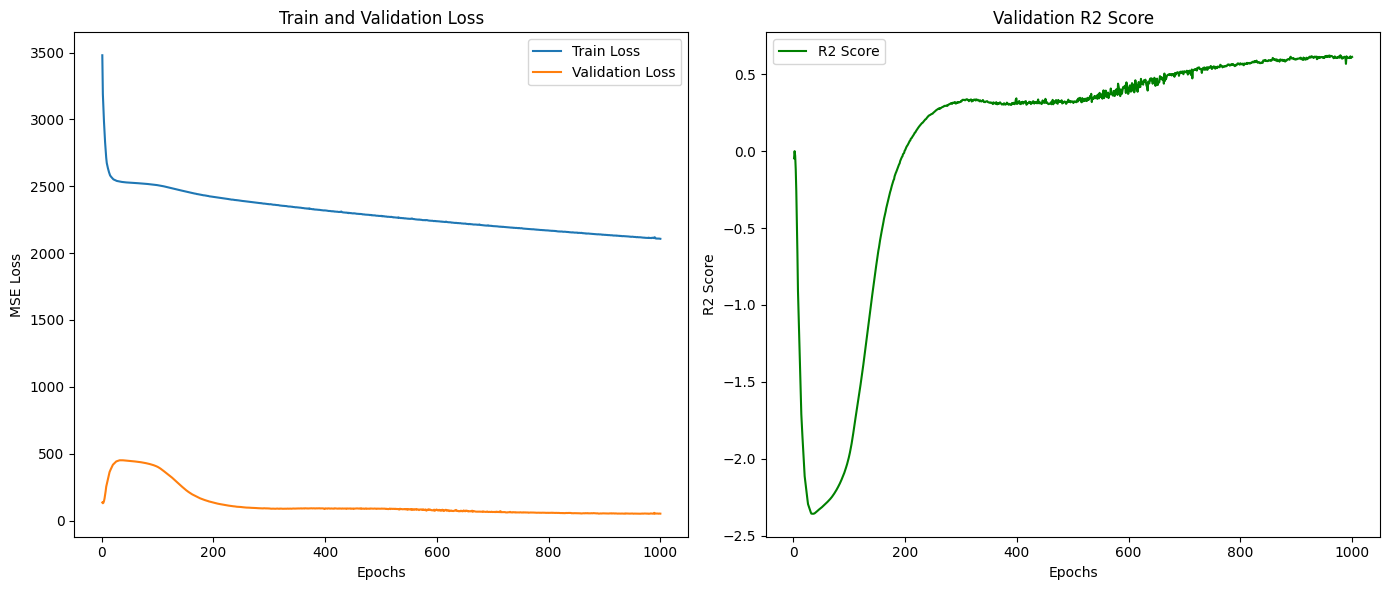

In [10]:
predictor.plot_metrics()

## Inference

In [11]:
test_dataset = FineDustDataset(x_path=test_x, y_path=test_y, sequence_length=168)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [12]:
test_loss, test_r2 = predictor.test(test_loader)

Best model loaded for testing.


Testing: 100%|██████████| 15/15 [00:00<00:00, 82.27it/s]

Test Loss: 398.1575, Test R2 Score: 0.1966
